## 0 Imports and Constants

In [1]:
## 0 Imports and Constants
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_clas, train_test_split, accuracy
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation
from discriminative_model import LSTMClassification, CNNClassification, train_cnn
from baseline_model.LSTM import train_model
from baseline_model.TimeSeriesDataset import TimeSeriesDataset

DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"

In [2]:
MODEL = "cnn"

if MODEL == "lstm":
    hyperparameters = {
        "lr": 0.0001,
        "batch_size": 32,
        "hidden_size": 4,
        "num_layers": 1,
        "bidirectional": True,
        "output_logits": True,
        "num_epochs": 1000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

elif MODEL == "cnn":
    hyperparameters = {
        "lr": 0.00001,
        "batch_size": 32,
        "num_epochs": 1000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

## 1 Loading Data

In [3]:
data = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_train' / 'discriminative_train_42000_13_5.csv', shape=(42000, 13, 5))

In [4]:
train, test = train_test_split(data, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [5]:
X_batch_train, y_batch_train, X_test, y_test, X_batch_val, y_batch_val = extract_features_and_targets_clas(train, test, val)

In [6]:
scaler = Scaler(X_batch_train)

In [7]:
X_batch_train = scaler.scale_data(X_batch_train)
X_test = scaler.scale_data(X_test)
X_batch_val = scaler.scale_data(X_batch_val)

In [8]:
# put data on tensors (since they had to be numpy arrays for the scaler)
X_batch_train = torch.tensor(X_batch_train, dtype=torch.float32)
y_batch_train = torch.tensor(y_batch_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_batch_val = torch.tensor(X_batch_val, dtype=torch.float32)
y_batch_val = torch.tensor(y_batch_val, dtype=torch.float32)

In [9]:
train_dataset = TimeSeriesDataset(X_batch_train, y_batch_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_batch_val, y_batch_val)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)

## 2 Training the model

In [10]:
criterion = nn.BCEWithLogitsLoss()

In [11]:
val_losses = []
val_accs = []
train_losses = []
train_accs = []

In [12]:
if MODEL == 'lstm':

    model = LSTMClassification(
        device=hyperparameters["device"],
        batch_size=hyperparameters["batch_size"],
        input_size=X_batch_train.shape[2],
        hidden_size=hyperparameters["hidden_size"],
        num_stacked_layers=hyperparameters["num_layers"],
        bidirectional=hyperparameters["bidirectional"],
        output_logits=hyperparameters["output_logits"]
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters["lr"])

    train_losses, train_accs, val_losses, val_accs, model = train_model(
                        model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=hyperparameters["device"],
                        num_epochs=hyperparameters["num_epochs"],
                        verbose=True)
    
elif MODEL == 'cnn':

    ### Model ### 
    model = CNNClassification(verbose=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])

    train_losses, val_losses, train_accs, val_accs, model = train_cnn(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
    )

  0%|          | 1/1000 [00:03<51:43,  3.11s/it]

Epoch: 0 
 Train Loss: 0.7137880825996399 
 Train Acc: 50.044642857142854 
 Val Loss: 0.7161843180656433 
 Val Acc: 49.21875
**************************************************


  0%|          | 2/1000 [00:06<49:53,  3.00s/it]

Epoch: 1 
 Train Loss: 0.7121036364351 
 Train Acc: 50.044642857142854 
 Val Loss: 0.714703414476279 
 Val Acc: 49.21875
**************************************************


  0%|          | 3/1000 [00:08<47:44,  2.87s/it]

Epoch: 2 
 Train Loss: 0.7110009062857855 
 Train Acc: 50.044642857142854 
 Val Loss: 0.7136031989798401 
 Val Acc: 49.21875
**************************************************


  0%|          | 4/1000 [00:11<47:58,  2.89s/it]

Epoch: 3 
 Train Loss: 0.709962408542633 
 Train Acc: 50.044642857142854 
 Val Loss: 0.7124305484872876 
 Val Acc: 49.21875
**************************************************


  0%|          | 5/1000 [00:14<47:54,  2.89s/it]

Epoch: 4 
 Train Loss: 0.7088219868569147 
 Train Acc: 50.044642857142854 
 Val Loss: 0.7110974332599929 
 Val Acc: 49.21875
**************************************************


  1%|          | 6/1000 [00:17<48:50,  2.95s/it]

Epoch: 5 
 Train Loss: 0.7075050506705329 
 Train Acc: 50.044642857142854 
 Val Loss: 0.7095508891524691 
 Val Acc: 49.21875
**************************************************


  1%|          | 7/1000 [00:20<47:38,  2.88s/it]

Epoch: 6 
 Train Loss: 0.7060225072361174 
 Train Acc: 50.044642857142854 
 Val Loss: 0.707840516260176 
 Val Acc: 49.21875
**************************************************


  1%|          | 8/1000 [00:23<47:53,  2.90s/it]

Epoch: 7 
 Train Loss: 0.7044206394468036 
 Train Acc: 50.044642857142854 
 Val Loss: 0.7060091563246467 
 Val Acc: 49.21875
**************************************************


  1%|          | 9/1000 [00:26<50:22,  3.05s/it]

Epoch: 8 
 Train Loss: 0.7027451715015229 
 Train Acc: 50.044642857142854 
 Val Loss: 0.7041100403576186 
 Val Acc: 49.21875
**************************************************


  1%|          | 10/1000 [00:29<50:36,  3.07s/it]

Epoch: 9 
 Train Loss: 0.7010627640428997 
 Train Acc: 50.044642857142854 
 Val Loss: 0.7022253003987399 
 Val Acc: 49.21875
**************************************************


  1%|          | 11/1000 [00:32<49:34,  3.01s/it]

Epoch: 10 
 Train Loss: 0.6994514454546429 
 Train Acc: 50.044642857142854 
 Val Loss: 0.7004388715281631 
 Val Acc: 49.21875
**************************************************


  1%|          | 12/1000 [00:35<48:24,  2.94s/it]

Epoch: 11 
 Train Loss: 0.697985325881413 
 Train Acc: 50.044642857142854 
 Val Loss: 0.6988303133032538 
 Val Acc: 49.21875
**************************************************


  1%|▏         | 13/1000 [00:38<47:42,  2.90s/it]

Epoch: 12 
 Train Loss: 0.6967225664570218 
 Train Acc: 50.044642857142854 
 Val Loss: 0.6974552978168834 
 Val Acc: 49.21875
**************************************************


  1%|▏         | 14/1000 [00:41<49:59,  3.04s/it]

Epoch: 13 
 Train Loss: 0.6956937417529878 
 Train Acc: 50.044642857142854 
 Val Loss: 0.6963355902469519 
 Val Acc: 49.21875
**************************************************


  2%|▏         | 15/1000 [00:44<51:11,  3.12s/it]

Epoch: 14 
 Train Loss: 0.6948989778473263 
 Train Acc: 50.044642857142854 
 Val Loss: 0.6954618484684916 
 Val Acc: 49.21875
**************************************************


  2%|▏         | 16/1000 [00:47<49:49,  3.04s/it]

Epoch: 15 
 Train Loss: 0.694314348640896 
 Train Acc: 50.044642857142854 
 Val Loss: 0.6948045894052043 
 Val Acc: 49.21875
**************************************************


  2%|▏         | 17/1000 [00:50<49:06,  3.00s/it]

Epoch: 16 
 Train Loss: 0.6939027168637231 
 Train Acc: 50.044642857142854 
 Val Loss: 0.6943243313016314 
 Val Acc: 49.21875
**************************************************


  2%|▏         | 18/1000 [00:53<47:51,  2.92s/it]

Epoch: 17 
 Train Loss: 0.6936247261365255 
 Train Acc: 50.098214285714285 
 Val Loss: 0.6939924138061928 
 Val Acc: 49.384469696969695
**************************************************


  2%|▏         | 19/1000 [00:56<48:54,  2.99s/it]

Epoch: 18 
 Train Loss: 0.6934498213586353 
 Train Acc: 50.13988095238095 
 Val Loss: 0.6937852005163828 
 Val Acc: 49.952651515151516
**************************************************


  2%|▏         | 20/1000 [00:59<47:43,  2.92s/it]

Epoch: 19 
 Train Loss: 0.6933210317293803 
 Train Acc: 49.970238095238095 
 Val Loss: 0.6936205914526274 
 Val Acc: 49.36079545454545
**************************************************


  2%|▏         | 21/1000 [01:02<49:13,  3.02s/it]

Epoch: 20 
 Train Loss: 0.6932220605441503 
 Train Acc: 50.101190476190474 
 Val Loss: 0.6935252705306718 
 Val Acc: 50.378787878787875
**************************************************


  2%|▏         | 22/1000 [01:05<50:25,  3.09s/it]

Epoch: 21 
 Train Loss: 0.6931816768646241 
 Train Acc: 50.648809523809526 
 Val Loss: 0.693482522260059 
 Val Acc: 50.615530303030305
**************************************************


  2%|▏         | 23/1000 [01:08<49:44,  3.05s/it]

Epoch: 22 
 Train Loss: 0.693161088795889 
 Train Acc: 50.75595238095238 
 Val Loss: 0.6934567098364686 
 Val Acc: 50.97064393939394
**************************************************


  2%|▏         | 24/1000 [01:12<51:58,  3.19s/it]

Epoch: 23 
 Train Loss: 0.6931502271266211 
 Train Acc: 50.916666666666664 
 Val Loss: 0.6934382847764275 
 Val Acc: 50.78125
**************************************************


  2%|▎         | 25/1000 [01:15<52:38,  3.24s/it]

Epoch: 24 
 Train Loss: 0.6931421690895444 
 Train Acc: 50.86309523809524 
 Val Loss: 0.693422307119225 
 Val Acc: 51.01799242424242
**************************************************


  3%|▎         | 26/1000 [01:18<51:55,  3.20s/it]

Epoch: 25 
 Train Loss: 0.6931338786511194 
 Train Acc: 50.794642857142854 
 Val Loss: 0.6934077861634168 
 Val Acc: 51.23106060606061
**************************************************


  3%|▎         | 27/1000 [01:22<52:11,  3.22s/it]

Epoch: 26 
 Train Loss: 0.6931254318214598 
 Train Acc: 50.773809523809526 
 Val Loss: 0.6933946437907942 
 Val Acc: 51.06534090909091
**************************************************


  3%|▎         | 28/1000 [01:24<50:23,  3.11s/it]

Epoch: 27 
 Train Loss: 0.6931182364055088 
 Train Acc: 50.785714285714285 
 Val Loss: 0.6933819331002958 
 Val Acc: 51.041666666666664
**************************************************


  3%|▎         | 29/1000 [01:27<48:41,  3.01s/it]

Epoch: 28 
 Train Loss: 0.6931127352941604 
 Train Acc: 50.857142857142854 
 Val Loss: 0.6933732335314606 
 Val Acc: 50.99431818181818
**************************************************


  3%|▎         | 30/1000 [01:30<47:04,  2.91s/it]

Epoch: 29 
 Train Loss: 0.6931073221138545 
 Train Acc: 50.88988095238095 
 Val Loss: 0.6933657675981522 
 Val Acc: 50.89962121212121
**************************************************


  3%|▎         | 31/1000 [01:33<46:44,  2.89s/it]

Epoch: 30 
 Train Loss: 0.6931020135538919 
 Train Acc: 50.919642857142854 
 Val Loss: 0.6933584091338244 
 Val Acc: 50.97064393939394
**************************************************


  3%|▎         | 32/1000 [01:35<46:11,  2.86s/it]

Epoch: 31 
 Train Loss: 0.693097061600004 
 Train Acc: 50.92857142857143 
 Val Loss: 0.693351532925259 
 Val Acc: 50.99431818181818
**************************************************


  3%|▎         | 33/1000 [01:38<45:27,  2.82s/it]

Epoch: 32 
 Train Loss: 0.6930921992233822 
 Train Acc: 50.92857142857143 
 Val Loss: 0.6933448070829565 
 Val Acc: 50.99431818181818
**************************************************


  3%|▎         | 34/1000 [01:41<45:41,  2.84s/it]

Epoch: 33 
 Train Loss: 0.6930872978482927 
 Train Acc: 50.916666666666664 
 Val Loss: 0.6933381846456816 
 Val Acc: 51.11268939393939
**************************************************


  4%|▎         | 35/1000 [01:44<44:51,  2.79s/it]

Epoch: 34 
 Train Loss: 0.6930825856753758 
 Train Acc: 50.907738095238095 
 Val Loss: 0.6933313982956337 
 Val Acc: 51.08901515151515
**************************************************


  4%|▎         | 36/1000 [01:47<45:00,  2.80s/it]

Epoch: 35 
 Train Loss: 0.6930779320853097 
 Train Acc: 50.92559523809524 
 Val Loss: 0.6933248968738498 
 Val Acc: 51.08901515151515
**************************************************


  4%|▎         | 37/1000 [01:50<46:27,  2.89s/it]

Epoch: 36 
 Train Loss: 0.6930734773476919 
 Train Acc: 50.94940476190476 
 Val Loss: 0.6933186478687056 
 Val Acc: 51.160037878787875
**************************************************


  4%|▍         | 38/1000 [01:52<45:41,  2.85s/it]

Epoch: 37 
 Train Loss: 0.6930690421944573 
 Train Acc: 50.976190476190474 
 Val Loss: 0.6933125415534684 
 Val Acc: 51.44412878787879
**************************************************


  4%|▍         | 39/1000 [01:55<44:48,  2.80s/it]

Epoch: 38 
 Train Loss: 0.6930643640245711 
 Train Acc: 50.976190476190474 
 Val Loss: 0.6933062333952297 
 Val Acc: 51.396780303030305
**************************************************


  4%|▍         | 40/1000 [01:58<44:54,  2.81s/it]

Epoch: 39 
 Train Loss: 0.6930599772362482 
 Train Acc: 51.00892857142857 
 Val Loss: 0.6933005777272311 
 Val Acc: 51.23106060606061
**************************************************


  4%|▍         | 41/1000 [02:01<46:39,  2.92s/it]

Epoch: 40 
 Train Loss: 0.6930555532659803 
 Train Acc: 51.00892857142857 
 Val Loss: 0.6932945377898939 
 Val Acc: 51.46780303030303
**************************************************


  4%|▍         | 42/1000 [02:04<45:24,  2.84s/it]

Epoch: 41 
 Train Loss: 0.693050981589726 
 Train Acc: 51.032738095238095 
 Val Loss: 0.6932883903835759 
 Val Acc: 51.37310606060606
**************************************************


  4%|▍         | 43/1000 [02:07<45:22,  2.84s/it]

Epoch: 42 
 Train Loss: 0.6930464897836958 
 Train Acc: 50.98809523809524 
 Val Loss: 0.6932822583299695 
 Val Acc: 51.49147727272727
**************************************************


  4%|▍         | 44/1000 [02:09<45:07,  2.83s/it]

Epoch: 43 
 Train Loss: 0.6930423365320478 
 Train Acc: 51.0 
 Val Loss: 0.6932762391639479 
 Val Acc: 51.53882575757576
**************************************************


  4%|▍         | 45/1000 [02:12<44:57,  2.82s/it]

Epoch: 44 
 Train Loss: 0.6930379140377044 
 Train Acc: 51.00595238095238 
 Val Loss: 0.6932701694242882 
 Val Acc: 51.49147727272727
**************************************************


  5%|▍         | 46/1000 [02:15<45:20,  2.85s/it]

Epoch: 45 
 Train Loss: 0.6930329843929836 
 Train Acc: 51.00297619047619 
 Val Loss: 0.6932638034676061 
 Val Acc: 51.609848484848484
**************************************************


  5%|▍         | 47/1000 [02:18<44:53,  2.83s/it]

Epoch: 46 
 Train Loss: 0.6930282358896165 
 Train Acc: 51.01488095238095 
 Val Loss: 0.6932573761000778 
 Val Acc: 51.65719696969697
**************************************************


  5%|▍         | 48/1000 [02:21<45:11,  2.85s/it]

Epoch: 47 
 Train Loss: 0.6930234242053259 
 Train Acc: 51.032738095238095 
 Val Loss: 0.6932509315736366 
 Val Acc: 51.609848484848484
**************************************************


  5%|▍         | 49/1000 [02:24<44:44,  2.82s/it]

Epoch: 48 
 Train Loss: 0.6930183000223977 
 Train Acc: 51.017857142857146 
 Val Loss: 0.6932438833243919 
 Val Acc: 51.63352272727273
**************************************************


  5%|▌         | 50/1000 [02:26<44:23,  2.80s/it]

Epoch: 49 
 Train Loss: 0.6930126028401511 
 Train Acc: 51.020833333333336 
 Val Loss: 0.6932364711255738 
 Val Acc: 51.58617424242424
**************************************************


  5%|▌         | 51/1000 [02:29<44:01,  2.78s/it]

Epoch: 50 
 Train Loss: 0.6930057611351922 
 Train Acc: 51.07142857142857 
 Val Loss: 0.6932275701652874 
 Val Acc: 51.65719696969697
**************************************************


  5%|▌         | 52/1000 [02:32<44:12,  2.80s/it]

Epoch: 51 
 Train Loss: 0.6929969792706626 
 Train Acc: 51.12797619047619 
 Val Loss: 0.6932178916353168 
 Val Acc: 51.396780303030305
**************************************************


  5%|▌         | 53/1000 [02:35<43:40,  2.77s/it]

Epoch: 52 
 Train Loss: 0.6929838035220192 
 Train Acc: 51.092261904761905 
 Val Loss: 0.6932083417971929 
 Val Acc: 51.37310606060606
**************************************************


  5%|▌         | 54/1000 [02:37<43:40,  2.77s/it]

Epoch: 53 
 Train Loss: 0.6929719751789456 
 Train Acc: 51.07440476190476 
 Val Loss: 0.6931997776934595 
 Val Acc: 51.302083333333336
**************************************************


  6%|▌         | 55/1000 [02:41<45:58,  2.92s/it]

Epoch: 54 
 Train Loss: 0.6929634703908648 
 Train Acc: 51.05059523809524 
 Val Loss: 0.6931923939423128 
 Val Acc: 51.27840909090909
**************************************************


  6%|▌         | 56/1000 [02:43<44:59,  2.86s/it]

Epoch: 55 
 Train Loss: 0.6929567488034566 
 Train Acc: 51.035714285714285 
 Val Loss: 0.6931839165362444 
 Val Acc: 51.34943181818182
**************************************************


  6%|▌         | 57/1000 [02:46<44:52,  2.86s/it]

Epoch: 56 
 Train Loss: 0.6929504805519467 
 Train Acc: 51.041666666666664 
 Val Loss: 0.6931761611591686 
 Val Acc: 51.46780303030303
**************************************************


  6%|▌         | 58/1000 [02:49<44:26,  2.83s/it]

Epoch: 57 
 Train Loss: 0.6929444242091406 
 Train Acc: 51.07738095238095 
 Val Loss: 0.6931689733808691 
 Val Acc: 51.34943181818182
**************************************************


  6%|▌         | 59/1000 [02:52<43:57,  2.80s/it]

Epoch: 58 
 Train Loss: 0.6929385998135521 
 Train Acc: 51.095238095238095 
 Val Loss: 0.693162150906794 
 Val Acc: 51.302083333333336
**************************************************


  6%|▌         | 60/1000 [02:54<43:36,  2.78s/it]

Epoch: 59 
 Train Loss: 0.6929327456156412 
 Train Acc: 51.092261904761905 
 Val Loss: 0.6931549414540782 
 Val Acc: 51.32575757575758
**************************************************


  6%|▌         | 61/1000 [02:57<43:51,  2.80s/it]

Epoch: 60 
 Train Loss: 0.6929273230121249 
 Train Acc: 51.104166666666664 
 Val Loss: 0.6931478507591017 
 Val Acc: 51.396780303030305
**************************************************


  6%|▌         | 62/1000 [03:00<43:23,  2.78s/it]

Epoch: 61 
 Train Loss: 0.6929217773392087 
 Train Acc: 51.083333333333336 
 Val Loss: 0.6931406286629763 
 Val Acc: 51.515151515151516
**************************************************


  6%|▋         | 63/1000 [03:04<47:44,  3.06s/it]

Epoch: 62 
 Train Loss: 0.6929163881710597 
 Train Acc: 51.092261904761905 
 Val Loss: 0.6931339199795867 
 Val Acc: 51.53882575757576
**************************************************


  6%|▋         | 64/1000 [03:07<46:29,  2.98s/it]

Epoch: 63 
 Train Loss: 0.6929110953921364 
 Train Acc: 51.11309523809524 
 Val Loss: 0.693127199104338 
 Val Acc: 51.75189393939394
**************************************************


  6%|▋         | 65/1000 [03:09<45:20,  2.91s/it]

Epoch: 64 
 Train Loss: 0.6929056610947564 
 Train Acc: 51.086309523809526 
 Val Loss: 0.6931201910430734 
 Val Acc: 51.77556818181818
**************************************************


  7%|▋         | 66/1000 [03:12<44:32,  2.86s/it]

Epoch: 65 
 Train Loss: 0.6929001327355703 
 Train Acc: 51.11011904761905 
 Val Loss: 0.6931135311271205 
 Val Acc: 51.79924242424242
**************************************************


  7%|▋         | 67/1000 [03:15<44:07,  2.84s/it]

Epoch: 66 
 Train Loss: 0.6928945931934175 
 Train Acc: 51.107142857142854 
 Val Loss: 0.6931069118506981 
 Val Acc: 51.728219696969695
**************************************************


  7%|▋         | 68/1000 [03:18<43:59,  2.83s/it]

Epoch: 67 
 Train Loss: 0.6928887782778059 
 Train Acc: 51.13095238095238 
 Val Loss: 0.6931000469308911 
 Val Acc: 51.728219696969695
**************************************************


  7%|▋         | 69/1000 [03:21<44:04,  2.84s/it]

Epoch: 68 
 Train Loss: 0.692883193265824 
 Train Acc: 51.12202380952381 
 Val Loss: 0.6930932240052656 
 Val Acc: 51.58617424242424
**************************************************


  7%|▋         | 70/1000 [03:23<44:05,  2.85s/it]

Epoch: 69 
 Train Loss: 0.6928776032584054 
 Train Acc: 51.095238095238095 
 Val Loss: 0.6930862764517466 
 Val Acc: 51.53882575757576
**************************************************


  7%|▋         | 71/1000 [03:26<43:37,  2.82s/it]

Epoch: 70 
 Train Loss: 0.6928720179058256 
 Train Acc: 51.107142857142854 
 Val Loss: 0.6930793564427983 
 Val Acc: 51.515151515151516
**************************************************


  7%|▋         | 72/1000 [03:29<42:57,  2.78s/it]

Epoch: 71 
 Train Loss: 0.6928659645148686 
 Train Acc: 51.092261904761905 
 Val Loss: 0.6930720024939739 
 Val Acc: 51.65719696969697
**************************************************


  7%|▋         | 73/1000 [03:32<43:02,  2.79s/it]

Epoch: 72 
 Train Loss: 0.6928600955009461 
 Train Acc: 51.101190476190474 
 Val Loss: 0.6930648449695471 
 Val Acc: 51.609848484848484
**************************************************


  7%|▋         | 74/1000 [03:34<42:59,  2.79s/it]

Epoch: 73 
 Train Loss: 0.6928537094025384 
 Train Acc: 51.083333333333336 
 Val Loss: 0.6930574408986352 
 Val Acc: 51.68087121212121
**************************************************


  8%|▊         | 75/1000 [03:37<42:37,  2.77s/it]

Epoch: 74 
 Train Loss: 0.6928476450556801 
 Train Acc: 51.11904761904762 
 Val Loss: 0.6930506983489702 
 Val Acc: 51.5625
**************************************************


  8%|▊         | 76/1000 [03:40<42:38,  2.77s/it]

Epoch: 75 
 Train Loss: 0.6928411005792163 
 Train Acc: 51.095238095238095 
 Val Loss: 0.6930433033090649 
 Val Acc: 51.515151515151516
**************************************************


  8%|▊         | 77/1000 [03:43<43:04,  2.80s/it]

Epoch: 76 
 Train Loss: 0.6928340950466337 
 Train Acc: 51.104166666666664 
 Val Loss: 0.6930354576219212 
 Val Acc: 51.44412878787879
**************************************************


  8%|▊         | 78/1000 [03:46<42:51,  2.79s/it]

Epoch: 77 
 Train Loss: 0.6928270737330119 
 Train Acc: 51.104166666666664 
 Val Loss: 0.6930273261034128 
 Val Acc: 51.37310606060606
**************************************************


  8%|▊         | 79/1000 [03:48<42:45,  2.79s/it]

Epoch: 78 
 Train Loss: 0.6928203420979636 
 Train Acc: 51.11904761904762 
 Val Loss: 0.6930191747166894 
 Val Acc: 51.27840909090909
**************************************************


  8%|▊         | 80/1000 [03:51<43:02,  2.81s/it]

Epoch: 79 
 Train Loss: 0.692813702197302 
 Train Acc: 51.11904761904762 
 Val Loss: 0.69301078897534 
 Val Acc: 51.42045454545455
**************************************************


  8%|▊         | 81/1000 [03:54<43:31,  2.84s/it]

Epoch: 80 
 Train Loss: 0.6928069259439196 
 Train Acc: 51.12797619047619 
 Val Loss: 0.6930021155964244 
 Val Acc: 51.396780303030305
**************************************************


  8%|▊         | 82/1000 [03:57<43:13,  2.83s/it]

Epoch: 81 
 Train Loss: 0.6928000854878199 
 Train Acc: 51.13988095238095 
 Val Loss: 0.692993366357052 
 Val Acc: 51.46780303030303
**************************************************


  8%|▊         | 83/1000 [04:00<42:40,  2.79s/it]

Epoch: 82 
 Train Loss: 0.692793182077862 
 Train Acc: 51.145833333333336 
 Val Loss: 0.6929847178134051 
 Val Acc: 51.42045454545455
**************************************************


  8%|▊         | 84/1000 [04:02<42:43,  2.80s/it]

Epoch: 83 
 Train Loss: 0.6927864407925378 
 Train Acc: 51.13095238095238 
 Val Loss: 0.6929759730895361 
 Val Acc: 51.396780303030305
**************************************************


  8%|▊         | 85/1000 [04:05<43:16,  2.84s/it]

Epoch: 84 
 Train Loss: 0.6927794853846232 
 Train Acc: 51.11309523809524 
 Val Loss: 0.6929671646970691 
 Val Acc: 51.46780303030303
**************************************************


  9%|▊         | 86/1000 [04:08<43:04,  2.83s/it]

Epoch: 85 
 Train Loss: 0.6927720711344765 
 Train Acc: 51.13392857142857 
 Val Loss: 0.6929587116747191 
 Val Acc: 51.63352272727273
**************************************************


  9%|▊         | 87/1000 [04:11<43:01,  2.83s/it]

Epoch: 86 
 Train Loss: 0.6927645531722477 
 Train Acc: 51.13690476190476 
 Val Loss: 0.6929502189159393 
 Val Acc: 51.70454545454545
**************************************************


  9%|▉         | 88/1000 [04:14<42:36,  2.80s/it]

Epoch: 87 
 Train Loss: 0.6927570881730034 
 Train Acc: 51.145833333333336 
 Val Loss: 0.6929414701281171 
 Val Acc: 51.70454545454545
**************************************************


  9%|▉         | 89/1000 [04:17<42:41,  2.81s/it]

Epoch: 88 
 Train Loss: 0.6927495765118372 
 Train Acc: 51.142857142857146 
 Val Loss: 0.6929328933809743 
 Val Acc: 51.63352272727273
**************************************************


  9%|▉         | 90/1000 [04:19<42:59,  2.83s/it]

Epoch: 89 
 Train Loss: 0.6927421222981952 
 Train Acc: 51.151785714285715 
 Val Loss: 0.6929245613741152 
 Val Acc: 51.49147727272727
**************************************************


  9%|▉         | 91/1000 [04:22<43:20,  2.86s/it]

Epoch: 90 
 Train Loss: 0.692734455210822 
 Train Acc: 51.160714285714285 
 Val Loss: 0.6929160857742483 
 Val Acc: 51.515151515151516
**************************************************


  9%|▉         | 92/1000 [04:25<42:50,  2.83s/it]

Epoch: 91 
 Train Loss: 0.6927268729323433 
 Train Acc: 51.160714285714285 
 Val Loss: 0.692907681519335 
 Val Acc: 51.44412878787879
**************************************************


  9%|▉         | 93/1000 [04:28<43:04,  2.85s/it]

Epoch: 92 
 Train Loss: 0.6927190618855613 
 Train Acc: 51.163690476190474 
 Val Loss: 0.6928984798265226 
 Val Acc: 51.515151515151516
**************************************************


  9%|▉         | 94/1000 [04:31<42:23,  2.81s/it]

Epoch: 93 
 Train Loss: 0.6927111757369269 
 Train Acc: 51.157738095238095 
 Val Loss: 0.6928891408624072 
 Val Acc: 51.53882575757576
**************************************************


 10%|▉         | 95/1000 [04:34<42:14,  2.80s/it]

Epoch: 94 
 Train Loss: 0.6927028292701358 
 Train Acc: 51.160714285714285 
 Val Loss: 0.6928798195087549 
 Val Acc: 51.515151515151516
**************************************************


 10%|▉         | 96/1000 [04:37<43:31,  2.89s/it]

Epoch: 95 
 Train Loss: 0.6926948601291293 
 Train Acc: 51.169642857142854 
 Val Loss: 0.6928703383062825 
 Val Acc: 51.63352272727273
**************************************************


 10%|▉         | 97/1000 [04:39<42:58,  2.86s/it]

Epoch: 96 
 Train Loss: 0.6926864761965615 
 Train Acc: 51.163690476190474 
 Val Loss: 0.6928602028073687 
 Val Acc: 51.609848484848484
**************************************************


 10%|▉         | 98/1000 [04:42<43:40,  2.91s/it]

Epoch: 97 
 Train Loss: 0.6926776337055933 
 Train Acc: 51.19345238095238 
 Val Loss: 0.6928498821728157 
 Val Acc: 51.75189393939394
**************************************************


 10%|▉         | 99/1000 [04:45<43:05,  2.87s/it]

Epoch: 98 
 Train Loss: 0.6926684415340424 
 Train Acc: 51.19642857142857 
 Val Loss: 0.6928390955383127 
 Val Acc: 51.63352272727273
**************************************************


 10%|█         | 100/1000 [04:48<43:28,  2.90s/it]

Epoch: 99 
 Train Loss: 0.6926589584350586 
 Train Acc: 51.220238095238095 
 Val Loss: 0.6928280519716667 
 Val Acc: 51.68087121212121
**************************************************


 10%|█         | 101/1000 [04:51<45:24,  3.03s/it]

Epoch: 100 
 Train Loss: 0.6926489196504866 
 Train Acc: 51.25 
 Val Loss: 0.6928172319224386 
 Val Acc: 51.75189393939394
**************************************************


 10%|█         | 102/1000 [04:55<45:23,  3.03s/it]

Epoch: 101 
 Train Loss: 0.692638628028688 
 Train Acc: 51.223214285714285 
 Val Loss: 0.6928045329722491 
 Val Acc: 51.728219696969695
**************************************************


 10%|█         | 103/1000 [04:58<45:19,  3.03s/it]

Epoch: 102 
 Train Loss: 0.692628242799214 
 Train Acc: 51.217261904761905 
 Val Loss: 0.6927927217700265 
 Val Acc: 51.65719696969697
**************************************************


 10%|█         | 104/1000 [05:00<44:35,  2.99s/it]

Epoch: 103 
 Train Loss: 0.6926171014422462 
 Train Acc: 51.229166666666664 
 Val Loss: 0.6927814835851843 
 Val Acc: 51.65719696969697
**************************************************


 10%|█         | 105/1000 [05:04<45:46,  3.07s/it]

Epoch: 104 
 Train Loss: 0.6926057713372367 
 Train Acc: 51.217261904761905 
 Val Loss: 0.6927699202840979 
 Val Acc: 51.728219696969695
**************************************************


 11%|█         | 106/1000 [05:07<45:38,  3.06s/it]

Epoch: 105 
 Train Loss: 0.6925938376926241 
 Train Acc: 51.23511904761905 
 Val Loss: 0.6927573911168359 
 Val Acc: 51.79924242424242
**************************************************


 11%|█         | 107/1000 [05:10<45:29,  3.06s/it]

Epoch: 106 
 Train Loss: 0.6925814387344179 
 Train Acc: 51.24107142857143 
 Val Loss: 0.6927447066162572 
 Val Acc: 51.941287878787875
**************************************************


 11%|█         | 108/1000 [05:13<43:56,  2.96s/it]

Epoch: 107 
 Train Loss: 0.6925691889581226 
 Train Acc: 51.270833333333336 
 Val Loss: 0.6927312088735176 
 Val Acc: 51.84659090909091
**************************************************


 11%|█         | 109/1000 [05:16<44:03,  2.97s/it]

Epoch: 108 
 Train Loss: 0.6925560872895377 
 Train Acc: 51.26190476190476 
 Val Loss: 0.6927170712839473 
 Val Acc: 51.91761363636363
**************************************************


 11%|█         | 110/1000 [05:19<44:08,  2.98s/it]

Epoch: 109 
 Train Loss: 0.6925428240639823 
 Train Acc: 51.29761904761905 
 Val Loss: 0.6927021647041495 
 Val Acc: 52.05965909090909
**************************************************


 11%|█         | 111/1000 [05:21<43:49,  2.96s/it]

Epoch: 110 
 Train Loss: 0.6925289249420166 
 Train Acc: 51.32440476190476 
 Val Loss: 0.6926876852909724 
 Val Acc: 51.79924242424242
**************************************************


 11%|█         | 112/1000 [05:24<44:07,  2.98s/it]

Epoch: 111 
 Train Loss: 0.6925147518089839 
 Train Acc: 51.30059523809524 
 Val Loss: 0.6926729624921625 
 Val Acc: 51.77556818181818
**************************************************


 11%|█▏        | 113/1000 [05:27<44:15,  2.99s/it]

Epoch: 112 
 Train Loss: 0.692500555799121 
 Train Acc: 51.30357142857143 
 Val Loss: 0.6926585164937106 
 Val Acc: 51.63352272727273
**************************************************


 11%|█▏        | 114/1000 [05:30<44:01,  2.98s/it]

Epoch: 113 
 Train Loss: 0.692485918431055 
 Train Acc: 51.30654761904762 
 Val Loss: 0.6926440077297615 
 Val Acc: 51.515151515151516
**************************************************


 12%|█▏        | 115/1000 [05:33<43:52,  2.97s/it]

Epoch: 114 
 Train Loss: 0.6924710241385869 
 Train Acc: 51.294642857142854 
 Val Loss: 0.6926283086791183 
 Val Acc: 51.63352272727273
**************************************************


 12%|█▏        | 116/1000 [05:36<44:13,  3.00s/it]

Epoch: 115 
 Train Loss: 0.6924558513505118 
 Train Acc: 51.333333333333336 
 Val Loss: 0.6926138401031494 
 Val Acc: 51.58617424242424
**************************************************


 12%|█▏        | 117/1000 [05:40<45:12,  3.07s/it]

Epoch: 116 
 Train Loss: 0.6924401001703171 
 Train Acc: 51.342261904761905 
 Val Loss: 0.6925995548566183 
 Val Acc: 51.37310606060606
**************************************************


 12%|█▏        | 118/1000 [05:43<45:34,  3.10s/it]

Epoch: 117 
 Train Loss: 0.6924232083275205 
 Train Acc: 51.351190476190474 
 Val Loss: 0.6925847092361161 
 Val Acc: 51.37310606060606
**************************************************


 12%|█▏        | 119/1000 [05:46<46:24,  3.16s/it]

Epoch: 118 
 Train Loss: 0.6924064393270584 
 Train Acc: 51.36309523809524 
 Val Loss: 0.6925677341042142 
 Val Acc: 51.42045454545455
**************************************************


 12%|█▏        | 120/1000 [05:49<47:04,  3.21s/it]

Epoch: 119 
 Train Loss: 0.6923888694104694 
 Train Acc: 51.38392857142857 
 Val Loss: 0.6925521863229347 
 Val Acc: 51.396780303030305
**************************************************


 12%|█▏        | 121/1000 [05:53<47:50,  3.27s/it]

Epoch: 120 
 Train Loss: 0.6923706045604887 
 Train Acc: 51.404761904761905 
 Val Loss: 0.6925359020630518 
 Val Acc: 51.302083333333336
**************************************************


 12%|█▏        | 122/1000 [05:56<47:50,  3.27s/it]

Epoch: 121 
 Train Loss: 0.6923522739750998 
 Train Acc: 51.38690476190476 
 Val Loss: 0.6925195189136447 
 Val Acc: 51.302083333333336
**************************************************


 12%|█▏        | 123/1000 [05:59<48:02,  3.29s/it]

Epoch: 122 
 Train Loss: 0.6923328651133038 
 Train Acc: 51.419642857142854 
 Val Loss: 0.6925046904520555 
 Val Acc: 51.20738636363637
**************************************************


 12%|█▏        | 124/1000 [06:03<48:14,  3.30s/it]

Epoch: 123 
 Train Loss: 0.692311935140973 
 Train Acc: 51.42559523809524 
 Val Loss: 0.6924848439115466 
 Val Acc: 51.302083333333336
**************************************************


 12%|█▎        | 125/1000 [06:06<48:57,  3.36s/it]

Epoch: 124 
 Train Loss: 0.6922913218679883 
 Train Acc: 51.401785714285715 
 Val Loss: 0.6924647133458744 
 Val Acc: 51.44412878787879
**************************************************


 13%|█▎        | 126/1000 [06:10<48:33,  3.33s/it]

Epoch: 125 
 Train Loss: 0.6922713988735563 
 Train Acc: 51.4375 
 Val Loss: 0.6924476826732809 
 Val Acc: 51.27840909090909
**************************************************


 13%|█▎        | 127/1000 [06:13<47:34,  3.27s/it]

Epoch: 126 
 Train Loss: 0.6922509346689497 
 Train Acc: 51.455357142857146 
 Val Loss: 0.692428980812882 
 Val Acc: 51.42045454545455
**************************************************


 13%|█▎        | 128/1000 [06:16<47:58,  3.30s/it]

Epoch: 127 
 Train Loss: 0.6922305417060852 
 Train Acc: 51.455357142857146 
 Val Loss: 0.6924101516152873 
 Val Acc: 51.515151515151516
**************************************************


 13%|█▎        | 129/1000 [06:20<48:33,  3.35s/it]

Epoch: 128 
 Train Loss: 0.692210110596248 
 Train Acc: 51.44047619047619 
 Val Loss: 0.6923908324855746 
 Val Acc: 51.53882575757576
**************************************************


 13%|█▎        | 130/1000 [06:23<48:28,  3.34s/it]

Epoch: 129 
 Train Loss: 0.6921892901261647 
 Train Acc: 51.43452380952381 
 Val Loss: 0.6923708698966287 
 Val Acc: 51.68087121212121
**************************************************


 13%|█▎        | 131/1000 [06:26<48:08,  3.32s/it]

Epoch: 130 
 Train Loss: 0.6921676353613535 
 Train Acc: 51.4375 
 Val Loss: 0.6923495535597657 
 Val Acc: 51.70454545454545
**************************************************


 13%|█▎        | 132/1000 [06:29<45:30,  3.15s/it]

Epoch: 131 
 Train Loss: 0.6921458913031079 
 Train Acc: 51.455357142857146 
 Val Loss: 0.6923287732131553 
 Val Acc: 51.70454545454545
**************************************************


 13%|█▎        | 133/1000 [06:32<44:05,  3.05s/it]

Epoch: 132 
 Train Loss: 0.6921241239139012 
 Train Acc: 51.458333333333336 
 Val Loss: 0.6923083315292994 
 Val Acc: 51.822916666666664
**************************************************


 13%|█▎        | 134/1000 [06:35<43:41,  3.03s/it]

Epoch: 133 
 Train Loss: 0.6921011938367572 
 Train Acc: 51.45238095238095 
 Val Loss: 0.6922879575779943 
 Val Acc: 51.68087121212121
**************************************************


 14%|█▎        | 135/1000 [06:38<43:20,  3.01s/it]

Epoch: 134 
 Train Loss: 0.6920786120210375 
 Train Acc: 51.49404761904762 
 Val Loss: 0.6922665224833922 
 Val Acc: 51.68087121212121
**************************************************


 14%|█▎        | 136/1000 [06:41<44:27,  3.09s/it]

Epoch: 135 
 Train Loss: 0.6920562633446284 
 Train Acc: 51.49107142857143 
 Val Loss: 0.6922453113577582 
 Val Acc: 51.609848484848484
**************************************************


 14%|█▎        | 137/1000 [06:44<43:41,  3.04s/it]

Epoch: 136 
 Train Loss: 0.6920327833152953 
 Train Acc: 51.49702380952381 
 Val Loss: 0.6922233231139906 
 Val Acc: 51.77556818181818
**************************************************


 14%|█▍        | 138/1000 [06:47<43:10,  3.01s/it]

Epoch: 137 
 Train Loss: 0.6920088072050186 
 Train Acc: 51.50892857142857 
 Val Loss: 0.6922020266453425 
 Val Acc: 51.75189393939394
**************************************************


 14%|█▍        | 139/1000 [06:50<43:05,  3.00s/it]

Epoch: 138 
 Train Loss: 0.691984422263645 
 Train Acc: 51.51488095238095 
 Val Loss: 0.6921802560488383 
 Val Acc: 51.65719696969697
**************************************************


 14%|█▍        | 140/1000 [06:53<43:40,  3.05s/it]

Epoch: 139 
 Train Loss: 0.6919588829789843 
 Train Acc: 51.532738095238095 
 Val Loss: 0.6921556926134861 
 Val Acc: 51.79924242424242
**************************************************


 14%|█▍        | 141/1000 [06:56<43:12,  3.02s/it]

Epoch: 140 
 Train Loss: 0.6919335264819009 
 Train Acc: 51.55654761904762 
 Val Loss: 0.6921325502070513 
 Val Acc: 51.822916666666664
**************************************************


 14%|█▍        | 142/1000 [06:59<42:05,  2.94s/it]

Epoch: 141 
 Train Loss: 0.691907183613096 
 Train Acc: 51.54761904761905 
 Val Loss: 0.692107383500446 
 Val Acc: 51.87026515151515
**************************************************


 14%|█▍        | 143/1000 [07:02<44:07,  3.09s/it]

Epoch: 142 
 Train Loss: 0.6918806362719763 
 Train Acc: 51.55654761904762 
 Val Loss: 0.6920820388830069 
 Val Acc: 51.91761363636363
**************************************************


 14%|█▍        | 144/1000 [07:05<44:14,  3.10s/it]

Epoch: 143 
 Train Loss: 0.6918534936791375 
 Train Acc: 51.580357142857146 
 Val Loss: 0.6920560751900529 
 Val Acc: 51.98863636363637
**************************************************


 14%|█▍        | 145/1000 [07:08<44:14,  3.10s/it]

Epoch: 144 
 Train Loss: 0.6918255855355944 
 Train Acc: 51.607142857142854 
 Val Loss: 0.692029772382794 
 Val Acc: 52.10700757575758
**************************************************


 15%|█▍        | 146/1000 [07:11<43:12,  3.04s/it]

Epoch: 145 
 Train Loss: 0.6917976981685275 
 Train Acc: 51.61011904761905 
 Val Loss: 0.692002616145394 
 Val Acc: 52.15435606060606
**************************************************


 15%|█▍        | 147/1000 [07:14<41:53,  2.95s/it]

Epoch: 146 
 Train Loss: 0.6917691988036746 
 Train Acc: 51.63690476190476 
 Val Loss: 0.6919743599313678 
 Val Acc: 52.15435606060606
**************************************************


 15%|█▍        | 148/1000 [07:17<41:21,  2.91s/it]

Epoch: 147 
 Train Loss: 0.6917401457400549 
 Train Acc: 51.63392857142857 
 Val Loss: 0.6919453234383555 
 Val Acc: 52.20170454545455
**************************************************


 15%|█▍        | 149/1000 [07:20<40:46,  2.87s/it]

Epoch: 148 
 Train Loss: 0.6917101686909085 
 Train Acc: 51.62797619047619 
 Val Loss: 0.6919158764860847 
 Val Acc: 52.391098484848484
**************************************************


 15%|█▌        | 150/1000 [07:23<41:08,  2.90s/it]

Epoch: 149 
 Train Loss: 0.6916801566737039 
 Train Acc: 51.663690476190474 
 Val Loss: 0.6918854844389539 
 Val Acc: 52.27272727272727
**************************************************


 15%|█▌        | 151/1000 [07:25<41:06,  2.90s/it]

Epoch: 150 
 Train Loss: 0.6916490500313895 
 Train Acc: 51.669642857142854 
 Val Loss: 0.6918550711689573 
 Val Acc: 52.36742424242424
**************************************************


 15%|█▌        | 152/1000 [07:28<40:31,  2.87s/it]

Epoch: 151 
 Train Loss: 0.6916172681535994 
 Train Acc: 51.666666666666664 
 Val Loss: 0.6918229718099941 
 Val Acc: 52.178030303030305
**************************************************


 15%|█▌        | 153/1000 [07:31<40:48,  2.89s/it]

Epoch: 152 
 Train Loss: 0.691584483385086 
 Train Acc: 51.69642857142857 
 Val Loss: 0.69179019241622 
 Val Acc: 52.22537878787879
**************************************************


 15%|█▌        | 154/1000 [07:34<40:11,  2.85s/it]

Epoch: 153 
 Train Loss: 0.6915509930111113 
 Train Acc: 51.74404761904762 
 Val Loss: 0.6917570517821745 
 Val Acc: 52.24905303030303
**************************************************


 16%|█▌        | 155/1000 [07:37<40:00,  2.84s/it]

Epoch: 154 
 Train Loss: 0.6915179712431772 
 Train Acc: 51.785714285714285 
 Val Loss: 0.6917232807838556 
 Val Acc: 52.20170454545455
**************************************************


 16%|█▌        | 156/1000 [07:40<39:46,  2.83s/it]

Epoch: 155 
 Train Loss: 0.6914833370276859 
 Train Acc: 51.80357142857143 
 Val Loss: 0.6916889923088478 
 Val Acc: 52.178030303030305
**************************************************


 16%|█▌        | 157/1000 [07:42<39:57,  2.84s/it]

Epoch: 156 
 Train Loss: 0.6914488094193595 
 Train Acc: 51.79761904761905 
 Val Loss: 0.6916533415064667 
 Val Acc: 52.20170454545455
**************************************************


 16%|█▌        | 158/1000 [07:45<39:52,  2.84s/it]

Epoch: 157 
 Train Loss: 0.6914132114251454 
 Train Acc: 51.791666666666664 
 Val Loss: 0.6916167478669774 
 Val Acc: 52.15435606060606
**************************************************


 16%|█▌        | 159/1000 [07:48<39:38,  2.83s/it]

Epoch: 158 
 Train Loss: 0.6913766943840753 
 Train Acc: 51.80059523809524 
 Val Loss: 0.6915789065939008 
 Val Acc: 52.083333333333336
**************************************************


 16%|█▌        | 160/1000 [07:51<40:26,  2.89s/it]

Epoch: 159 
 Train Loss: 0.6913394583406902 
 Train Acc: 51.82738095238095 
 Val Loss: 0.6915405920960687 
 Val Acc: 52.10700757575758
**************************************************


 16%|█▌        | 161/1000 [07:54<40:16,  2.88s/it]

Epoch: 160 
 Train Loss: 0.6913020214580354 
 Train Acc: 51.845238095238095 
 Val Loss: 0.6915021859335176 
 Val Acc: 52.22537878787879
**************************************************


 16%|█▌        | 162/1000 [07:57<39:57,  2.86s/it]

Epoch: 161 
 Train Loss: 0.6912639843282246 
 Train Acc: 51.86607142857143 
 Val Loss: 0.6914629818815173 
 Val Acc: 52.20170454545455
**************************************************


 16%|█▋        | 163/1000 [08:00<39:35,  2.84s/it]

Epoch: 162 
 Train Loss: 0.6912255682264056 
 Train Acc: 51.901785714285715 
 Val Loss: 0.6914234739361387 
 Val Acc: 52.20170454545455
**************************************************


 16%|█▋        | 164/1000 [08:02<39:46,  2.85s/it]

Epoch: 163 
 Train Loss: 0.6911863580204192 
 Train Acc: 51.92559523809524 
 Val Loss: 0.6913839384461894 
 Val Acc: 52.13068181818182
**************************************************


 16%|█▋        | 165/1000 [08:05<39:47,  2.86s/it]

Epoch: 164 
 Train Loss: 0.6911473342350551 
 Train Acc: 51.93452380952381 
 Val Loss: 0.6913437929117319 
 Val Acc: 52.10700757575758
**************************************************


 17%|█▋        | 166/1000 [08:08<39:23,  2.83s/it]

Epoch: 165 
 Train Loss: 0.6911077773003351 
 Train Acc: 51.958333333333336 
 Val Loss: 0.6913036848559524 
 Val Acc: 51.941287878787875
**************************************************


 17%|█▋        | 167/1000 [08:12<42:19,  3.05s/it]

Epoch: 166 
 Train Loss: 0.6910671404997508 
 Train Acc: 51.967261904761905 
 Val Loss: 0.6912627314979379 
 Val Acc: 51.98863636363637
**************************************************


 17%|█▋        | 168/1000 [08:15<41:50,  3.02s/it]

Epoch: 167 
 Train Loss: 0.6910263815947941 
 Train Acc: 52.00297619047619 
 Val Loss: 0.6912205408919941 
 Val Acc: 51.941287878787875
**************************************************


 17%|█▋        | 169/1000 [08:17<41:09,  2.97s/it]

Epoch: 168 
 Train Loss: 0.6909846481822786 
 Train Acc: 52.01488095238095 
 Val Loss: 0.6911771739974166 
 Val Acc: 52.01231060606061
**************************************************


 17%|█▋        | 170/1000 [08:20<40:34,  2.93s/it]

Epoch: 169 
 Train Loss: 0.6909425829705738 
 Train Acc: 52.05654761904762 
 Val Loss: 0.6911343218702258 
 Val Acc: 52.03598484848485
**************************************************


 17%|█▋        | 171/1000 [08:23<40:07,  2.90s/it]

Epoch: 170 
 Train Loss: 0.6909012435731434 
 Train Acc: 52.101190476190474 
 Val Loss: 0.6910920246984019 
 Val Acc: 52.083333333333336
**************************************************


 17%|█▋        | 172/1000 [08:26<39:52,  2.89s/it]

Epoch: 171 
 Train Loss: 0.690859580380576 
 Train Acc: 52.13095238095238 
 Val Loss: 0.6910495712901606 
 Val Acc: 51.98863636363637
**************************************************


 17%|█▋        | 173/1000 [08:29<39:22,  2.86s/it]

Epoch: 172 
 Train Loss: 0.6908170924867902 
 Train Acc: 52.17857142857143 
 Val Loss: 0.6910074759613384 
 Val Acc: 51.941287878787875
**************************************************


 17%|█▋        | 174/1000 [08:32<39:05,  2.84s/it]

Epoch: 173 
 Train Loss: 0.6907745590664092 
 Train Acc: 52.19047619047619 
 Val Loss: 0.6909639726985585 
 Val Acc: 51.91761363636363
**************************************************


 18%|█▊        | 175/1000 [08:34<38:57,  2.83s/it]

Epoch: 174 
 Train Loss: 0.6907317446527027 
 Train Acc: 52.20238095238095 
 Val Loss: 0.6909194859591398 
 Val Acc: 51.941287878787875
**************************************************


 18%|█▊        | 176/1000 [08:37<39:15,  2.86s/it]

Epoch: 175 
 Train Loss: 0.690687789349329 
 Train Acc: 52.226190476190474 
 Val Loss: 0.6908738315105438 
 Val Acc: 52.03598484848485
**************************************************


 18%|█▊        | 177/1000 [08:40<39:41,  2.89s/it]

Epoch: 176 
 Train Loss: 0.6906429487750644 
 Train Acc: 52.24107142857143 
 Val Loss: 0.6908271389477181 
 Val Acc: 51.98863636363637
**************************************************


 18%|█▊        | 178/1000 [08:43<39:24,  2.88s/it]

Epoch: 177 
 Train Loss: 0.69059842529751 
 Train Acc: 52.270833333333336 
 Val Loss: 0.6907804305806304 
 Val Acc: 52.15435606060606
**************************************************


 18%|█▊        | 179/1000 [08:46<39:17,  2.87s/it]

Epoch: 178 
 Train Loss: 0.6905532380512782 
 Train Acc: 52.32738095238095 
 Val Loss: 0.6907347309770007 
 Val Acc: 52.13068181818182
**************************************************


 18%|█▊        | 180/1000 [08:49<39:13,  2.87s/it]

Epoch: 179 
 Train Loss: 0.6905062813418252 
 Train Acc: 52.339285714285715 
 Val Loss: 0.6906874310789686 
 Val Acc: 52.083333333333336
**************************************************


 18%|█▊        | 181/1000 [08:52<39:14,  2.88s/it]

Epoch: 180 
 Train Loss: 0.6904600123564403 
 Train Acc: 52.36309523809524 
 Val Loss: 0.6906393585783063 
 Val Acc: 52.05965909090909
**************************************************


 18%|█▊        | 182/1000 [08:54<38:49,  2.85s/it]

Epoch: 181 
 Train Loss: 0.6904140318575359 
 Train Acc: 52.392857142857146 
 Val Loss: 0.6905916197733446 
 Val Acc: 51.98863636363637
**************************************************


 18%|█▊        | 183/1000 [08:57<38:57,  2.86s/it]

Epoch: 182 
 Train Loss: 0.6903665548279172 
 Train Acc: 52.44345238095238 
 Val Loss: 0.6905453250263677 
 Val Acc: 51.91761363636363
**************************************************


 18%|█▊        | 184/1000 [09:00<38:53,  2.86s/it]

Epoch: 183 
 Train Loss: 0.6903192609264737 
 Train Acc: 52.473214285714285 
 Val Loss: 0.6904986469131528 
 Val Acc: 51.91761363636363
**************************************************


 18%|█▊        | 185/1000 [09:03<39:44,  2.93s/it]

Epoch: 184 
 Train Loss: 0.6902709313801356 
 Train Acc: 52.48809523809524 
 Val Loss: 0.6904501933040041 
 Val Acc: 51.98863636363637
**************************************************


 19%|█▊        | 186/1000 [09:06<40:25,  2.98s/it]

Epoch: 185 
 Train Loss: 0.6902225771404448 
 Train Acc: 52.526785714285715 
 Val Loss: 0.6904030514485908 
 Val Acc: 52.01231060606061
**************************************************


 19%|█▊        | 187/1000 [09:10<42:10,  3.11s/it]

Epoch: 186 
 Train Loss: 0.6901736632415226 
 Train Acc: 52.55654761904762 
 Val Loss: 0.6903552887114611 
 Val Acc: 52.20170454545455
**************************************************


 19%|█▉        | 188/1000 [09:13<43:40,  3.23s/it]

Epoch: 187 
 Train Loss: 0.6901241403534298 
 Train Acc: 52.5625 
 Val Loss: 0.6903059315500837 
 Val Acc: 52.15435606060606
**************************************************


 19%|█▉        | 189/1000 [09:16<42:45,  3.16s/it]

Epoch: 188 
 Train Loss: 0.6900745319184802 
 Train Acc: 52.61011904761905 
 Val Loss: 0.6902563151988116 
 Val Acc: 52.36742424242424
**************************************************


 19%|█▉        | 190/1000 [09:19<41:47,  3.10s/it]

Epoch: 189 
 Train Loss: 0.6900245134035746 
 Train Acc: 52.63690476190476 
 Val Loss: 0.6902066713029688 
 Val Acc: 52.296401515151516
**************************************************


 19%|█▉        | 191/1000 [09:22<40:40,  3.02s/it]

Epoch: 190 
 Train Loss: 0.6899738572892689 
 Train Acc: 52.68452380952381 
 Val Loss: 0.6901573764555382 
 Val Acc: 52.296401515151516
**************************************************


 19%|█▉        | 192/1000 [09:25<40:14,  2.99s/it]

Epoch: 191 
 Train Loss: 0.6899230532419114 
 Train Acc: 52.705357142857146 
 Val Loss: 0.6901061656800184 
 Val Acc: 52.296401515151516
**************************************************


 19%|█▉        | 193/1000 [09:28<39:34,  2.94s/it]

Epoch: 192 
 Train Loss: 0.6898719844363984 
 Train Acc: 52.732142857142854 
 Val Loss: 0.6900559573462515 
 Val Acc: 52.43844696969697
**************************************************


 19%|█▉        | 194/1000 [09:31<39:11,  2.92s/it]

Epoch: 193 
 Train Loss: 0.6898202969346727 
 Train Acc: 52.785714285714285 
 Val Loss: 0.6900059933012183 
 Val Acc: 52.46212121212121
**************************************************


 20%|█▉        | 195/1000 [09:34<38:35,  2.88s/it]

Epoch: 194 
 Train Loss: 0.6897691808428084 
 Train Acc: 52.851190476190474 
 Val Loss: 0.6899570393742938 
 Val Acc: 52.43844696969697
**************************************************


 20%|█▉        | 196/1000 [09:36<38:35,  2.88s/it]

Epoch: 195 
 Train Loss: 0.6897168609074183 
 Train Acc: 52.848214285714285 
 Val Loss: 0.6899047376531543 
 Val Acc: 52.65151515151515
**************************************************


 20%|█▉        | 197/1000 [09:39<38:37,  2.89s/it]

Epoch: 196 
 Train Loss: 0.6896655943847838 
 Train Acc: 52.92261904761905 
 Val Loss: 0.6898548715945446 
 Val Acc: 52.65151515151515
**************************************************


 20%|█▉        | 198/1000 [09:42<38:56,  2.91s/it]

Epoch: 197 
 Train Loss: 0.6896137794426509 
 Train Acc: 52.955357142857146 
 Val Loss: 0.6898046646154288 
 Val Acc: 52.81723484848485
**************************************************


 20%|█▉        | 199/1000 [09:45<38:35,  2.89s/it]

Epoch: 198 
 Train Loss: 0.6895617630935851 
 Train Acc: 52.99702380952381 
 Val Loss: 0.6897544291886416 
 Val Acc: 52.81723484848485
**************************************************


 20%|██        | 200/1000 [09:48<38:21,  2.88s/it]

Epoch: 199 
 Train Loss: 0.6895093975748334 
 Train Acc: 53.029761904761905 
 Val Loss: 0.6897045112017429 
 Val Acc: 52.88825757575758
**************************************************


 20%|██        | 201/1000 [09:51<38:31,  2.89s/it]

Epoch: 200 
 Train Loss: 0.6894565448306855 
 Train Acc: 53.0625 
 Val Loss: 0.6896534160231099 
 Val Acc: 52.88825757575758
**************************************************


 20%|██        | 202/1000 [09:54<38:26,  2.89s/it]

Epoch: 201 
 Train Loss: 0.6894043828192211 
 Train Acc: 53.11309523809524 
 Val Loss: 0.6896025642301097 
 Val Acc: 52.91193181818182
**************************************************


 20%|██        | 203/1000 [09:57<40:32,  3.05s/it]

Epoch: 202 
 Train Loss: 0.6893514744440714 
 Train Acc: 53.154761904761905 
 Val Loss: 0.6895516419952566 
 Val Acc: 52.93560606060606
**************************************************


 20%|██        | 204/1000 [10:00<40:40,  3.07s/it]

Epoch: 203 
 Train Loss: 0.6892994449819837 
 Train Acc: 53.17261904761905 
 Val Loss: 0.6894994432275946 
 Val Acc: 52.98295454545455
**************************************************


 20%|██        | 205/1000 [10:03<39:51,  3.01s/it]

Epoch: 204 
 Train Loss: 0.6892464990275247 
 Train Acc: 53.217261904761905 
 Val Loss: 0.6894480680877512 
 Val Acc: 53.125
**************************************************


 21%|██        | 206/1000 [10:06<39:29,  2.98s/it]

Epoch: 205 
 Train Loss: 0.6891932466484252 
 Train Acc: 53.25892857142857 
 Val Loss: 0.6893973368586916 
 Val Acc: 53.00662878787879
**************************************************


 21%|██        | 207/1000 [10:09<39:28,  2.99s/it]

Epoch: 206 
 Train Loss: 0.6891393763110751 
 Train Acc: 53.294642857142854 
 Val Loss: 0.6893467961838751 
 Val Acc: 53.05397727272727
**************************************************


 21%|██        | 208/1000 [10:12<39:46,  3.01s/it]

Epoch: 207 
 Train Loss: 0.6890863429932367 
 Train Acc: 53.333333333333336 
 Val Loss: 0.6892957908637596 
 Val Acc: 53.125
**************************************************


 21%|██        | 209/1000 [10:15<40:49,  3.10s/it]

Epoch: 208 
 Train Loss: 0.6890321223508744 
 Train Acc: 53.36011904761905 
 Val Loss: 0.68924442069097 
 Val Acc: 53.125
**************************************************


 21%|██        | 210/1000 [10:19<41:15,  3.13s/it]

Epoch: 209 
 Train Loss: 0.6889783578259604 
 Train Acc: 53.38392857142857 
 Val Loss: 0.6891917058012702 
 Val Acc: 53.10132575757576
**************************************************


 21%|██        | 211/1000 [10:22<40:46,  3.10s/it]

Epoch: 210 
 Train Loss: 0.6889245404515948 
 Train Acc: 53.413690476190474 
 Val Loss: 0.6891383366151289 
 Val Acc: 53.03030303030303
**************************************************


 21%|██        | 212/1000 [10:25<42:52,  3.27s/it]

Epoch: 211 
 Train Loss: 0.6888700372832162 
 Train Acc: 53.458333333333336 
 Val Loss: 0.6890844156344732 
 Val Acc: 53.10132575757576
**************************************************


 21%|██▏       | 213/1000 [10:29<42:46,  3.26s/it]

Epoch: 212 
 Train Loss: 0.6888160064674559 
 Train Acc: 53.50892857142857 
 Val Loss: 0.6890316149502089 
 Val Acc: 53.19602272727273
**************************************************


 21%|██▏       | 214/1000 [10:32<42:28,  3.24s/it]

Epoch: 213 
 Train Loss: 0.6887614077045804 
 Train Acc: 53.532738095238095 
 Val Loss: 0.6889778222098495 
 Val Acc: 53.290719696969695
**************************************************


 22%|██▏       | 215/1000 [10:35<41:42,  3.19s/it]

Epoch: 214 
 Train Loss: 0.6887064809458596 
 Train Acc: 53.54761904761905 
 Val Loss: 0.6889233015703432 
 Val Acc: 53.45643939393939
**************************************************


 22%|██▏       | 216/1000 [10:38<42:23,  3.24s/it]

Epoch: 215 
 Train Loss: 0.6886520336355482 
 Train Acc: 53.592261904761905 
 Val Loss: 0.6888699116128864 
 Val Acc: 53.43276515151515
**************************************************


 22%|██▏       | 217/1000 [10:42<42:56,  3.29s/it]

Epoch: 216 
 Train Loss: 0.6885968169711885 
 Train Acc: 53.63392857142857 
 Val Loss: 0.688817205302643 
 Val Acc: 53.503787878787875
**************************************************


 22%|██▏       | 218/1000 [10:45<44:10,  3.39s/it]

Epoch: 217 
 Train Loss: 0.6885420302549998 
 Train Acc: 53.654761904761905 
 Val Loss: 0.6887643906203184 
 Val Acc: 53.59848484848485
**************************************************


 22%|██▏       | 219/1000 [10:49<44:30,  3.42s/it]

Epoch: 218 
 Train Loss: 0.688486745981943 
 Train Acc: 53.70238095238095 
 Val Loss: 0.6887110385930899 
 Val Acc: 53.62215909090909
**************************************************


 22%|██▏       | 220/1000 [10:52<44:34,  3.43s/it]

Epoch: 219 
 Train Loss: 0.6884316303616478 
 Train Acc: 53.75595238095238 
 Val Loss: 0.6886576034805991 
 Val Acc: 53.55113636363637
**************************************************


 22%|██▏       | 221/1000 [10:55<43:53,  3.38s/it]

Epoch: 220 
 Train Loss: 0.6883761303765433 
 Train Acc: 53.794642857142854 
 Val Loss: 0.6886041430812894 
 Val Acc: 53.645833333333336
**************************************************


 22%|██▏       | 222/1000 [10:59<43:27,  3.35s/it]

Epoch: 221 
 Train Loss: 0.6883214334079197 
 Train Acc: 53.82738095238095 
 Val Loss: 0.6885497971917643 
 Val Acc: 53.78787878787879
**************************************************


 22%|██▏       | 223/1000 [11:03<45:28,  3.51s/it]

Epoch: 222 
 Train Loss: 0.6882669167859213 
 Train Acc: 53.88988095238095 
 Val Loss: 0.6884967373176054 
 Val Acc: 53.81155303030303
**************************************************


 22%|██▏       | 224/1000 [11:06<44:20,  3.43s/it]

Epoch: 223 
 Train Loss: 0.6882115521885099 
 Train Acc: 53.92261904761905 
 Val Loss: 0.6884436765403459 
 Val Acc: 53.90625
**************************************************


 22%|██▎       | 225/1000 [11:09<43:57,  3.40s/it]

Epoch: 224 
 Train Loss: 0.6881557375476474 
 Train Acc: 53.955357142857146 
 Val Loss: 0.6883892407923033 
 Val Acc: 53.90625
**************************************************


 23%|██▎       | 226/1000 [11:13<44:36,  3.46s/it]

Epoch: 225 
 Train Loss: 0.6881004468599955 
 Train Acc: 54.0 
 Val Loss: 0.6883351130015922 
 Val Acc: 53.953598484848484
**************************************************


 23%|██▎       | 227/1000 [11:16<44:16,  3.44s/it]

Epoch: 226 
 Train Loss: 0.6880449182078952 
 Train Acc: 54.041666666666664 
 Val Loss: 0.6882808881275582 
 Val Acc: 53.953598484848484
**************************************************


 23%|██▎       | 228/1000 [11:20<43:47,  3.40s/it]

Epoch: 227 
 Train Loss: 0.6879896573225657 
 Train Acc: 54.080357142857146 
 Val Loss: 0.6882274810111884 
 Val Acc: 54.04829545454545
**************************************************


 23%|██▎       | 229/1000 [11:22<41:37,  3.24s/it]

Epoch: 228 
 Train Loss: 0.6879344568366096 
 Train Acc: 54.12202380952381 
 Val Loss: 0.6881740662184629 
 Val Acc: 54.19034090909091
**************************************************


 23%|██▎       | 230/1000 [11:25<40:39,  3.17s/it]

Epoch: 229 
 Train Loss: 0.6878793176582881 
 Train Acc: 54.13690476190476 
 Val Loss: 0.6881195568677151 
 Val Acc: 54.21401515151515
**************************************************


 23%|██▎       | 231/1000 [11:28<39:21,  3.07s/it]

Epoch: 230 
 Train Loss: 0.6878245352563404 
 Train Acc: 54.19345238095238 
 Val Loss: 0.6880655144200181 
 Val Acc: 54.19034090909091
**************************************************


 23%|██▎       | 232/1000 [11:31<38:31,  3.01s/it]

Epoch: 231 
 Train Loss: 0.6877695126760573 
 Train Acc: 54.229166666666664 
 Val Loss: 0.6880118837862303 
 Val Acc: 54.23768939393939
**************************************************


 23%|██▎       | 233/1000 [11:34<38:32,  3.01s/it]

Epoch: 232 
 Train Loss: 0.6877137251127334 
 Train Acc: 54.24702380952381 
 Val Loss: 0.6879572172959646 
 Val Acc: 54.33238636363637
**************************************************


 23%|██▎       | 234/1000 [11:37<38:07,  2.99s/it]

Epoch: 233 
 Train Loss: 0.6876562981378465 
 Train Acc: 54.285714285714285 
 Val Loss: 0.6879025873812762 
 Val Acc: 54.40340909090909
**************************************************


 24%|██▎       | 235/1000 [11:40<39:23,  3.09s/it]

Epoch: 234 
 Train Loss: 0.6875929910228366 
 Train Acc: 54.276785714285715 
 Val Loss: 0.6878359493884173 
 Val Acc: 54.521780303030305
**************************************************


 24%|██▎       | 236/1000 [11:44<40:20,  3.17s/it]

Epoch: 235 
 Train Loss: 0.6875177078020005 
 Train Acc: 54.330357142857146 
 Val Loss: 0.6877537866433462 
 Val Acc: 54.61647727272727
**************************************************


 24%|██▎       | 237/1000 [11:48<43:05,  3.39s/it]

Epoch: 236 
 Train Loss: 0.6873922631854102 
 Train Acc: 54.357142857142854 
 Val Loss: 0.6876208682854971 
 Val Acc: 55.066287878787875
**************************************************


 24%|██▍       | 238/1000 [11:51<42:33,  3.35s/it]

Epoch: 237 
 Train Loss: 0.687285224369594 
 Train Acc: 54.50892857142857 
 Val Loss: 0.6875583217902617 
 Val Acc: 55.11363636363637
**************************************************


 24%|██▍       | 239/1000 [11:54<42:36,  3.36s/it]

Epoch: 238 
 Train Loss: 0.6872245147682372 
 Train Acc: 54.589285714285715 
 Val Loss: 0.6875033956585508 
 Val Acc: 55.25568181818182
**************************************************


 24%|██▍       | 240/1000 [11:57<41:22,  3.27s/it]

Epoch: 239 
 Train Loss: 0.6871684575648535 
 Train Acc: 54.63690476190476 
 Val Loss: 0.6874502197359548 
 Val Acc: 55.27935606060606
**************************************************


 24%|██▍       | 241/1000 [12:00<40:07,  3.17s/it]

Epoch: 240 
 Train Loss: 0.6871122774623689 
 Train Acc: 54.666666666666664 
 Val Loss: 0.6873972510749643 
 Val Acc: 55.25568181818182
**************************************************


 24%|██▍       | 242/1000 [12:03<39:56,  3.16s/it]

Epoch: 241 
 Train Loss: 0.6870574757598695 
 Train Acc: 54.711309523809526 
 Val Loss: 0.6873448843305762 
 Val Acc: 55.25568181818182
**************************************************


 24%|██▍       | 243/1000 [12:08<45:24,  3.60s/it]

Epoch: 242 
 Train Loss: 0.6870019700413659 
 Train Acc: 54.720238095238095 
 Val Loss: 0.6872915982296972 
 Val Acc: 55.27935606060606
**************************************************


 24%|██▍       | 244/1000 [12:12<46:48,  3.71s/it]

Epoch: 243 
 Train Loss: 0.6869482693785712 
 Train Acc: 54.770833333333336 
 Val Loss: 0.687238865277984 
 Val Acc: 55.39772727272727
**************************************************


 24%|██▍       | 245/1000 [12:15<44:33,  3.54s/it]

Epoch: 244 
 Train Loss: 0.68689382036527 
 Train Acc: 54.80059523809524 
 Val Loss: 0.6871862881111376 
 Val Acc: 55.46875
**************************************************


 25%|██▍       | 246/1000 [12:18<41:45,  3.32s/it]

Epoch: 245 
 Train Loss: 0.6868388656775156 
 Train Acc: 54.830357142857146 
 Val Loss: 0.6871337849985469 
 Val Acc: 55.58712121212121
**************************************************


 25%|██▍       | 247/1000 [12:21<41:05,  3.27s/it]

Epoch: 246 
 Train Loss: 0.6867843579678309 
 Train Acc: 54.857142857142854 
 Val Loss: 0.6870815054033742 
 Val Acc: 55.65814393939394
**************************************************


 25%|██▍       | 248/1000 [12:25<42:02,  3.35s/it]

Epoch: 247 
 Train Loss: 0.686730199995495 
 Train Acc: 54.916666666666664 
 Val Loss: 0.6870293486298937 
 Val Acc: 55.65814393939394
**************************************************


 25%|██▍       | 249/1000 [12:28<43:39,  3.49s/it]

Epoch: 248 
 Train Loss: 0.6866761267752874 
 Train Acc: 54.95238095238095 
 Val Loss: 0.6869773282246157 
 Val Acc: 55.68181818181818
**************************************************


 25%|██▌       | 250/1000 [12:33<46:16,  3.70s/it]

Epoch: 249 
 Train Loss: 0.6866219359352476 
 Train Acc: 54.973214285714285 
 Val Loss: 0.6869253674239824 
 Val Acc: 55.65814393939394
**************************************************


 25%|██▌       | 251/1000 [12:36<45:35,  3.65s/it]

Epoch: 250 
 Train Loss: 0.6865682515643892 
 Train Acc: 55.017857142857146 
 Val Loss: 0.6868737416737007 
 Val Acc: 55.729166666666664
**************************************************


 25%|██▌       | 252/1000 [12:40<44:35,  3.58s/it]

Epoch: 251 
 Train Loss: 0.6865144789218902 
 Train Acc: 55.05357142857143 
 Val Loss: 0.6868224712935361 
 Val Acc: 55.847537878787875
**************************************************


 25%|██▌       | 253/1000 [12:44<46:05,  3.70s/it]

Epoch: 252 
 Train Loss: 0.6864601880595798 
 Train Acc: 55.07142857142857 
 Val Loss: 0.6867714880993872 
 Val Acc: 55.871212121212125
**************************************************


 25%|██▌       | 254/1000 [12:47<45:34,  3.67s/it]

Epoch: 253 
 Train Loss: 0.6864065065270378 
 Train Acc: 55.125 
 Val Loss: 0.686720460653305 
 Val Acc: 55.89488636363637
**************************************************


 26%|██▌       | 255/1000 [12:51<45:21,  3.65s/it]

Epoch: 254 
 Train Loss: 0.6863534635589237 
 Train Acc: 55.166666666666664 
 Val Loss: 0.6866697836102862 
 Val Acc: 55.89488636363637
**************************************************


 26%|██▌       | 256/1000 [12:54<43:40,  3.52s/it]

Epoch: 255 
 Train Loss: 0.6863012916133517 
 Train Acc: 55.19940476190476 
 Val Loss: 0.6866195852106268 
 Val Acc: 55.94223484848485
**************************************************


 26%|██▌       | 257/1000 [12:57<43:05,  3.48s/it]

Epoch: 256 
 Train Loss: 0.6862488840875172 
 Train Acc: 55.229166666666664 
 Val Loss: 0.6865696586442717 
 Val Acc: 55.91856060606061
**************************************************


 26%|██▌       | 258/1000 [13:01<42:04,  3.40s/it]

Epoch: 257 
 Train Loss: 0.6861969659441993 
 Train Acc: 55.26488095238095 
 Val Loss: 0.6865200567426104 
 Val Acc: 55.989583333333336
**************************************************


 26%|██▌       | 259/1000 [13:04<42:17,  3.42s/it]

Epoch: 258 
 Train Loss: 0.6861448020594461 
 Train Acc: 55.285714285714285 
 Val Loss: 0.6864705763079904 
 Val Acc: 55.989583333333336
**************************************************


 26%|██▌       | 260/1000 [13:07<40:56,  3.32s/it]

Epoch: 259 
 Train Loss: 0.6860931930087861 
 Train Acc: 55.32440476190476 
 Val Loss: 0.686421301780325 
 Val Acc: 55.989583333333336
**************************************************


 26%|██▌       | 261/1000 [13:10<39:53,  3.24s/it]

Epoch: 260 
 Train Loss: 0.6860421813101996 
 Train Acc: 55.36309523809524 
 Val Loss: 0.686372257994883 
 Val Acc: 55.96590909090909
**************************************************


 26%|██▌       | 262/1000 [13:13<39:58,  3.25s/it]

Epoch: 261 
 Train Loss: 0.6859911032517751 
 Train Acc: 55.404761904761905 
 Val Loss: 0.6863234783663894 
 Val Acc: 56.01325757575758
**************************************************


 26%|██▋       | 263/1000 [13:17<41:51,  3.41s/it]

Epoch: 262 
 Train Loss: 0.6859399735359919 
 Train Acc: 55.44345238095238 
 Val Loss: 0.6862752270517927 
 Val Acc: 56.03693181818182
**************************************************


 26%|██▋       | 264/1000 [13:21<43:06,  3.51s/it]

Epoch: 263 
 Train Loss: 0.6858902505465916 
 Train Acc: 55.479166666666664 
 Val Loss: 0.6862269978631627 
 Val Acc: 56.084280303030305
**************************************************


 26%|██▋       | 265/1000 [13:24<41:57,  3.42s/it]

Epoch: 264 
 Train Loss: 0.685840018703824 
 Train Acc: 55.51190476190476 
 Val Loss: 0.6861788160873182 
 Val Acc: 56.15530303030303
**************************************************


 27%|██▋       | 266/1000 [13:28<42:59,  3.51s/it]

Epoch: 265 
 Train Loss: 0.6857905843712034 
 Train Acc: 55.541666666666664 
 Val Loss: 0.6861311337261489 
 Val Acc: 56.25
**************************************************


 27%|██▋       | 267/1000 [13:31<41:30,  3.40s/it]

Epoch: 266 
 Train Loss: 0.6857409258683522 
 Train Acc: 55.592261904761905 
 Val Loss: 0.6860837733203714 
 Val Acc: 56.25
**************************************************


 27%|██▋       | 268/1000 [13:34<40:38,  3.33s/it]

Epoch: 267 
 Train Loss: 0.6856918213480995 
 Train Acc: 55.63988095238095 
 Val Loss: 0.6860367059707642 
 Val Acc: 56.297348484848484
**************************************************


 27%|██▋       | 269/1000 [13:38<41:22,  3.40s/it]

Epoch: 268 
 Train Loss: 0.6856425134908586 
 Train Acc: 55.651785714285715 
 Val Loss: 0.6859892552549188 
 Val Acc: 56.32102272727273
**************************************************


 27%|██▋       | 270/1000 [13:41<40:08,  3.30s/it]

Epoch: 269 
 Train Loss: 0.6855942496799288 
 Train Acc: 55.67559523809524 
 Val Loss: 0.6859419567115379 
 Val Acc: 56.43939393939394
**************************************************


 27%|██▋       | 271/1000 [13:44<39:58,  3.29s/it]

Epoch: 270 
 Train Loss: 0.6855454720769609 
 Train Acc: 55.714285714285715 
 Val Loss: 0.6858950022495154 
 Val Acc: 56.39204545454545
**************************************************


 27%|██▋       | 272/1000 [13:47<39:37,  3.27s/it]

Epoch: 271 
 Train Loss: 0.6854973446755183 
 Train Acc: 55.75297619047619 
 Val Loss: 0.6858483855471467 
 Val Acc: 56.43939393939394
**************************************************


 27%|██▋       | 273/1000 [13:50<38:57,  3.22s/it]

Epoch: 272 
 Train Loss: 0.6854484835125151 
 Train Acc: 55.791666666666664 
 Val Loss: 0.6858021738854322 
 Val Acc: 56.53409090909091
**************************************************


 27%|██▋       | 274/1000 [13:54<39:15,  3.24s/it]

Epoch: 273 
 Train Loss: 0.6854000547386351 
 Train Acc: 55.830357142857146 
 Val Loss: 0.6857561049136248 
 Val Acc: 56.55776515151515
**************************************************


 28%|██▊       | 275/1000 [13:57<40:05,  3.32s/it]

Epoch: 274 
 Train Loss: 0.6853523920831226 
 Train Acc: 55.851190476190474 
 Val Loss: 0.6857103791200754 
 Val Acc: 56.55776515151515
**************************************************


 28%|██▊       | 276/1000 [14:01<39:59,  3.31s/it]

Epoch: 275 
 Train Loss: 0.6853036360513596 
 Train Acc: 55.86309523809524 
 Val Loss: 0.6856645147005717 
 Val Acc: 56.628787878787875
**************************************************


 28%|██▊       | 277/1000 [14:04<39:22,  3.27s/it]

Epoch: 276 
 Train Loss: 0.6852559404146104 
 Train Acc: 55.898809523809526 
 Val Loss: 0.6856187771667134 
 Val Acc: 56.652462121212125
**************************************************


 28%|██▊       | 278/1000 [14:07<40:18,  3.35s/it]

Epoch: 277 
 Train Loss: 0.685208241485414 
 Train Acc: 55.94642857142857 
 Val Loss: 0.6855731778072588 
 Val Acc: 56.628787878787875
**************************************************


 28%|██▊       | 279/1000 [14:10<39:41,  3.30s/it]

Epoch: 278 
 Train Loss: 0.6851599004722777 
 Train Acc: 55.967261904761905 
 Val Loss: 0.6855275865757104 
 Val Acc: 56.67613636363637
**************************************************


 28%|██▊       | 280/1000 [14:14<39:50,  3.32s/it]

Epoch: 279 
 Train Loss: 0.6851126798561641 
 Train Acc: 56.017857142857146 
 Val Loss: 0.6854822694352178 
 Val Acc: 56.67613636363637
**************************************************


 28%|██▊       | 281/1000 [14:17<39:46,  3.32s/it]

Epoch: 280 
 Train Loss: 0.6850663480304536 
 Train Acc: 56.041666666666664 
 Val Loss: 0.6854369450699199 
 Val Acc: 56.67613636363637
**************************************************


 28%|██▊       | 282/1000 [14:20<38:35,  3.22s/it]

Epoch: 281 
 Train Loss: 0.6850189250423795 
 Train Acc: 56.05952380952381 
 Val Loss: 0.6853915773557894 
 Val Acc: 56.88920454545455
**************************************************


 28%|██▊       | 283/1000 [14:23<37:37,  3.15s/it]

Epoch: 282 
 Train Loss: 0.6849719314915793 
 Train Acc: 56.07738095238095 
 Val Loss: 0.6853461861610413 
 Val Acc: 56.91287878787879
**************************************************


 28%|██▊       | 284/1000 [14:26<38:05,  3.19s/it]

Epoch: 283 
 Train Loss: 0.684925072931108 
 Train Acc: 56.12202380952381 
 Val Loss: 0.6853004373384245 
 Val Acc: 56.93655303030303
**************************************************


 28%|██▊       | 285/1000 [14:30<37:52,  3.18s/it]

Epoch: 284 
 Train Loss: 0.6848779681183043 
 Train Acc: 56.13392857142857 
 Val Loss: 0.6852549707347696 
 Val Acc: 57.00757575757576
**************************************************


 29%|██▊       | 286/1000 [14:32<36:34,  3.07s/it]

Epoch: 285 
 Train Loss: 0.6848312276885623 
 Train Acc: 56.169642857142854 
 Val Loss: 0.6852098802725474 
 Val Acc: 57.17329545454545
**************************************************


 29%|██▊       | 287/1000 [14:35<35:39,  3.00s/it]

Epoch: 286 
 Train Loss: 0.6847854059650784 
 Train Acc: 56.19940476190476 
 Val Loss: 0.6851646128025922 
 Val Acc: 57.10227272727273
**************************************************


 29%|██▉       | 288/1000 [14:38<34:23,  2.90s/it]

Epoch: 287 
 Train Loss: 0.6847393349238804 
 Train Acc: 56.23511904761905 
 Val Loss: 0.6851197133461634 
 Val Acc: 57.17329545454545
**************************************************


 29%|██▉       | 289/1000 [14:41<34:52,  2.94s/it]

Epoch: 288 
 Train Loss: 0.6846931719779968 
 Train Acc: 56.26488095238095 
 Val Loss: 0.6850754076784308 
 Val Acc: 57.17329545454545
**************************************************


 29%|██▉       | 290/1000 [14:44<34:50,  2.94s/it]

Epoch: 289 
 Train Loss: 0.6846469718501681 
 Train Acc: 56.267857142857146 
 Val Loss: 0.6850315084060034 
 Val Acc: 57.24431818181818
**************************************************


 29%|██▉       | 291/1000 [14:47<35:40,  3.02s/it]

Epoch: 290 
 Train Loss: 0.68460163241341 
 Train Acc: 56.3125 
 Val Loss: 0.6849868514321067 
 Val Acc: 57.33901515151515
**************************************************


 29%|██▉       | 292/1000 [14:50<36:19,  3.08s/it]

Epoch: 291 
 Train Loss: 0.6845563315209888 
 Train Acc: 56.330357142857146 
 Val Loss: 0.6849425010608904 
 Val Acc: 57.36268939393939
**************************************************


 29%|██▉       | 293/1000 [14:54<36:53,  3.13s/it]

Epoch: 292 
 Train Loss: 0.684510696501959 
 Train Acc: 56.351190476190474 
 Val Loss: 0.6848990993969368 
 Val Acc: 57.45738636363637
**************************************************


 29%|██▉       | 294/1000 [14:57<38:08,  3.24s/it]

Epoch: 293 
 Train Loss: 0.6844666123957861 
 Train Acc: 56.398809523809526 
 Val Loss: 0.6848552470857446 
 Val Acc: 57.48106060606061
**************************************************


 30%|██▉       | 295/1000 [15:01<41:07,  3.50s/it]

Epoch: 294 
 Train Loss: 0.6844217482634953 
 Train Acc: 56.42559523809524 
 Val Loss: 0.6848121800205924 
 Val Acc: 57.45738636363637
**************************************************


 30%|██▉       | 296/1000 [15:05<42:54,  3.66s/it]

Epoch: 295 
 Train Loss: 0.6843752003283727 
 Train Acc: 56.43154761904762 
 Val Loss: 0.6847702147382678 
 Val Acc: 57.50473484848485
**************************************************


 30%|██▉       | 297/1000 [15:09<42:24,  3.62s/it]

Epoch: 296 
 Train Loss: 0.6843306246257964 
 Train Acc: 56.467261904761905 
 Val Loss: 0.6847268442312876 
 Val Acc: 57.50473484848485
**************************************************


 30%|██▉       | 298/1000 [15:12<41:41,  3.56s/it]

Epoch: 297 
 Train Loss: 0.6842850472813561 
 Train Acc: 56.48511904761905 
 Val Loss: 0.6846839835246404 
 Val Acc: 57.552083333333336
**************************************************


 30%|██▉       | 299/1000 [15:15<39:59,  3.42s/it]

Epoch: 298 
 Train Loss: 0.6842412675562359 
 Train Acc: 56.520833333333336 
 Val Loss: 0.6846414894768686 
 Val Acc: 57.69412878787879
**************************************************


 30%|███       | 300/1000 [15:18<38:08,  3.27s/it]

Epoch: 299 
 Train Loss: 0.6841971143654415 
 Train Acc: 56.55357142857143 
 Val Loss: 0.684599008975607 
 Val Acc: 57.71780303030303
**************************************************


 30%|███       | 301/1000 [15:22<38:51,  3.34s/it]

Epoch: 300 
 Train Loss: 0.6841546109744481 
 Train Acc: 56.595238095238095 
 Val Loss: 0.6845554461081823 
 Val Acc: 57.74147727272727
**************************************************


 30%|███       | 302/1000 [15:25<37:45,  3.25s/it]

Epoch: 301 
 Train Loss: 0.6841108522528694 
 Train Acc: 56.62202380952381 
 Val Loss: 0.6845133607134675 
 Val Acc: 57.8125
**************************************************


 30%|███       | 303/1000 [15:28<37:07,  3.20s/it]

Epoch: 302 
 Train Loss: 0.6840673139549437 
 Train Acc: 56.63690476190476 
 Val Loss: 0.6844708011908964 
 Val Acc: 57.93087121212121
**************************************************


 30%|███       | 304/1000 [15:31<35:47,  3.09s/it]

Epoch: 303 
 Train Loss: 0.6840236171654293 
 Train Acc: 56.657738095238095 
 Val Loss: 0.6844284963427167 
 Val Acc: 58.00189393939394
**************************************************


 30%|███       | 305/1000 [15:33<34:38,  2.99s/it]

Epoch: 304 
 Train Loss: 0.6839797520637512 
 Train Acc: 56.69047619047619 
 Val Loss: 0.6843865780216275 
 Val Acc: 58.00189393939394
**************************************************


 31%|███       | 306/1000 [15:37<35:42,  3.09s/it]

Epoch: 305 
 Train Loss: 0.6839355344999404 
 Train Acc: 56.732142857142854 
 Val Loss: 0.6843449152780302 
 Val Acc: 57.978219696969695
**************************************************


 31%|███       | 307/1000 [15:40<36:38,  3.17s/it]

Epoch: 306 
 Train Loss: 0.6838926002525147 
 Train Acc: 56.776785714285715 
 Val Loss: 0.6843026104298505 
 Val Acc: 58.04924242424242
**************************************************


 31%|███       | 308/1000 [15:43<36:32,  3.17s/it]

Epoch: 307 
 Train Loss: 0.6838482853344509 
 Train Acc: 56.782738095238095 
 Val Loss: 0.6842614638082909 
 Val Acc: 58.14393939393939
**************************************************


 31%|███       | 309/1000 [15:47<38:52,  3.38s/it]

Epoch: 308 
 Train Loss: 0.6838047195616223 
 Train Acc: 56.794642857142854 
 Val Loss: 0.6842198796344526 
 Val Acc: 58.14393939393939
**************************************************


 31%|███       | 310/1000 [15:51<39:35,  3.44s/it]

Epoch: 309 
 Train Loss: 0.6837616154693422 
 Train Acc: 56.842261904761905 
 Val Loss: 0.6841771354277929 
 Val Acc: 58.12026515151515
**************************************************


 31%|███       | 311/1000 [15:56<45:58,  4.00s/it]

Epoch: 310 
 Train Loss: 0.6837186355817886 
 Train Acc: 56.88095238095238 
 Val Loss: 0.6841344137986501 
 Val Acc: 58.12026515151515
**************************************************


 31%|███       | 312/1000 [16:03<55:49,  4.87s/it]

Epoch: 311 
 Train Loss: 0.6836761631852104 
 Train Acc: 56.910714285714285 
 Val Loss: 0.6840908080339432 
 Val Acc: 58.09659090909091
**************************************************


 31%|███▏      | 313/1000 [16:09<1:01:37,  5.38s/it]

Epoch: 312 
 Train Loss: 0.6836339276745206 
 Train Acc: 56.94642857142857 
 Val Loss: 0.6840480159629475 
 Val Acc: 58.072916666666664
**************************************************


 31%|███▏      | 314/1000 [16:16<1:05:28,  5.73s/it]

Epoch: 313 
 Train Loss: 0.6835920591581436 
 Train Acc: 56.982142857142854 
 Val Loss: 0.6840055354616859 
 Val Acc: 58.072916666666664
**************************************************


 32%|███▏      | 315/1000 [16:23<1:08:21,  5.99s/it]

Epoch: 314 
 Train Loss: 0.6835492508752006 
 Train Acc: 57.0 
 Val Loss: 0.6839635688247103 
 Val Acc: 58.09659090909091
**************************************************


 32%|███▏      | 316/1000 [16:29<1:10:33,  6.19s/it]

Epoch: 315 
 Train Loss: 0.6835068379697345 
 Train Acc: 57.01488095238095 
 Val Loss: 0.6839217606819037 
 Val Acc: 58.12026515151515
**************************************************


 32%|███▏      | 317/1000 [16:36<1:13:23,  6.45s/it]

Epoch: 316 
 Train Loss: 0.6834634136018299 
 Train Acc: 57.0625 
 Val Loss: 0.6838795903957251 
 Val Acc: 58.12026515151515
**************************************************


 32%|███▏      | 318/1000 [16:43<1:14:40,  6.57s/it]

Epoch: 317 
 Train Loss: 0.683420455796378 
 Train Acc: 57.080357142857146 
 Val Loss: 0.6838379579060005 
 Val Acc: 58.214962121212125
**************************************************


 32%|███▏      | 319/1000 [16:50<1:14:27,  6.56s/it]

Epoch: 318 
 Train Loss: 0.6833777077992758 
 Train Acc: 57.11607142857143 
 Val Loss: 0.6837957365946337 
 Val Acc: 58.214962121212125
**************************************************


 32%|███▏      | 320/1000 [16:56<1:13:48,  6.51s/it]

Epoch: 319 
 Train Loss: 0.6833355300767081 
 Train Acc: 57.13392857142857 
 Val Loss: 0.6837535753394618 
 Val Acc: 58.23863636363637
**************************************************


 32%|███▏      | 321/1000 [17:02<1:13:25,  6.49s/it]

Epoch: 320 
 Train Loss: 0.6832929969401587 
 Train Acc: 57.157738095238095 
 Val Loss: 0.6837118168671926 
 Val Acc: 58.23863636363637
**************************************************


 32%|███▏      | 322/1000 [17:09<1:13:00,  6.46s/it]

Epoch: 321 
 Train Loss: 0.6832498881362733 
 Train Acc: 57.163690476190474 
 Val Loss: 0.6836704110557382 
 Val Acc: 58.26231060606061
**************************************************


 32%|███▏      | 323/1000 [17:15<1:12:45,  6.45s/it]

Epoch: 322 
 Train Loss: 0.683207387867428 
 Train Acc: 57.19345238095238 
 Val Loss: 0.6836288444923632 
 Val Acc: 58.35700757575758
**************************************************


 32%|███▏      | 324/1000 [17:22<1:12:32,  6.44s/it]

Epoch: 323 
 Train Loss: 0.6831650597140903 
 Train Acc: 57.226190476190474 
 Val Loss: 0.6835876802603403 
 Val Acc: 58.38068181818182
**************************************************


 32%|███▎      | 325/1000 [17:28<1:12:04,  6.41s/it]

Epoch: 324 
 Train Loss: 0.6831227170285724 
 Train Acc: 57.23511904761905 
 Val Loss: 0.6835466271097009 
 Val Acc: 58.333333333333336
**************************************************


 33%|███▎      | 326/1000 [17:35<1:13:32,  6.55s/it]

Epoch: 325 
 Train Loss: 0.6830803092888423 
 Train Acc: 57.273809523809526 
 Val Loss: 0.683504838383559 
 Val Acc: 58.35700757575758
**************************************************


 33%|███▎      | 327/1000 [17:38<1:02:56,  5.61s/it]

Epoch: 326 
 Train Loss: 0.6830381197588784 
 Train Acc: 57.30654761904762 
 Val Loss: 0.6834633196845199 
 Val Acc: 58.35700757575758
**************************************************


 33%|███▎      | 328/1000 [17:42<54:45,  4.89s/it]  

Epoch: 327 
 Train Loss: 0.682995551881336 
 Train Acc: 57.3125 
 Val Loss: 0.6834222588575247 
 Val Acc: 58.38068181818182
**************************************************


 33%|███▎      | 329/1000 [17:45<51:09,  4.57s/it]

Epoch: 328 
 Train Loss: 0.6829535752818698 
 Train Acc: 57.339285714285715 
 Val Loss: 0.6833807333852305 
 Val Acc: 58.30965909090909
**************************************************


 33%|███▎      | 330/1000 [17:49<46:19,  4.15s/it]

Epoch: 329 
 Train Loss: 0.6829126090095157 
 Train Acc: 57.36607142857143 
 Val Loss: 0.6833388742172357 
 Val Acc: 58.40435606060606
**************************************************


 33%|███▎      | 331/1000 [17:52<43:51,  3.93s/it]

Epoch: 330 
 Train Loss: 0.6828704730101994 
 Train Acc: 57.398809523809526 
 Val Loss: 0.6832966348438552 
 Val Acc: 58.38068181818182
**************************************************


 33%|███▎      | 332/1000 [17:56<42:29,  3.82s/it]

Epoch: 331 
 Train Loss: 0.6828279637722742 
 Train Acc: 57.419642857142854 
 Val Loss: 0.6832544681700793 
 Val Acc: 58.35700757575758
**************************************************


 33%|███▎      | 333/1000 [17:59<41:09,  3.70s/it]

Epoch: 332 
 Train Loss: 0.6827862937109811 
 Train Acc: 57.44940476190476 
 Val Loss: 0.683212597713326 
 Val Acc: 58.428030303030305
**************************************************


 33%|███▎      | 334/1000 [18:03<41:49,  3.77s/it]

Epoch: 333 
 Train Loss: 0.6827449879759834 
 Train Acc: 57.479166666666664 
 Val Loss: 0.6831704757430337 
 Val Acc: 58.38068181818182
**************************************************


 34%|███▎      | 335/1000 [18:06<40:37,  3.67s/it]

Epoch: 334 
 Train Loss: 0.6827043284688677 
 Train Acc: 57.49702380952381 
 Val Loss: 0.6831284820130377 
 Val Acc: 58.45170454545455
**************************************************


 34%|███▎      | 336/1000 [18:10<41:54,  3.79s/it]

Epoch: 335 
 Train Loss: 0.6826626031739371 
 Train Acc: 57.48809523809524 
 Val Loss: 0.6830871904438193 
 Val Acc: 58.57007575757576
**************************************************


 34%|███▎      | 337/1000 [18:14<41:05,  3.72s/it]

Epoch: 336 
 Train Loss: 0.6826211086908976 
 Train Acc: 57.51190476190476 
 Val Loss: 0.6830458022428282 
 Val Acc: 58.61742424242424
**************************************************


 34%|███▍      | 338/1000 [18:17<39:42,  3.60s/it]

Epoch: 337 
 Train Loss: 0.6825801182360877 
 Train Acc: 57.532738095238095 
 Val Loss: 0.6830038419275573 
 Val Acc: 58.61742424242424
**************************************************


 34%|███▍      | 339/1000 [18:20<37:25,  3.40s/it]

Epoch: 338 
 Train Loss: 0.6825382958139692 
 Train Acc: 57.55952380952381 
 Val Loss: 0.6829608258875933 
 Val Acc: 58.59375
**************************************************


 34%|███▍      | 340/1000 [18:23<36:56,  3.36s/it]

Epoch: 339 
 Train Loss: 0.6824952583653586 
 Train Acc: 57.55952380952381 
 Val Loss: 0.682919723517967 
 Val Acc: 58.61742424242424
**************************************************


 34%|███▍      | 341/1000 [18:27<36:07,  3.29s/it]

Epoch: 340 
 Train Loss: 0.6824542288553147 
 Train Acc: 57.589285714285715 
 Val Loss: 0.6828767761136546 
 Val Acc: 58.59375
**************************************************


 34%|███▍      | 342/1000 [18:29<34:46,  3.17s/it]

Epoch: 341 
 Train Loss: 0.6824117444810414 
 Train Acc: 57.595238095238095 
 Val Loss: 0.6828348410852028 
 Val Acc: 58.641098484848484
**************************************************


 34%|███▍      | 343/1000 [18:33<36:01,  3.29s/it]

Epoch: 342 
 Train Loss: 0.6823709279582614 
 Train Acc: 57.595238095238095 
 Val Loss: 0.6827940697019751 
 Val Acc: 58.759469696969695
**************************************************


 34%|███▍      | 344/1000 [18:36<36:03,  3.30s/it]

Epoch: 343 
 Train Loss: 0.6823295705659049 
 Train Acc: 57.62797619047619 
 Val Loss: 0.6827512780825297 
 Val Acc: 58.78314393939394
**************************************************


 34%|███▍      | 345/1000 [18:39<34:10,  3.13s/it]

Epoch: 344 
 Train Loss: 0.6822876358032226 
 Train Acc: 57.651785714285715 
 Val Loss: 0.6827087591994893 
 Val Acc: 58.90151515151515
**************************************************


 35%|███▍      | 346/1000 [18:42<33:47,  3.10s/it]

Epoch: 345 
 Train Loss: 0.6822469172591255 
 Train Acc: 57.69642857142857 
 Val Loss: 0.6826657074870486 
 Val Acc: 58.90151515151515
**************************************************


 35%|███▍      | 347/1000 [18:45<32:53,  3.02s/it]

Epoch: 346 
 Train Loss: 0.6822053647041321 
 Train Acc: 57.705357142857146 
 Val Loss: 0.6826247356154702 
 Val Acc: 58.90151515151515
**************************************************


 35%|███▍      | 348/1000 [18:48<32:47,  3.02s/it]

Epoch: 347 
 Train Loss: 0.6821650138355437 
 Train Acc: 57.723214285714285 
 Val Loss: 0.6825828701257706 
 Val Acc: 58.92518939393939
**************************************************


 35%|███▍      | 349/1000 [18:51<33:07,  3.05s/it]

Epoch: 348 
 Train Loss: 0.6821232274600437 
 Train Acc: 57.723214285714285 
 Val Loss: 0.6825418643879168 
 Val Acc: 58.94886363636363
**************************************************


 35%|███▌      | 350/1000 [18:54<33:17,  3.07s/it]

Epoch: 349 
 Train Loss: 0.6820814580576761 
 Train Acc: 57.729166666666664 
 Val Loss: 0.6825006730628737 
 Val Acc: 58.996212121212125
**************************************************


 35%|███▌      | 351/1000 [18:57<32:07,  2.97s/it]

Epoch: 350 
 Train Loss: 0.682040620588121 
 Train Acc: 57.75595238095238 
 Val Loss: 0.6824585741216486 
 Val Acc: 58.972537878787875
**************************************************


 35%|███▌      | 352/1000 [19:00<32:44,  3.03s/it]

Epoch: 351 
 Train Loss: 0.6819999335493361 
 Train Acc: 57.779761904761905 
 Val Loss: 0.6824160886533333 
 Val Acc: 58.94886363636363
**************************************************


 35%|███▌      | 353/1000 [19:03<31:43,  2.94s/it]

Epoch: 352 
 Train Loss: 0.6819588063444411 
 Train Acc: 57.785714285714285 
 Val Loss: 0.6823735629970377 
 Val Acc: 58.94886363636363
**************************************************


 35%|███▌      | 354/1000 [19:06<31:45,  2.95s/it]

Epoch: 353 
 Train Loss: 0.6819178315571376 
 Train Acc: 57.80059523809524 
 Val Loss: 0.6823304381334421 
 Val Acc: 58.92518939393939
**************************************************


 36%|███▌      | 355/1000 [19:09<33:20,  3.10s/it]

Epoch: 354 
 Train Loss: 0.6818749034404754 
 Train Acc: 57.82440476190476 
 Val Loss: 0.6822867239966537 
 Val Acc: 58.90151515151515
**************************************************


 36%|███▌      | 356/1000 [19:12<32:47,  3.06s/it]

Epoch: 355 
 Train Loss: 0.6818324386505854 
 Train Acc: 57.836309523809526 
 Val Loss: 0.6822425691467343 
 Val Acc: 58.854166666666664
**************************************************


 36%|███▌      | 357/1000 [19:15<32:15,  3.01s/it]

Epoch: 356 
 Train Loss: 0.6817888061205546 
 Train Acc: 57.854166666666664 
 Val Loss: 0.682200601606658 
 Val Acc: 58.92518939393939
**************************************************


 36%|███▌      | 358/1000 [19:18<31:37,  2.95s/it]

Epoch: 357 
 Train Loss: 0.6817468371277764 
 Train Acc: 57.86607142857143 
 Val Loss: 0.6821575950492512 
 Val Acc: 58.996212121212125
**************************************************


 36%|███▌      | 359/1000 [19:21<31:24,  2.94s/it]

Epoch: 358 
 Train Loss: 0.6817043457712446 
 Train Acc: 57.892857142857146 
 Val Loss: 0.6821150143038143 
 Val Acc: 59.01988636363637
**************************************************


 36%|███▌      | 360/1000 [19:24<31:19,  2.94s/it]

Epoch: 359 
 Train Loss: 0.6816624035721733 
 Train Acc: 57.904761904761905 
 Val Loss: 0.6820718533161915 
 Val Acc: 59.04356060606061
**************************************************


 36%|███▌      | 361/1000 [19:28<35:16,  3.31s/it]

Epoch: 360 
 Train Loss: 0.6816191610268184 
 Train Acc: 57.910714285714285 
 Val Loss: 0.6820282972220219 
 Val Acc: 58.996212121212125
**************************************************


 36%|███▌      | 362/1000 [19:31<33:28,  3.15s/it]

Epoch: 361 
 Train Loss: 0.681576768273399 
 Train Acc: 57.94047619047619 
 Val Loss: 0.6819845821821329 
 Val Acc: 58.94886363636363
**************************************************


 36%|███▋      | 363/1000 [19:33<31:36,  2.98s/it]

Epoch: 362 
 Train Loss: 0.6815341960816156 
 Train Acc: 57.964285714285715 
 Val Loss: 0.6819406467856783 
 Val Acc: 58.90151515151515
**************************************************


 36%|███▋      | 364/1000 [19:36<30:33,  2.88s/it]

Epoch: 363 
 Train Loss: 0.6814909236204056 
 Train Acc: 57.964285714285715 
 Val Loss: 0.6818990644180414 
 Val Acc: 58.92518939393939
**************************************************


 36%|███▋      | 365/1000 [19:39<30:59,  2.93s/it]

Epoch: 364 
 Train Loss: 0.6814485696951548 
 Train Acc: 58.00595238095238 
 Val Loss: 0.6818539134480737 
 Val Acc: 58.92518939393939
**************************************************


 37%|███▋      | 366/1000 [19:42<31:46,  3.01s/it]

Epoch: 365 
 Train Loss: 0.6814056034882864 
 Train Acc: 58.01488095238095 
 Val Loss: 0.6818106359604633 
 Val Acc: 58.94886363636363
**************************************************


 37%|███▋      | 367/1000 [19:46<32:39,  3.10s/it]

Epoch: 366 
 Train Loss: 0.6813639924639747 
 Train Acc: 58.035714285714285 
 Val Loss: 0.6817647579944495 
 Val Acc: 58.94886363636363
**************************************************


 37%|███▋      | 368/1000 [19:49<33:08,  3.15s/it]

Epoch: 367 
 Train Loss: 0.6813216507434845 
 Train Acc: 58.044642857142854 
 Val Loss: 0.6817206970670007 
 Val Acc: 58.996212121212125
**************************************************


 37%|███▋      | 369/1000 [19:52<32:56,  3.13s/it]

Epoch: 368 
 Train Loss: 0.6812788046541668 
 Train Acc: 58.05654761904762 
 Val Loss: 0.6816767914728685 
 Val Acc: 58.94886363636363
**************************************************


 37%|███▋      | 370/1000 [19:55<33:36,  3.20s/it]

Epoch: 369 
 Train Loss: 0.6812367572103228 
 Train Acc: 58.07440476190476 
 Val Loss: 0.681631811188929 
 Val Acc: 58.92518939393939
**************************************************


 37%|███▋      | 371/1000 [19:58<33:28,  3.19s/it]

Epoch: 370 
 Train Loss: 0.6811944696449098 
 Train Acc: 58.092261904761905 
 Val Loss: 0.6815861404845209 
 Val Acc: 58.94886363636363
**************************************************


 37%|███▋      | 372/1000 [20:02<34:10,  3.26s/it]

Epoch: 371 
 Train Loss: 0.6811517377126785 
 Train Acc: 58.11011904761905 
 Val Loss: 0.6815402625185071 
 Val Acc: 59.04356060606061
**************************************************


 37%|███▋      | 373/1000 [20:06<35:45,  3.42s/it]

Epoch: 372 
 Train Loss: 0.6811086783522652 
 Train Acc: 58.11607142857143 
 Val Loss: 0.6814967809301434 
 Val Acc: 59.18560606060606
**************************************************


 37%|███▋      | 374/1000 [20:09<36:11,  3.47s/it]

Epoch: 373 
 Train Loss: 0.6810662279242561 
 Train Acc: 58.13988095238095 
 Val Loss: 0.6814507882703434 
 Val Acc: 59.209280303030305
**************************************************


 38%|███▊      | 375/1000 [20:12<34:40,  3.33s/it]

Epoch: 374 
 Train Loss: 0.6810237040973846 
 Train Acc: 58.148809523809526 
 Val Loss: 0.6814061565832659 
 Val Acc: 59.25662878787879
**************************************************


 38%|███▊      | 376/1000 [20:15<33:40,  3.24s/it]

Epoch: 375 
 Train Loss: 0.6809811054524921 
 Train Acc: 58.17857142857143 
 Val Loss: 0.6813598478382284 
 Val Acc: 59.25662878787879
**************************************************


 38%|███▊      | 377/1000 [20:18<32:50,  3.16s/it]

Epoch: 376 
 Train Loss: 0.6809370301451002 
 Train Acc: 58.19345238095238 
 Val Loss: 0.6813144986376618 
 Val Acc: 59.23295454545455
**************************************************


 38%|███▊      | 378/1000 [20:21<32:54,  3.17s/it]

Epoch: 377 
 Train Loss: 0.6808940700122288 
 Train Acc: 58.211309523809526 
 Val Loss: 0.6812671982880795 
 Val Acc: 59.28030303030303
**************************************************


 38%|███▊      | 379/1000 [20:24<31:52,  3.08s/it]

Epoch: 378 
 Train Loss: 0.6808517439592452 
 Train Acc: 58.23511904761905 
 Val Loss: 0.681220430316347 
 Val Acc: 59.209280303030305
**************************************************


 38%|███▊      | 380/1000 [20:28<32:21,  3.13s/it]

Epoch: 379 
 Train Loss: 0.6808090332008544 
 Train Acc: 58.26488095238095 
 Val Loss: 0.6811737065965479 
 Val Acc: 59.23295454545455
**************************************************


 38%|███▊      | 381/1000 [20:31<31:50,  3.09s/it]

Epoch: 380 
 Train Loss: 0.6807657374086834 
 Train Acc: 58.270833333333336 
 Val Loss: 0.6811283190142025 
 Val Acc: 59.18560606060606
**************************************************


 38%|███▊      | 382/1000 [20:33<30:42,  2.98s/it]

Epoch: 381 
 Train Loss: 0.680724047763007 
 Train Acc: 58.30654761904762 
 Val Loss: 0.68108172398625 
 Val Acc: 59.18560606060606
**************************************************


 38%|███▊      | 383/1000 [20:36<30:10,  2.93s/it]

Epoch: 382 
 Train Loss: 0.6806816161246527 
 Train Acc: 58.30952380952381 
 Val Loss: 0.6810352725513054 
 Val Acc: 59.23295454545455
**************************************************


 38%|███▊      | 384/1000 [20:39<29:37,  2.89s/it]

Epoch: 383 
 Train Loss: 0.6806388265178317 
 Train Acc: 58.31547619047619 
 Val Loss: 0.6809897960135431 
 Val Acc: 59.16193181818182
**************************************************


 38%|███▊      | 385/1000 [20:43<32:08,  3.14s/it]

Epoch: 384 
 Train Loss: 0.68059616679237 
 Train Acc: 58.348214285714285 
 Val Loss: 0.6809423764546713 
 Val Acc: 59.16193181818182
**************************************************


 39%|███▊      | 386/1000 [20:46<32:29,  3.18s/it]

Epoch: 385 
 Train Loss: 0.6805525272800809 
 Train Acc: 58.36607142857143 
 Val Loss: 0.6808951334519819 
 Val Acc: 59.23295454545455
**************************************************


 39%|███▊      | 387/1000 [20:49<32:35,  3.19s/it]

Epoch: 386 
 Train Loss: 0.6805094724609738 
 Train Acc: 58.398809523809526 
 Val Loss: 0.6808480778426835 
 Val Acc: 59.23295454545455
**************************************************


 39%|███▉      | 388/1000 [20:52<31:54,  3.13s/it]

Epoch: 387 
 Train Loss: 0.680467555920283 
 Train Acc: 58.43154761904762 
 Val Loss: 0.6808003110416008 
 Val Acc: 59.18560606060606
**************************************************


 39%|███▉      | 389/1000 [20:55<32:25,  3.18s/it]

Epoch: 388 
 Train Loss: 0.6804243816648211 
 Train Acc: 58.44345238095238 
 Val Loss: 0.6807526047482635 
 Val Acc: 59.209280303030305
**************************************************


 39%|███▉      | 390/1000 [20:59<33:04,  3.25s/it]

Epoch: 389 
 Train Loss: 0.6803813462597983 
 Train Acc: 58.455357142857146 
 Val Loss: 0.6807052890459696 
 Val Acc: 59.18560606060606
**************************************************


 39%|███▉      | 391/1000 [21:03<35:14,  3.47s/it]

Epoch: 390 
 Train Loss: 0.6803381376607077 
 Train Acc: 58.467261904761905 
 Val Loss: 0.6806572120298039 
 Val Acc: 59.23295454545455
**************************************************


 39%|███▉      | 392/1000 [21:06<35:07,  3.47s/it]

Epoch: 391 
 Train Loss: 0.680295869509379 
 Train Acc: 58.49107142857143 
 Val Loss: 0.6806089634245093 
 Val Acc: 59.25662878787879
**************************************************


 39%|███▉      | 393/1000 [21:09<32:54,  3.25s/it]

Epoch: 392 
 Train Loss: 0.6802504366920108 
 Train Acc: 58.467261904761905 
 Val Loss: 0.6805620419256615 
 Val Acc: 59.327651515151516
**************************************************


 39%|███▉      | 394/1000 [21:12<31:41,  3.14s/it]

Epoch: 393 
 Train Loss: 0.6802073323726654 
 Train Acc: 58.48809523809524 
 Val Loss: 0.680513884081985 
 Val Acc: 59.35132575757576
**************************************************


 40%|███▉      | 395/1000 [21:15<30:11,  2.99s/it]

Epoch: 394 
 Train Loss: 0.6801633863789694 
 Train Acc: 58.482142857142854 
 Val Loss: 0.6804666514649536 
 Val Acc: 59.35132575757576
**************************************************


 40%|███▉      | 396/1000 [21:17<29:52,  2.97s/it]

Epoch: 395 
 Train Loss: 0.6801196974232083 
 Train Acc: 58.49404761904762 
 Val Loss: 0.6804175205302961 
 Val Acc: 59.35132575757576
**************************************************


 40%|███▉      | 397/1000 [21:20<29:24,  2.93s/it]

Epoch: 396 
 Train Loss: 0.680075025444939 
 Train Acc: 58.517857142857146 
 Val Loss: 0.680369082273859 
 Val Acc: 59.44602272727273
**************************************************


 40%|███▉      | 398/1000 [21:23<28:30,  2.84s/it]

Epoch: 397 
 Train Loss: 0.6800299167633057 
 Train Acc: 58.538690476190474 
 Val Loss: 0.6803208901123567 
 Val Acc: 59.49337121212121
**************************************************


 40%|███▉      | 399/1000 [21:26<27:55,  2.79s/it]

Epoch: 398 
 Train Loss: 0.6799849773588634 
 Train Acc: 58.5625 
 Val Loss: 0.6802734646833304 
 Val Acc: 59.49337121212121
**************************************************


 40%|████      | 400/1000 [21:28<27:21,  2.74s/it]

Epoch: 399 
 Train Loss: 0.6799388361544836 
 Train Acc: 58.583333333333336 
 Val Loss: 0.6802248272931937 
 Val Acc: 59.51704545454545
**************************************************


 40%|████      | 401/1000 [21:31<27:02,  2.71s/it]

Epoch: 400 
 Train Loss: 0.6798952180431003 
 Train Acc: 58.61904761904762 
 Val Loss: 0.680176164616238 
 Val Acc: 59.51704545454545
**************************************************


 40%|████      | 402/1000 [21:34<27:35,  2.77s/it]

Epoch: 401 
 Train Loss: 0.6798508666810535 
 Train Acc: 58.62202380952381 
 Val Loss: 0.6801283666581819 
 Val Acc: 59.58806818181818
**************************************************


 40%|████      | 403/1000 [21:36<27:16,  2.74s/it]

Epoch: 402 
 Train Loss: 0.6798054185367766 
 Train Acc: 58.63392857142857 
 Val Loss: 0.6800813589132193 
 Val Acc: 59.56439393939394
**************************************************


 40%|████      | 404/1000 [21:40<28:30,  2.87s/it]

Epoch: 403 
 Train Loss: 0.6797612082958221 
 Train Acc: 58.657738095238095 
 Val Loss: 0.680032956329259 
 Val Acc: 59.58806818181818
**************************************************


 40%|████      | 405/1000 [21:42<27:39,  2.79s/it]

Epoch: 404 
 Train Loss: 0.6797157705965496 
 Train Acc: 58.6875 
 Val Loss: 0.6799843496445453 
 Val Acc: 59.61174242424242
**************************************************


 41%|████      | 406/1000 [21:45<27:10,  2.74s/it]

Epoch: 405 
 Train Loss: 0.6796716367630732 
 Train Acc: 58.711309523809526 
 Val Loss: 0.679935969638102 
 Val Acc: 59.68276515151515
**************************************************


 41%|████      | 407/1000 [21:48<28:35,  2.89s/it]

Epoch: 406 
 Train Loss: 0.6796281356470926 
 Train Acc: 58.726190476190474 
 Val Loss: 0.6798881170424548 
 Val Acc: 59.70643939393939
**************************************************


 41%|████      | 408/1000 [21:51<29:14,  2.96s/it]

Epoch: 407 
 Train Loss: 0.6795835710707165 
 Train Acc: 58.75595238095238 
 Val Loss: 0.6798399582956777 
 Val Acc: 59.753787878787875
**************************************************


 41%|████      | 409/1000 [21:54<28:44,  2.92s/it]

Epoch: 408 
 Train Loss: 0.6795390670640128 
 Train Acc: 58.770833333333336 
 Val Loss: 0.6797907524036638 
 Val Acc: 59.753787878787875
**************************************************


 41%|████      | 410/1000 [21:57<29:47,  3.03s/it]

Epoch: 409 
 Train Loss: 0.6794940666357676 
 Train Acc: 58.779761904761905 
 Val Loss: 0.6797417497093027 
 Val Acc: 59.777462121212125
**************************************************


 41%|████      | 411/1000 [22:01<31:43,  3.23s/it]

Epoch: 410 
 Train Loss: 0.6794485288574582 
 Train Acc: 58.80952380952381 
 Val Loss: 0.6796942863500479 
 Val Acc: 59.84848484848485
**************************************************


 41%|████      | 412/1000 [22:05<32:40,  3.33s/it]

Epoch: 411 
 Train Loss: 0.6794030668054308 
 Train Acc: 58.845238095238095 
 Val Loss: 0.6796459442738331 
 Val Acc: 59.895833333333336
**************************************************


 41%|████▏     | 413/1000 [22:08<32:39,  3.34s/it]

Epoch: 412 
 Train Loss: 0.6793575550828661 
 Train Acc: 58.854166666666664 
 Val Loss: 0.6795969465465257 
 Val Acc: 59.895833333333336
**************************************************


 41%|████▏     | 414/1000 [22:11<31:46,  3.25s/it]

Epoch: 413 
 Train Loss: 0.6793118991738274 
 Train Acc: 58.875 
 Val Loss: 0.6795479601079767 
 Val Acc: 59.94318181818182
**************************************************


 42%|████▏     | 415/1000 [22:14<32:05,  3.29s/it]

Epoch: 414 
 Train Loss: 0.6792665583746774 
 Train Acc: 58.895833333333336 
 Val Loss: 0.6794992640162959 
 Val Acc: 59.91950757575758
**************************************************


 42%|████▏     | 416/1000 [22:18<32:54,  3.38s/it]

Epoch: 415 
 Train Loss: 0.6792223430815197 
 Train Acc: 58.907738095238095 
 Val Loss: 0.679448690829855 
 Val Acc: 59.87215909090909
**************************************************


 42%|████▏     | 417/1000 [22:22<34:00,  3.50s/it]

Epoch: 416 
 Train Loss: 0.6791758296035585 
 Train Acc: 58.904761904761905 
 Val Loss: 0.679400899645054 
 Val Acc: 59.94318181818182
**************************************************


 42%|████▏     | 418/1000 [22:26<35:50,  3.69s/it]

Epoch: 417 
 Train Loss: 0.6791312720094408 
 Train Acc: 58.92261904761905 
 Val Loss: 0.67935250564055 
 Val Acc: 60.01420454545455
**************************************************


 42%|████▏     | 419/1000 [22:29<35:15,  3.64s/it]

Epoch: 418 
 Train Loss: 0.6790864091260093 
 Train Acc: 58.916666666666664 
 Val Loss: 0.6793045460274725 
 Val Acc: 59.96685606060606
**************************************************


 42%|████▏     | 420/1000 [22:33<35:19,  3.65s/it]

Epoch: 419 
 Train Loss: 0.6790392337526594 
 Train Acc: 58.93154761904762 
 Val Loss: 0.6792555862303936 
 Val Acc: 59.990530303030305
**************************************************


 42%|████▏     | 421/1000 [22:37<36:56,  3.83s/it]

Epoch: 420 
 Train Loss: 0.6789920039404006 
 Train Acc: 58.94345238095238 
 Val Loss: 0.6792069429701025 
 Val Acc: 59.990530303030305
**************************************************


 42%|████▏     | 422/1000 [22:41<37:50,  3.93s/it]

Epoch: 421 
 Train Loss: 0.6789450558594295 
 Train Acc: 58.976190476190474 
 Val Loss: 0.6791546033187346 
 Val Acc: 59.96685606060606
**************************************************


 42%|████▏     | 423/1000 [22:46<38:38,  4.02s/it]

Epoch: 422 
 Train Loss: 0.6788969655831655 
 Train Acc: 58.976190476190474 
 Val Loss: 0.6791052931185925 
 Val Acc: 60.01420454545455
**************************************************


 42%|████▏     | 424/1000 [22:49<37:36,  3.92s/it]

Epoch: 423 
 Train Loss: 0.6788507114137922 
 Train Acc: 59.00297619047619 
 Val Loss: 0.6790553552634788 
 Val Acc: 60.01420454545455
**************************************************


 42%|████▎     | 425/1000 [22:53<36:47,  3.84s/it]

Epoch: 424 
 Train Loss: 0.6788057116099766 
 Train Acc: 59.023809523809526 
 Val Loss: 0.6790050629413489 
 Val Acc: 59.96685606060606
**************************************************


 43%|████▎     | 426/1000 [22:58<39:23,  4.12s/it]

Epoch: 425 
 Train Loss: 0.6787592449642363 
 Train Acc: 59.038690476190474 
 Val Loss: 0.6789539113189235 
 Val Acc: 59.94318181818182
**************************************************


 43%|████▎     | 427/1000 [23:01<37:15,  3.90s/it]

Epoch: 426 
 Train Loss: 0.6787125350747789 
 Train Acc: 59.05654761904762 
 Val Loss: 0.6789041436982878 
 Val Acc: 59.990530303030305
**************************************************


 43%|████▎     | 428/1000 [23:05<36:17,  3.81s/it]

Epoch: 427 
 Train Loss: 0.6786665555976686 
 Train Acc: 59.07440476190476 
 Val Loss: 0.6788561420910286 
 Val Acc: 60.06155303030303
**************************************************


 43%|████▎     | 429/1000 [23:08<33:43,  3.54s/it]

Epoch: 428 
 Train Loss: 0.678620844398226 
 Train Acc: 59.089285714285715 
 Val Loss: 0.6788046698678624 
 Val Acc: 60.08522727272727
**************************************************


 43%|████▎     | 430/1000 [23:10<31:06,  3.28s/it]

Epoch: 429 
 Train Loss: 0.6785749529089247 
 Train Acc: 59.11309523809524 
 Val Loss: 0.6787550182956638 
 Val Acc: 60.08522727272727
**************************************************


 43%|████▎     | 431/1000 [23:13<30:18,  3.20s/it]

Epoch: 430 
 Train Loss: 0.6785290041991643 
 Train Acc: 59.13095238095238 
 Val Loss: 0.6787047891905813 
 Val Acc: 60.08522727272727
**************************************************


 43%|████▎     | 432/1000 [23:17<30:46,  3.25s/it]

Epoch: 431 
 Train Loss: 0.6784824210689181 
 Train Acc: 59.154761904761905 
 Val Loss: 0.6786542706417314 
 Val Acc: 60.06155303030303
**************************************************


 43%|████▎     | 433/1000 [23:20<30:14,  3.20s/it]

Epoch: 432 
 Train Loss: 0.6784356419245402 
 Train Acc: 59.160714285714285 
 Val Loss: 0.6786047906586619 
 Val Acc: 60.15625
**************************************************


 43%|████▎     | 434/1000 [23:24<32:26,  3.44s/it]

Epoch: 433 
 Train Loss: 0.6783895131519863 
 Train Acc: 59.18452380952381 
 Val Loss: 0.6785550912221273 
 Val Acc: 60.27462121212121
**************************************************


 44%|████▎     | 435/1000 [23:27<32:59,  3.50s/it]

Epoch: 434 
 Train Loss: 0.6783428239254724 
 Train Acc: 59.20238095238095 
 Val Loss: 0.6785051903941415 
 Val Acc: 60.27462121212121
**************************************************


 44%|████▎     | 436/1000 [23:31<32:22,  3.44s/it]

Epoch: 435 
 Train Loss: 0.6782968685172853 
 Train Acc: 59.220238095238095 
 Val Loss: 0.6784538771166946 
 Val Acc: 60.27462121212121
**************************************************


 44%|████▎     | 437/1000 [23:34<30:24,  3.24s/it]

Epoch: 436 
 Train Loss: 0.6782493918850309 
 Train Acc: 59.24107142857143 
 Val Loss: 0.678402658664819 
 Val Acc: 60.25094696969697
**************************************************


 44%|████▍     | 438/1000 [23:37<30:09,  3.22s/it]

Epoch: 437 
 Train Loss: 0.6782033093770345 
 Train Acc: 59.25297619047619 
 Val Loss: 0.6783518195152283 
 Val Acc: 60.25094696969697
**************************************************


 44%|████▍     | 439/1000 [23:40<29:54,  3.20s/it]

Epoch: 438 
 Train Loss: 0.678157053618204 
 Train Acc: 59.26488095238095 
 Val Loss: 0.6783000113386096 
 Val Acc: 60.25094696969697
**************************************************


 44%|████▍     | 440/1000 [23:43<29:24,  3.15s/it]

Epoch: 439 
 Train Loss: 0.6781113365718296 
 Train Acc: 59.270833333333336 
 Val Loss: 0.6782493929971348 
 Val Acc: 60.34564393939394
**************************************************


 44%|████▍     | 441/1000 [23:46<29:05,  3.12s/it]

Epoch: 440 
 Train Loss: 0.6780647454942976 
 Train Acc: 59.276785714285715 
 Val Loss: 0.6782004765488885 
 Val Acc: 60.416666666666664
**************************************************


 44%|████▍     | 442/1000 [23:49<29:26,  3.17s/it]

Epoch: 441 
 Train Loss: 0.6780172674428849 
 Train Acc: 59.276785714285715 
 Val Loss: 0.6781494373624976 
 Val Acc: 60.48768939393939
**************************************************


 44%|████▍     | 443/1000 [23:52<28:01,  3.02s/it]

Epoch: 442 
 Train Loss: 0.6779698693752289 
 Train Acc: 59.26190476190476 
 Val Loss: 0.6781041893092069 
 Val Acc: 60.51136363636363
**************************************************


 44%|████▍     | 444/1000 [23:55<27:24,  2.96s/it]

Epoch: 443 
 Train Loss: 0.6779232736996242 
 Train Acc: 59.279761904761905 
 Val Loss: 0.6780523061752319 
 Val Acc: 60.558712121212125
**************************************************


 44%|████▍     | 445/1000 [23:58<27:34,  2.98s/it]

Epoch: 444 
 Train Loss: 0.6778743725163596 
 Train Acc: 59.288690476190474 
 Val Loss: 0.6780015049558697 
 Val Acc: 60.558712121212125
**************************************************


 45%|████▍     | 446/1000 [24:01<28:07,  3.05s/it]

Epoch: 445 
 Train Loss: 0.6778260576725006 
 Train Acc: 59.30654761904762 
 Val Loss: 0.6779518140987917 
 Val Acc: 60.60606060606061
**************************************************


 45%|████▍     | 447/1000 [24:04<28:23,  3.08s/it]

Epoch: 446 
 Train Loss: 0.677779019616899 
 Train Acc: 59.348214285714285 
 Val Loss: 0.6778947354266138 
 Val Acc: 60.535037878787875
**************************************************


 45%|████▍     | 448/1000 [24:07<28:28,  3.09s/it]

Epoch: 447 
 Train Loss: 0.677729808546248 
 Train Acc: 59.357142857142854 
 Val Loss: 0.6778449799978372 
 Val Acc: 60.558712121212125
**************************************************


 45%|████▍     | 449/1000 [24:11<29:50,  3.25s/it]

Epoch: 448 
 Train Loss: 0.677682934147971 
 Train Acc: 59.37797619047619 
 Val Loss: 0.6777907944086826 
 Val Acc: 60.60606060606061
**************************************************


 45%|████▌     | 450/1000 [24:14<30:52,  3.37s/it]

Epoch: 449 
 Train Loss: 0.6776356390544347 
 Train Acc: 59.398809523809526 
 Val Loss: 0.6777405463384859 
 Val Acc: 60.51136363636363
**************************************************


 45%|████▌     | 451/1000 [24:17<28:55,  3.16s/it]

Epoch: 450 
 Train Loss: 0.6775881740025111 
 Train Acc: 59.42857142857143 
 Val Loss: 0.6776846042185118 
 Val Acc: 60.535037878787875
**************************************************


 45%|████▌     | 452/1000 [24:20<27:17,  2.99s/it]

Epoch: 451 
 Train Loss: 0.677540576401211 
 Train Acc: 59.455357142857146 
 Val Loss: 0.677630030747616 
 Val Acc: 60.558712121212125
**************************************************


 45%|████▌     | 453/1000 [24:23<27:49,  3.05s/it]

Epoch: 452 
 Train Loss: 0.6774918838909694 
 Train Acc: 59.470238095238095 
 Val Loss: 0.6775795347762831 
 Val Acc: 60.62973484848485
**************************************************


 45%|████▌     | 454/1000 [24:26<28:07,  3.09s/it]

Epoch: 453 
 Train Loss: 0.6774445805095491 
 Train Acc: 59.49404761904762 
 Val Loss: 0.6775275279175151 
 Val Acc: 60.677083333333336
**************************************************


 46%|████▌     | 455/1000 [24:29<28:19,  3.12s/it]

Epoch: 454 
 Train Loss: 0.6773971689315069 
 Train Acc: 59.51190476190476 
 Val Loss: 0.6774768273938786 
 Val Acc: 60.677083333333336
**************************************************


 46%|████▌     | 456/1000 [24:33<29:14,  3.23s/it]

Epoch: 455 
 Train Loss: 0.6773491903713771 
 Train Acc: 59.541666666666664 
 Val Loss: 0.6774205768650229 
 Val Acc: 60.70075757575758
**************************************************


 46%|████▌     | 457/1000 [24:36<29:15,  3.23s/it]

Epoch: 456 
 Train Loss: 0.6772990940866016 
 Train Acc: 59.56547619047619 
 Val Loss: 0.6773663262526194 
 Val Acc: 60.72443181818182
**************************************************


 46%|████▌     | 458/1000 [24:39<28:24,  3.15s/it]

Epoch: 457 
 Train Loss: 0.6772502391678946 
 Train Acc: 59.601190476190474 
 Val Loss: 0.6773130184773243 
 Val Acc: 60.70075757575758
**************************************************


 46%|████▌     | 459/1000 [24:42<28:01,  3.11s/it]

Epoch: 458 
 Train Loss: 0.6772024834156036 
 Train Acc: 59.607142857142854 
 Val Loss: 0.6772629587036191 
 Val Acc: 60.74810606060606
**************************************************


 46%|████▌     | 460/1000 [24:45<27:19,  3.04s/it]

Epoch: 459 
 Train Loss: 0.6771575738702501 
 Train Acc: 59.61011904761905 
 Val Loss: 0.6772107382615408 
 Val Acc: 60.79545454545455
**************************************************


 46%|████▌     | 461/1000 [24:48<27:00,  3.01s/it]

Epoch: 460 
 Train Loss: 0.6771105437051682 
 Train Acc: 59.63095238095238 
 Val Loss: 0.6771572453506065 
 Val Acc: 60.81912878787879
**************************************************


 46%|████▌     | 462/1000 [24:51<26:27,  2.95s/it]

Epoch: 461 
 Train Loss: 0.677062105564844 
 Train Acc: 59.654761904761905 
 Val Loss: 0.6771048203562245 
 Val Acc: 60.81912878787879
**************************************************


 46%|████▋     | 463/1000 [24:54<26:27,  2.96s/it]

Epoch: 462 
 Train Loss: 0.6770131057217008 
 Train Acc: 59.67559523809524 
 Val Loss: 0.6770515730886748 
 Val Acc: 60.79545454545455
**************************************************


 46%|████▋     | 464/1000 [24:57<26:31,  2.97s/it]

Epoch: 463 
 Train Loss: 0.6769639036201296 
 Train Acc: 59.663690476190474 
 Val Loss: 0.6770061367388928 
 Val Acc: 60.890151515151516
**************************************************


 46%|████▋     | 465/1000 [25:00<26:58,  3.02s/it]

Epoch: 464 
 Train Loss: 0.6769142065161751 
 Train Acc: 59.69940476190476 
 Val Loss: 0.6769535383491805 
 Val Acc: 60.86647727272727
**************************************************


 47%|████▋     | 466/1000 [25:03<26:57,  3.03s/it]

Epoch: 465 
 Train Loss: 0.6768659030255817 
 Train Acc: 59.708333333333336 
 Val Loss: 0.6769002463781473 
 Val Acc: 60.86647727272727
**************************************************


 47%|████▋     | 467/1000 [25:06<27:13,  3.06s/it]

Epoch: 466 
 Train Loss: 0.6768147163164048 
 Train Acc: 59.726190476190474 
 Val Loss: 0.6768466166474603 
 Val Acc: 61.00852272727273
**************************************************


 47%|████▋     | 468/1000 [25:09<27:38,  3.12s/it]

Epoch: 467 
 Train Loss: 0.6767663663341885 
 Train Acc: 59.73511904761905 
 Val Loss: 0.6767975895693807 
 Val Acc: 61.05587121212121
**************************************************


 47%|████▋     | 469/1000 [25:12<27:37,  3.12s/it]

Epoch: 468 
 Train Loss: 0.6767196828410739 
 Train Acc: 59.74702380952381 
 Val Loss: 0.6767492307858034 
 Val Acc: 61.07954545454545
**************************************************


 47%|████▋     | 470/1000 [25:15<27:42,  3.14s/it]

Epoch: 469 
 Train Loss: 0.6766700153691428 
 Train Acc: 59.76190476190476 
 Val Loss: 0.6766975874250586 
 Val Acc: 61.103219696969695
**************************************************


 47%|████▋     | 471/1000 [25:19<27:48,  3.15s/it]

Epoch: 470 
 Train Loss: 0.6766212009248279 
 Train Acc: 59.788690476190474 
 Val Loss: 0.6766443740237843 
 Val Acc: 61.05587121212121
**************************************************


 47%|████▋     | 472/1000 [25:22<28:06,  3.19s/it]

Epoch: 471 
 Train Loss: 0.6765715993586041 
 Train Acc: 59.794642857142854 
 Val Loss: 0.6765914216186061 
 Val Acc: 61.05587121212121
**************************************************


 47%|████▋     | 473/1000 [25:25<28:12,  3.21s/it]

Epoch: 472 
 Train Loss: 0.6765221796149299 
 Train Acc: 59.80654761904762 
 Val Loss: 0.6765458353541114 
 Val Acc: 61.00852272727273
**************************************************


 47%|████▋     | 474/1000 [25:28<28:18,  3.23s/it]

Epoch: 473 
 Train Loss: 0.6764737526575725 
 Train Acc: 59.833333333333336 
 Val Loss: 0.6764919324354692 
 Val Acc: 61.05587121212121
**************************************************


 48%|████▊     | 475/1000 [25:32<28:27,  3.25s/it]

Epoch: 474 
 Train Loss: 0.6764249928792317 
 Train Acc: 59.854166666666664 
 Val Loss: 0.6764347079125318 
 Val Acc: 61.07954545454545
**************************************************


 48%|████▊     | 476/1000 [25:35<28:41,  3.28s/it]

Epoch: 475 
 Train Loss: 0.6763740439642043 
 Train Acc: 59.86607142857143 
 Val Loss: 0.6763816209453525 
 Val Acc: 61.05587121212121
**************************************************


 48%|████▊     | 477/1000 [25:39<29:27,  3.38s/it]

Epoch: 476 
 Train Loss: 0.6763242668197269 
 Train Acc: 59.875 
 Val Loss: 0.6763297518094381 
 Val Acc: 61.05587121212121
**************************************************


 48%|████▊     | 478/1000 [25:43<31:30,  3.62s/it]

Epoch: 477 
 Train Loss: 0.6762724679992312 
 Train Acc: 59.875 
 Val Loss: 0.6762843398433743 
 Val Acc: 61.15056818181818
**************************************************


 48%|████▊     | 479/1000 [25:46<30:17,  3.49s/it]

Epoch: 478 
 Train Loss: 0.6762212786220368 
 Train Acc: 59.904761904761905 
 Val Loss: 0.6762350328040846 
 Val Acc: 61.22159090909091
**************************************************


 48%|████▊     | 480/1000 [25:49<28:54,  3.34s/it]

Epoch: 479 
 Train Loss: 0.676170312166214 
 Train Acc: 59.92261904761905 
 Val Loss: 0.6761812960559671 
 Val Acc: 61.24526515151515
**************************************************


 48%|████▊     | 481/1000 [25:53<30:32,  3.53s/it]

Epoch: 480 
 Train Loss: 0.6761191274438586 
 Train Acc: 59.92857142857143 
 Val Loss: 0.6761276324590048 
 Val Acc: 61.24526515151515
**************************************************


 48%|████▊     | 482/1000 [25:57<31:15,  3.62s/it]

Epoch: 481 
 Train Loss: 0.6760672425656091 
 Train Acc: 59.95238095238095 
 Val Loss: 0.6760761168870059 
 Val Acc: 61.24526515151515
**************************************************


 48%|████▊     | 483/1000 [26:01<31:46,  3.69s/it]

Epoch: 482 
 Train Loss: 0.6760177637281872 
 Train Acc: 59.970238095238095 
 Val Loss: 0.6760192251566685 
 Val Acc: 61.197916666666664
**************************************************


 48%|████▊     | 484/1000 [26:04<30:53,  3.59s/it]

Epoch: 483 
 Train Loss: 0.6759638063112895 
 Train Acc: 59.982142857142854 
 Val Loss: 0.6759670507727247 
 Val Acc: 61.22159090909091
**************************************************


 48%|████▊     | 485/1000 [26:08<30:55,  3.60s/it]

Epoch: 484 
 Train Loss: 0.6759143038590749 
 Train Acc: 59.99107142857143 
 Val Loss: 0.6759195716092081 
 Val Acc: 61.36363636363637
**************************************************


 49%|████▊     | 486/1000 [26:11<30:37,  3.57s/it]

Epoch: 485 
 Train Loss: 0.6758616230601356 
 Train Acc: 60.01190476190476 
 Val Loss: 0.6758696405273495 
 Val Acc: 61.41098484848485
**************************************************


 49%|████▊     | 487/1000 [26:15<29:48,  3.49s/it]

Epoch: 486 
 Train Loss: 0.6758107413564409 
 Train Acc: 60.05059523809524 
 Val Loss: 0.6758113038359266 
 Val Acc: 61.36363636363637
**************************************************


 49%|████▉     | 488/1000 [26:18<28:32,  3.35s/it]

Epoch: 487 
 Train Loss: 0.6757586517788114 
 Train Acc: 60.05952380952381 
 Val Loss: 0.6757645625056643 
 Val Acc: 61.43465909090909
**************************************************


 49%|████▉     | 489/1000 [26:21<29:27,  3.46s/it]

Epoch: 488 
 Train Loss: 0.6757091829322633 
 Train Acc: 60.089285714285715 
 Val Loss: 0.6757096873991417 
 Val Acc: 61.339962121212125
**************************************************


 49%|████▉     | 490/1000 [26:26<32:45,  3.85s/it]

Epoch: 489 
 Train Loss: 0.6756552186466399 
 Train Acc: 60.098214285714285 
 Val Loss: 0.675664765365196 
 Val Acc: 61.50568181818182
**************************************************


 49%|████▉     | 491/1000 [26:30<32:10,  3.79s/it]

Epoch: 490 
 Train Loss: 0.6756038592542921 
 Train Acc: 60.125 
 Val Loss: 0.6756138155857722 
 Val Acc: 61.458333333333336
**************************************************


 49%|████▉     | 492/1000 [26:33<31:10,  3.68s/it]

Epoch: 491 
 Train Loss: 0.6755511360509056 
 Train Acc: 60.160714285714285 
 Val Loss: 0.6755606775934045 
 Val Acc: 61.50568181818182
**************************************************


 49%|████▉     | 493/1000 [26:36<29:56,  3.54s/it]

Epoch: 492 
 Train Loss: 0.6754990250156039 
 Train Acc: 60.19047619047619 
 Val Loss: 0.6755097621318066 
 Val Acc: 61.48200757575758
**************************************************


 49%|████▉     | 494/1000 [26:40<29:14,  3.47s/it]

Epoch: 493 
 Train Loss: 0.675445430619376 
 Train Acc: 60.208333333333336 
 Val Loss: 0.675455370184147 
 Val Acc: 61.48200757575758
**************************************************


 50%|████▉     | 495/1000 [26:44<30:49,  3.66s/it]

Epoch: 494 
 Train Loss: 0.6753952421460833 
 Train Acc: 60.226190476190474 
 Val Loss: 0.6754040650346063 
 Val Acc: 61.50568181818182
**************************************************


 50%|████▉     | 496/1000 [26:47<28:44,  3.42s/it]

Epoch: 495 
 Train Loss: 0.6753436777137575 
 Train Acc: 60.24404761904762 
 Val Loss: 0.6753501377322457 
 Val Acc: 61.553030303030305
**************************************************


 50%|████▉     | 497/1000 [26:49<26:52,  3.21s/it]

Epoch: 496 
 Train Loss: 0.675289621466682 
 Train Acc: 60.26190476190476 
 Val Loss: 0.6753008415301641 
 Val Acc: 61.64772727272727
**************************************************


 50%|████▉     | 498/1000 [26:52<25:26,  3.04s/it]

Epoch: 497 
 Train Loss: 0.6752367275101798 
 Train Acc: 60.267857142857146 
 Val Loss: 0.6752613787398194 
 Val Acc: 61.71875
**************************************************


 50%|████▉     | 499/1000 [26:55<24:47,  2.97s/it]

Epoch: 498 
 Train Loss: 0.6751866056805566 
 Train Acc: 60.29761904761905 
 Val Loss: 0.6752124202973915 
 Val Acc: 61.74242424242424
**************************************************


 50%|█████     | 500/1000 [26:57<23:57,  2.88s/it]

Epoch: 499 
 Train Loss: 0.6751338772546678 
 Train Acc: 60.3125 
 Val Loss: 0.6751638632832151 
 Val Acc: 61.69507575757576
**************************************************


 50%|█████     | 501/1000 [27:01<25:06,  3.02s/it]

Epoch: 500 
 Train Loss: 0.6750814710912251 
 Train Acc: 60.330357142857146 
 Val Loss: 0.6751076850024137 
 Val Acc: 61.62405303030303
**************************************************


 50%|█████     | 502/1000 [27:05<29:02,  3.50s/it]

Epoch: 501 
 Train Loss: 0.6750304081894103 
 Train Acc: 60.351190476190474 
 Val Loss: 0.6750472382162557 
 Val Acc: 61.62405303030303
**************************************************


 50%|█████     | 503/1000 [27:09<30:03,  3.63s/it]

Epoch: 502 
 Train Loss: 0.6749767393725259 
 Train Acc: 60.36607142857143 
 Val Loss: 0.6749988564036109 
 Val Acc: 61.64772727272727
**************************************************


 50%|█████     | 504/1000 [27:13<29:16,  3.54s/it]

Epoch: 503 
 Train Loss: 0.6749268966629391 
 Train Acc: 60.38690476190476 
 Val Loss: 0.6749485952384544 
 Val Acc: 61.62405303030303
**************************************************


 50%|█████     | 505/1000 [27:16<28:16,  3.43s/it]

Epoch: 504 
 Train Loss: 0.6748741698265076 
 Train Acc: 60.392857142857146 
 Val Loss: 0.6748961341200452 
 Val Acc: 61.671401515151516
**************************************************


 51%|█████     | 506/1000 [27:19<28:01,  3.40s/it]

Epoch: 505 
 Train Loss: 0.6748234860102336 
 Train Acc: 60.404761904761905 
 Val Loss: 0.6748427617730517 
 Val Acc: 61.69507575757576
**************************************************


 51%|█████     | 507/1000 [27:22<26:52,  3.27s/it]

Epoch: 506 
 Train Loss: 0.6747724800450461 
 Train Acc: 60.419642857142854 
 Val Loss: 0.6747936177434344 
 Val Acc: 61.74242424242424
**************************************************


 51%|█████     | 508/1000 [27:25<26:26,  3.22s/it]

Epoch: 507 
 Train Loss: 0.6747222276528676 
 Train Acc: 60.419642857142854 
 Val Loss: 0.6747402557820985 
 Val Acc: 61.766098484848484
**************************************************


 51%|█████     | 509/1000 [27:28<25:08,  3.07s/it]

Epoch: 508 
 Train Loss: 0.67467097339176 
 Train Acc: 60.44047619047619 
 Val Loss: 0.6746809035539627 
 Val Acc: 61.766098484848484
**************************************************


 51%|█████     | 510/1000 [27:31<25:57,  3.18s/it]

Epoch: 509 
 Train Loss: 0.6746183324995495 
 Train Acc: 60.461309523809526 
 Val Loss: 0.674624322941809 
 Val Acc: 61.766098484848484
**************************************************


 51%|█████     | 511/1000 [27:35<27:07,  3.33s/it]

Epoch: 510 
 Train Loss: 0.6745670383317129 
 Train Acc: 60.479166666666664 
 Val Loss: 0.6745761235555013 
 Val Acc: 61.81344696969697
**************************************************


 51%|█████     | 512/1000 [27:38<26:02,  3.20s/it]

Epoch: 511 
 Train Loss: 0.6745156507265 
 Train Acc: 60.482142857142854 
 Val Loss: 0.6745258118167068 
 Val Acc: 61.766098484848484
**************************************************


 51%|█████▏    | 513/1000 [27:41<24:41,  3.04s/it]

Epoch: 512 
 Train Loss: 0.6744621018001011 
 Train Acc: 60.49404761904762 
 Val Loss: 0.6744752259868564 
 Val Acc: 61.78977272727273
**************************************************


 51%|█████▏    | 514/1000 [27:44<24:32,  3.03s/it]

Epoch: 513 
 Train Loss: 0.6744098872230166 
 Train Acc: 60.51488095238095 
 Val Loss: 0.6744218039693255 
 Val Acc: 61.81344696969697
**************************************************


 52%|█████▏    | 515/1000 [27:47<24:51,  3.08s/it]

Epoch: 514 
 Train Loss: 0.6743577250412532 
 Train Acc: 60.532738095238095 
 Val Loss: 0.6743611241831924 
 Val Acc: 61.81344696969697
**************************************************


 52%|█████▏    | 516/1000 [27:50<26:09,  3.24s/it]

Epoch: 515 
 Train Loss: 0.6743057549567449 
 Train Acc: 60.544642857142854 
 Val Loss: 0.6743052272182523 
 Val Acc: 61.86079545454545
**************************************************


 52%|█████▏    | 517/1000 [27:54<25:38,  3.18s/it]

Epoch: 516 
 Train Loss: 0.6742543116069976 
 Train Acc: 60.57142857142857 
 Val Loss: 0.6742449782111428 
 Val Acc: 61.81344696969697
**************************************************


 52%|█████▏    | 518/1000 [27:56<24:29,  3.05s/it]

Epoch: 517 
 Train Loss: 0.6742015908445631 
 Train Acc: 60.57440476190476 
 Val Loss: 0.6741891832965793 
 Val Acc: 61.78977272727273
**************************************************


 52%|█████▏    | 519/1000 [28:00<26:51,  3.35s/it]

Epoch: 518 
 Train Loss: 0.6741484573909214 
 Train Acc: 60.598214285714285 
 Val Loss: 0.6741249136852495 
 Val Acc: 61.74242424242424
**************************************************


 52%|█████▏    | 520/1000 [28:04<27:58,  3.50s/it]

Epoch: 519 
 Train Loss: 0.6740949502445402 
 Train Acc: 60.61607142857143 
 Val Loss: 0.6740670506701325 
 Val Acc: 61.78977272727273
**************************************************


 52%|█████▏    | 521/1000 [28:08<28:09,  3.53s/it]

Epoch: 520 
 Train Loss: 0.6740427339076995 
 Train Acc: 60.63392857142857 
 Val Loss: 0.6740134967999025 
 Val Acc: 61.86079545454545
**************************************************


 52%|█████▏    | 522/1000 [28:11<28:27,  3.57s/it]

Epoch: 521 
 Train Loss: 0.6739901552881513 
 Train Acc: 60.63392857142857 
 Val Loss: 0.6739517061999349 
 Val Acc: 61.83712121212121
**************************************************


 52%|█████▏    | 523/1000 [28:16<29:53,  3.76s/it]

Epoch: 522 
 Train Loss: 0.6739381991681599 
 Train Acc: 60.654761904761905 
 Val Loss: 0.6738937935142806 
 Val Acc: 61.90814393939394
**************************************************


 52%|█████▏    | 524/1000 [28:19<28:18,  3.57s/it]

Epoch: 523 
 Train Loss: 0.6738839615526654 
 Train Acc: 60.68154761904762 
 Val Loss: 0.6738379322218172 
 Val Acc: 61.86079545454545
**************************************************


 52%|█████▎    | 525/1000 [28:22<28:29,  3.60s/it]

Epoch: 524 
 Train Loss: 0.6738300300212133 
 Train Acc: 60.705357142857146 
 Val Loss: 0.673782366694826 
 Val Acc: 61.86079545454545
**************************************************


 53%|█████▎    | 526/1000 [28:26<28:03,  3.55s/it]

Epoch: 525 
 Train Loss: 0.6737759153048197 
 Train Acc: 60.717261904761905 
 Val Loss: 0.6737250762455391 
 Val Acc: 61.86079545454545
**************************************************


 53%|█████▎    | 527/1000 [28:29<26:36,  3.38s/it]

Epoch: 526 
 Train Loss: 0.6737199144704001 
 Train Acc: 60.74404761904762 
 Val Loss: 0.6736694244724332 
 Val Acc: 61.86079545454545
**************************************************


 53%|█████▎    | 528/1000 [28:32<26:15,  3.34s/it]

Epoch: 527 
 Train Loss: 0.6736661949044183 
 Train Acc: 60.767857142857146 
 Val Loss: 0.6736093533761573 
 Val Acc: 61.90814393939394
**************************************************


 53%|█████▎    | 529/1000 [28:36<26:53,  3.43s/it]

Epoch: 528 
 Train Loss: 0.6736127142679124 
 Train Acc: 60.779761904761905 
 Val Loss: 0.6735528210798899 
 Val Acc: 61.979166666666664
**************************************************


 53%|█████▎    | 530/1000 [28:40<28:00,  3.58s/it]

Epoch: 529 
 Train Loss: 0.6735581172080267 
 Train Acc: 60.794642857142854 
 Val Loss: 0.6735028028488159 
 Val Acc: 62.05018939393939
**************************************************


 53%|█████▎    | 531/1000 [28:43<28:11,  3.61s/it]

Epoch: 530 
 Train Loss: 0.6735041557607196 
 Train Acc: 60.782738095238095 
 Val Loss: 0.6734514737671072 
 Val Acc: 62.07386363636363
**************************************************


 53%|█████▎    | 532/1000 [28:47<28:51,  3.70s/it]

Epoch: 531 
 Train Loss: 0.6734492223035722 
 Train Acc: 60.8125 
 Val Loss: 0.673394601001884 
 Val Acc: 62.05018939393939
**************************************************


 53%|█████▎    | 533/1000 [28:51<28:34,  3.67s/it]

Epoch: 532 
 Train Loss: 0.6733962840693337 
 Train Acc: 60.842261904761905 
 Val Loss: 0.6733349340431618 
 Val Acc: 62.097537878787875
**************************************************


 53%|█████▎    | 534/1000 [28:54<27:31,  3.54s/it]

Epoch: 533 
 Train Loss: 0.6733413484550658 
 Train Acc: 60.86904761904762 
 Val Loss: 0.6732776056636464 
 Val Acc: 62.16856060606061
**************************************************


 54%|█████▎    | 535/1000 [28:57<26:49,  3.46s/it]

Epoch: 534 
 Train Loss: 0.6732856429758526 
 Train Acc: 60.88095238095238 
 Val Loss: 0.6732220360727021 
 Val Acc: 62.16856060606061
**************************************************


 54%|█████▎    | 536/1000 [29:01<26:04,  3.37s/it]

Epoch: 535 
 Train Loss: 0.6732311619463421 
 Train Acc: 60.907738095238095 
 Val Loss: 0.6731621952670993 
 Val Acc: 62.19223484848485
**************************************************


 54%|█████▎    | 537/1000 [29:04<26:09,  3.39s/it]

Epoch: 536 
 Train Loss: 0.6731762545449393 
 Train Acc: 60.92559523809524 
 Val Loss: 0.6731002502369158 
 Val Acc: 62.14488636363637
**************************************************


 54%|█████▍    | 538/1000 [29:07<26:16,  3.41s/it]

Epoch: 537 
 Train Loss: 0.6731223516237168 
 Train Acc: 60.94940476190476 
 Val Loss: 0.6730430008787097 
 Val Acc: 62.19223484848485
**************************************************


 54%|█████▍    | 539/1000 [29:10<25:28,  3.32s/it]

Epoch: 538 
 Train Loss: 0.6730673408508301 
 Train Acc: 60.94642857142857 
 Val Loss: 0.6729905835606835 
 Val Acc: 62.21590909090909
**************************************************


 54%|█████▍    | 540/1000 [29:13<24:28,  3.19s/it]

Epoch: 539 
 Train Loss: 0.6730156307561057 
 Train Acc: 60.973214285714285 
 Val Loss: 0.6729204388278903 
 Val Acc: 62.21590909090909
**************************************************


 54%|█████▍    | 541/1000 [29:17<26:23,  3.45s/it]

Epoch: 540 
 Train Loss: 0.672959189414978 
 Train Acc: 60.98809523809524 
 Val Loss: 0.6728638252525618 
 Val Acc: 62.239583333333336
**************************************************


 54%|█████▍    | 542/1000 [29:21<27:08,  3.56s/it]

Epoch: 541 
 Train Loss: 0.6729045089085897 
 Train Acc: 61.0 
 Val Loss: 0.6728148320407579 
 Val Acc: 62.334280303030305
**************************************************


 54%|█████▍    | 543/1000 [29:25<26:57,  3.54s/it]

Epoch: 542 
 Train Loss: 0.6728523443426405 
 Train Acc: 61.026785714285715 
 Val Loss: 0.6727611842480573 
 Val Acc: 62.31060606060606
**************************************************


 54%|█████▍    | 544/1000 [29:28<26:57,  3.55s/it]

Epoch: 543 
 Train Loss: 0.6727998688107445 
 Train Acc: 61.05357142857143 
 Val Loss: 0.6726897968487306 
 Val Acc: 62.26325757575758
**************************************************


 55%|█████▍    | 545/1000 [29:32<26:40,  3.52s/it]

Epoch: 544 
 Train Loss: 0.6727444662934258 
 Train Acc: 61.05357142857143 
 Val Loss: 0.672640399499373 
 Val Acc: 62.28693181818182
**************************************************


 55%|█████▍    | 546/1000 [29:35<26:43,  3.53s/it]

Epoch: 545 
 Train Loss: 0.6726916826906658 
 Train Acc: 61.080357142857146 
 Val Loss: 0.6725736933224129 
 Val Acc: 62.26325757575758
**************************************************


 55%|█████▍    | 547/1000 [29:39<26:54,  3.56s/it]

Epoch: 546 
 Train Loss: 0.6726361160051255 
 Train Acc: 61.11011904761905 
 Val Loss: 0.6725116710771214 
 Val Acc: 62.334280303030305
**************************************************


 55%|█████▍    | 548/1000 [29:43<27:24,  3.64s/it]

Epoch: 547 
 Train Loss: 0.672579406726928 
 Train Acc: 61.12202380952381 
 Val Loss: 0.6724595675865809 
 Val Acc: 62.38162878787879
**************************************************


 55%|█████▍    | 549/1000 [29:47<28:10,  3.75s/it]

Epoch: 548 
 Train Loss: 0.6725248563289642 
 Train Acc: 61.142857142857146 
 Val Loss: 0.6724060475826263 
 Val Acc: 62.40530303030303
**************************************************


 55%|█████▌    | 550/1000 [29:51<29:41,  3.96s/it]

Epoch: 549 
 Train Loss: 0.6724707309405009 
 Train Acc: 61.151785714285715 
 Val Loss: 0.6723618669943376 
 Val Acc: 62.47632575757576
**************************************************


 55%|█████▌    | 551/1000 [29:55<28:52,  3.86s/it]

Epoch: 550 
 Train Loss: 0.6724176279703776 
 Train Acc: 61.17261904761905 
 Val Loss: 0.6723078028722242 
 Val Acc: 62.452651515151516
**************************************************


 55%|█████▌    | 552/1000 [29:59<29:02,  3.89s/it]

Epoch: 551 
 Train Loss: 0.6723626422314417 
 Train Acc: 61.160714285714285 
 Val Loss: 0.672256278720769 
 Val Acc: 62.5
**************************************************


 55%|█████▌    | 553/1000 [30:03<28:56,  3.88s/it]

Epoch: 552 
 Train Loss: 0.6723068093118213 
 Train Acc: 61.160714285714285 
 Val Loss: 0.6722130879308238 
 Val Acc: 62.38162878787879
**************************************************


 55%|█████▌    | 554/1000 [30:06<27:36,  3.72s/it]

Epoch: 553 
 Train Loss: 0.6722530840124403 
 Train Acc: 61.18452380952381 
 Val Loss: 0.6721559988729882 
 Val Acc: 62.38162878787879
**************************************************


 56%|█████▌    | 555/1000 [30:09<26:50,  3.62s/it]

Epoch: 554 
 Train Loss: 0.6722005899747213 
 Train Acc: 61.20238095238095 
 Val Loss: 0.6720985670884451 
 Val Acc: 62.452651515151516
**************************************************


 56%|█████▌    | 556/1000 [30:12<25:12,  3.41s/it]

Epoch: 555 
 Train Loss: 0.6721437592165811 
 Train Acc: 61.226190476190474 
 Val Loss: 0.6720399391470533 
 Val Acc: 62.452651515151516
**************************************************


 56%|█████▌    | 557/1000 [30:15<24:32,  3.32s/it]

Epoch: 556 
 Train Loss: 0.6720880602087294 
 Train Acc: 61.25297619047619 
 Val Loss: 0.6719866593678793 
 Val Acc: 62.42897727272727
**************************************************


 56%|█████▌    | 558/1000 [30:19<23:55,  3.25s/it]

Epoch: 557 
 Train Loss: 0.6720326306706383 
 Train Acc: 61.25595238095238 
 Val Loss: 0.671924859736905 
 Val Acc: 62.47632575757576
**************************************************


 56%|█████▌    | 559/1000 [30:22<23:32,  3.20s/it]

Epoch: 558 
 Train Loss: 0.6719766086623782 
 Train Acc: 61.270833333333336 
 Val Loss: 0.6718633463888457 
 Val Acc: 62.57102272727273
**************************************************


 56%|█████▌    | 560/1000 [30:25<24:47,  3.38s/it]

Epoch: 559 
 Train Loss: 0.6719212057476952 
 Train Acc: 61.285714285714285 
 Val Loss: 0.6718103831464594 
 Val Acc: 62.5
**************************************************


 56%|█████▌    | 561/1000 [30:30<26:17,  3.59s/it]

Epoch: 560 
 Train Loss: 0.6718629651977902 
 Train Acc: 61.30654761904762 
 Val Loss: 0.6717521846294403 
 Val Acc: 62.5
**************************************************


 56%|█████▌    | 562/1000 [30:33<26:06,  3.58s/it]

Epoch: 561 
 Train Loss: 0.6718091057595752 
 Train Acc: 61.345238095238095 
 Val Loss: 0.6716857805396571 
 Val Acc: 62.52367424242424
**************************************************


 56%|█████▋    | 563/1000 [30:37<27:20,  3.76s/it]

Epoch: 562 
 Train Loss: 0.6717519118672326 
 Train Acc: 61.351190476190474 
 Val Loss: 0.6716215484070055 
 Val Acc: 62.57102272727273
**************************************************


 56%|█████▋    | 564/1000 [30:41<26:48,  3.69s/it]

Epoch: 563 
 Train Loss: 0.6716952098551251 
 Train Acc: 61.36011904761905 
 Val Loss: 0.6715628202214385 
 Val Acc: 62.57102272727273
**************************************************


 56%|█████▋    | 565/1000 [30:44<26:34,  3.66s/it]

Epoch: 564 
 Train Loss: 0.6716374813375019 
 Train Acc: 61.37797619047619 
 Val Loss: 0.6715023734352805 
 Val Acc: 62.547348484848484
**************************************************


 57%|█████▋    | 566/1000 [30:48<27:07,  3.75s/it]

Epoch: 565 
 Train Loss: 0.6715809647242228 
 Train Acc: 61.401785714285715 
 Val Loss: 0.6714309616522356 
 Val Acc: 62.61837121212121
**************************************************


 57%|█████▋    | 567/1000 [30:52<26:39,  3.69s/it]

Epoch: 566 
 Train Loss: 0.6715218347027189 
 Train Acc: 61.42559523809524 
 Val Loss: 0.6713602777683374 
 Val Acc: 62.59469696969697
**************************************************


 57%|█████▋    | 568/1000 [30:55<25:27,  3.54s/it]

Epoch: 567 
 Train Loss: 0.6714631956531888 
 Train Acc: 61.43452380952381 
 Val Loss: 0.6712991044376836 
 Val Acc: 62.59469696969697
**************************************************


 57%|█████▋    | 569/1000 [30:59<26:34,  3.70s/it]

Epoch: 568 
 Train Loss: 0.6714054919992174 
 Train Acc: 61.45238095238095 
 Val Loss: 0.6712369331807801 
 Val Acc: 62.59469696969697
**************************************************


 57%|█████▋    | 570/1000 [31:03<27:31,  3.84s/it]

Epoch: 569 
 Train Loss: 0.6713470575355348 
 Train Acc: 61.476190476190474 
 Val Loss: 0.67116789745562 
 Val Acc: 62.547348484848484
**************************************************


 57%|█████▋    | 571/1000 [31:07<28:07,  3.93s/it]

Epoch: 570 
 Train Loss: 0.6712875468390328 
 Train Acc: 61.482142857142854 
 Val Loss: 0.6711057194254615 
 Val Acc: 62.57102272727273
**************************************************


 57%|█████▋    | 572/1000 [31:12<29:22,  4.12s/it]

Epoch: 571 
 Train Loss: 0.6712300570805868 
 Train Acc: 61.482142857142854 
 Val Loss: 0.6710477557146188 
 Val Acc: 62.64204545454545
**************************************************


 57%|█████▋    | 573/1000 [31:16<28:56,  4.07s/it]

Epoch: 572 
 Train Loss: 0.6711701194445292 
 Train Acc: 61.479166666666664 
 Val Loss: 0.6709863918297219 
 Val Acc: 62.68939393939394
**************************************************


 57%|█████▋    | 574/1000 [31:20<28:49,  4.06s/it]

Epoch: 573 
 Train Loss: 0.6711121924718221 
 Train Acc: 61.50595238095238 
 Val Loss: 0.6709132307406628 
 Val Acc: 62.64204545454545
**************************************************


 57%|█████▊    | 575/1000 [31:24<28:24,  4.01s/it]

Epoch: 574 
 Train Loss: 0.671052527370907 
 Train Acc: 61.50892857142857 
 Val Loss: 0.6708453279553037 
 Val Acc: 62.64204545454545
**************************************************


 58%|█████▊    | 576/1000 [31:27<27:18,  3.86s/it]

Epoch: 575 
 Train Loss: 0.6709932242121015 
 Train Acc: 61.523809523809526 
 Val Loss: 0.6707806004719301 
 Val Acc: 62.68939393939394
**************************************************


 58%|█████▊    | 577/1000 [31:31<27:08,  3.85s/it]

Epoch: 576 
 Train Loss: 0.6709345153399876 
 Train Acc: 61.54761904761905 
 Val Loss: 0.6707200502807443 
 Val Acc: 62.71306818181818
**************************************************


 58%|█████▊    | 578/1000 [31:35<26:34,  3.78s/it]

Epoch: 577 
 Train Loss: 0.6708768727098192 
 Train Acc: 61.56547619047619 
 Val Loss: 0.67065806415948 
 Val Acc: 62.64204545454545
**************************************************


 58%|█████▊    | 579/1000 [31:39<26:45,  3.81s/it]

Epoch: 578 
 Train Loss: 0.6708184167884645 
 Train Acc: 61.57738095238095 
 Val Loss: 0.6705877022309736 
 Val Acc: 62.665719696969695
**************************************************


 58%|█████▊    | 580/1000 [31:42<25:06,  3.59s/it]

Epoch: 579 
 Train Loss: 0.6707612996441977 
 Train Acc: 61.61011904761905 
 Val Loss: 0.6705193293817115 
 Val Acc: 62.61837121212121
**************************************************


 58%|█████▊    | 581/1000 [31:45<23:47,  3.41s/it]

Epoch: 580 
 Train Loss: 0.6707002697672163 
 Train Acc: 61.61904761904762 
 Val Loss: 0.67045919732614 
 Val Acc: 62.57102272727273
**************************************************


 58%|█████▊    | 582/1000 [31:48<23:00,  3.30s/it]

Epoch: 581 
 Train Loss: 0.6706423904782249 
 Train Acc: 61.63095238095238 
 Val Loss: 0.6703854130976128 
 Val Acc: 62.547348484848484
**************************************************


 58%|█████▊    | 583/1000 [31:51<22:24,  3.22s/it]

Epoch: 582 
 Train Loss: 0.6705810870443072 
 Train Acc: 61.63392857142857 
 Val Loss: 0.6703233872399186 
 Val Acc: 62.61837121212121
**************************************************


 58%|█████▊    | 584/1000 [31:55<23:19,  3.36s/it]

Epoch: 583 
 Train Loss: 0.6705198283422561 
 Train Acc: 61.648809523809526 
 Val Loss: 0.6702676158059727 
 Val Acc: 62.64204545454545
**************************************************


 58%|█████▊    | 585/1000 [31:59<25:02,  3.62s/it]

Epoch: 584 
 Train Loss: 0.6704614492257436 
 Train Acc: 61.67261904761905 
 Val Loss: 0.670202271956386 
 Val Acc: 62.68939393939394
**************************************************


 59%|█████▊    | 586/1000 [32:03<25:36,  3.71s/it]

Epoch: 585 
 Train Loss: 0.6704003980046227 
 Train Acc: 61.69345238095238 
 Val Loss: 0.6701329702680762 
 Val Acc: 62.73674242424242
**************************************************


 59%|█████▊    | 587/1000 [32:07<26:59,  3.92s/it]

Epoch: 586 
 Train Loss: 0.6703384927340916 
 Train Acc: 61.714285714285715 
 Val Loss: 0.6700673527789839 
 Val Acc: 62.760416666666664
**************************************************


 59%|█████▉    | 588/1000 [32:11<26:58,  3.93s/it]

Epoch: 587 
 Train Loss: 0.6702793319452377 
 Train Acc: 61.720238095238095 
 Val Loss: 0.6699973159667217 
 Val Acc: 62.71306818181818
**************************************************


 59%|█████▉    | 589/1000 [32:15<27:43,  4.05s/it]

Epoch: 588 
 Train Loss: 0.6702184084483556 
 Train Acc: 61.74404761904762 
 Val Loss: 0.66993004851269 
 Val Acc: 62.78409090909091
**************************************************


 59%|█████▉    | 590/1000 [32:18<25:29,  3.73s/it]

Epoch: 589 
 Train Loss: 0.6701607463473366 
 Train Acc: 61.76488095238095 
 Val Loss: 0.6698691361781323 
 Val Acc: 62.78409090909091
**************************************************


 59%|█████▉    | 591/1000 [32:22<25:07,  3.69s/it]

Epoch: 590 
 Train Loss: 0.6701006268887293 
 Train Acc: 61.782738095238095 
 Val Loss: 0.6697971247362368 
 Val Acc: 62.78409090909091
**************************************************


 59%|█████▉    | 592/1000 [32:25<24:40,  3.63s/it]

Epoch: 591 
 Train Loss: 0.6700404944306328 
 Train Acc: 61.791666666666664 
 Val Loss: 0.6697263970519557 
 Val Acc: 62.80776515151515
**************************************************


 59%|█████▉    | 593/1000 [32:29<25:27,  3.75s/it]

Epoch: 592 
 Train Loss: 0.6699777570224944 
 Train Acc: 61.79761904761905 
 Val Loss: 0.6696607926578233 
 Val Acc: 62.878787878787875
**************************************************


 59%|█████▉    | 594/1000 [32:33<24:54,  3.68s/it]

Epoch: 593 
 Train Loss: 0.6699186987536294 
 Train Acc: 61.82440476190476 
 Val Loss: 0.669593557715416 
 Val Acc: 62.92613636363637
**************************************************


 60%|█████▉    | 595/1000 [32:36<23:45,  3.52s/it]

Epoch: 594 
 Train Loss: 0.6698556225640433 
 Train Acc: 61.836309523809526 
 Val Loss: 0.6695255786180496 
 Val Acc: 62.94981060606061
**************************************************


 60%|█████▉    | 596/1000 [32:40<23:36,  3.51s/it]

Epoch: 595 
 Train Loss: 0.6697950664588384 
 Train Acc: 61.848214285714285 
 Val Loss: 0.6694595497665983 
 Val Acc: 62.99715909090909
**************************************************


 60%|█████▉    | 597/1000 [32:43<23:39,  3.52s/it]

Epoch: 596 
 Train Loss: 0.66972838083903 
 Train Acc: 61.86309523809524 
 Val Loss: 0.6693967824632471 
 Val Acc: 62.94981060606061
**************************************************


 60%|█████▉    | 598/1000 [32:47<23:45,  3.55s/it]

Epoch: 597 
 Train Loss: 0.6696693557217007 
 Train Acc: 61.88392857142857 
 Val Loss: 0.669334971091964 
 Val Acc: 62.99715909090909
**************************************************


 60%|█████▉    | 599/1000 [32:52<26:13,  3.92s/it]

Epoch: 598 
 Train Loss: 0.6696082390490032 
 Train Acc: 61.904761904761905 
 Val Loss: 0.6692672814383651 
 Val Acc: 63.020833333333336
**************************************************


 60%|██████    | 600/1000 [32:55<25:48,  3.87s/it]

Epoch: 599 
 Train Loss: 0.6695429035027822 
 Train Acc: 61.898809523809526 
 Val Loss: 0.6692041777300112 
 Val Acc: 63.115530303030305
**************************************************


 60%|██████    | 601/1000 [33:00<26:43,  4.02s/it]

Epoch: 600 
 Train Loss: 0.6694816176664261 
 Train Acc: 61.92857142857143 
 Val Loss: 0.6691285335656368 
 Val Acc: 63.16287878787879
**************************************************


 60%|██████    | 602/1000 [33:04<26:28,  3.99s/it]

Epoch: 601 
 Train Loss: 0.6694177988597325 
 Train Acc: 61.958333333333336 
 Val Loss: 0.6690531689109225 
 Val Acc: 63.16287878787879
**************************************************


 60%|██████    | 603/1000 [33:07<25:29,  3.85s/it]

Epoch: 602 
 Train Loss: 0.6693514508292788 
 Train Acc: 61.99107142857143 
 Val Loss: 0.6689814008546598 
 Val Acc: 63.16287878787879
**************************************************


 60%|██████    | 604/1000 [33:11<26:06,  3.95s/it]

Epoch: 603 
 Train Loss: 0.6692877957934426 
 Train Acc: 62.00297619047619 
 Val Loss: 0.6689136385014562 
 Val Acc: 63.16287878787879
**************************************************


 60%|██████    | 605/1000 [33:16<26:33,  4.04s/it]

Epoch: 604 
 Train Loss: 0.6692210490930648 
 Train Acc: 62.029761904761905 
 Val Loss: 0.6688421793056257 
 Val Acc: 63.18655303030303
**************************************************


 61%|██████    | 606/1000 [33:20<26:43,  4.07s/it]

Epoch: 605 
 Train Loss: 0.6691547456809452 
 Train Acc: 62.041666666666664 
 Val Loss: 0.6687786154674761 
 Val Acc: 63.16287878787879
**************************************************


 61%|██████    | 607/1000 [33:24<26:33,  4.05s/it]

Epoch: 606 
 Train Loss: 0.6690892468747639 
 Train Acc: 62.05357142857143 
 Val Loss: 0.6687124791470441 
 Val Acc: 63.21022727272727
**************************************************


 61%|██████    | 608/1000 [33:27<24:07,  3.69s/it]

Epoch: 607 
 Train Loss: 0.669021307116463 
 Train Acc: 62.06547619047619 
 Val Loss: 0.6686386836297584 
 Val Acc: 63.233901515151516
**************************************************


 61%|██████    | 609/1000 [33:30<23:10,  3.56s/it]

Epoch: 608 
 Train Loss: 0.6689555327665239 
 Train Acc: 62.104166666666664 
 Val Loss: 0.6685631509983179 
 Val Acc: 63.35227272727273
**************************************************


 61%|██████    | 610/1000 [33:33<22:46,  3.50s/it]

Epoch: 609 
 Train Loss: 0.6688885693890708 
 Train Acc: 62.148809523809526 
 Val Loss: 0.6684693784424753 
 Val Acc: 63.37594696969697
**************************************************


 61%|██████    | 611/1000 [33:37<22:34,  3.48s/it]

Epoch: 610 
 Train Loss: 0.6688188555694762 
 Train Acc: 62.142857142857146 
 Val Loss: 0.6683950333884268 
 Val Acc: 63.37594696969697
**************************************************


 61%|██████    | 612/1000 [33:40<23:01,  3.56s/it]

Epoch: 611 
 Train Loss: 0.6687514750162761 
 Train Acc: 62.1875 
 Val Loss: 0.6683118266589714 
 Val Acc: 63.39962121212121
**************************************************


 61%|██████▏   | 613/1000 [33:44<23:59,  3.72s/it]

Epoch: 612 
 Train Loss: 0.6686827744756426 
 Train Acc: 62.205357142857146 
 Val Loss: 0.6682439758019014 
 Val Acc: 63.328598484848484
**************************************************


 61%|██████▏   | 614/1000 [33:49<24:33,  3.82s/it]

Epoch: 613 
 Train Loss: 0.6686152987253098 
 Train Acc: 62.220238095238095 
 Val Loss: 0.6681609551111857 
 Val Acc: 63.37594696969697
**************************************************


 62%|██████▏   | 615/1000 [33:53<25:56,  4.04s/it]

Epoch: 614 
 Train Loss: 0.6685469873178573 
 Train Acc: 62.23511904761905 
 Val Loss: 0.6680889052875114 
 Val Acc: 63.446969696969695
**************************************************


 62%|██████▏   | 616/1000 [33:57<25:15,  3.95s/it]

Epoch: 615 
 Train Loss: 0.6684799029145922 
 Train Acc: 62.276785714285715 
 Val Loss: 0.6680075657187086 
 Val Acc: 63.35227272727273
**************************************************


 62%|██████▏   | 617/1000 [34:01<24:46,  3.88s/it]

Epoch: 616 
 Train Loss: 0.6684130630606697 
 Train Acc: 62.285714285714285 
 Val Loss: 0.667935516798135 
 Val Acc: 63.35227272727273
**************************************************


 62%|██████▏   | 618/1000 [34:05<25:25,  3.99s/it]

Epoch: 617 
 Train Loss: 0.6683464215482984 
 Train Acc: 62.31845238095238 
 Val Loss: 0.6678608484340437 
 Val Acc: 63.35227272727273
**************************************************


 62%|██████▏   | 619/1000 [34:09<25:05,  3.95s/it]

Epoch: 618 
 Train Loss: 0.6682773399353027 
 Train Acc: 62.330357142857146 
 Val Loss: 0.6677838180101279 
 Val Acc: 63.42329545454545
**************************************************


 62%|██████▏   | 620/1000 [34:12<24:35,  3.88s/it]

Epoch: 619 
 Train Loss: 0.6682110817091805 
 Train Acc: 62.348214285714285 
 Val Loss: 0.6677058957742922 
 Val Acc: 63.39962121212121
**************************************************


 62%|██████▏   | 621/1000 [34:16<24:05,  3.81s/it]

Epoch: 620 
 Train Loss: 0.6681401043278831 
 Train Acc: 62.36904761904762 
 Val Loss: 0.6676265800541098 
 Val Acc: 63.35227272727273
**************************************************


 62%|██████▏   | 622/1000 [34:20<24:22,  3.87s/it]

Epoch: 621 
 Train Loss: 0.6680705911772592 
 Train Acc: 62.401785714285715 
 Val Loss: 0.6675497695352092 
 Val Acc: 63.328598484848484
**************************************************


 62%|██████▏   | 623/1000 [34:24<24:24,  3.88s/it]

Epoch: 622 
 Train Loss: 0.6680020502635411 
 Train Acc: 62.42261904761905 
 Val Loss: 0.6674728732217442 
 Val Acc: 63.328598484848484
**************************************************


 62%|██████▏   | 624/1000 [34:29<26:12,  4.18s/it]

Epoch: 623 
 Train Loss: 0.6679322533380417 
 Train Acc: 62.44047619047619 
 Val Loss: 0.6673926954919641 
 Val Acc: 63.35227272727273
**************************************************


 62%|██████▎   | 625/1000 [34:33<26:29,  4.24s/it]

Epoch: 624 
 Train Loss: 0.6678630929333823 
 Train Acc: 62.461309523809526 
 Val Loss: 0.6673143375100512 
 Val Acc: 63.35227272727273
**************************************************


 63%|██████▎   | 626/1000 [34:37<26:01,  4.18s/it]

Epoch: 625 
 Train Loss: 0.667795273576464 
 Train Acc: 62.467261904761905 
 Val Loss: 0.667240126114903 
 Val Acc: 63.30492424242424
**************************************************


 63%|██████▎   | 627/1000 [34:41<25:22,  4.08s/it]

Epoch: 626 
 Train Loss: 0.6677237797918774 
 Train Acc: 62.470238095238095 
 Val Loss: 0.667170623035142 
 Val Acc: 63.28125
**************************************************


 63%|██████▎   | 628/1000 [34:46<26:56,  4.34s/it]

Epoch: 627 
 Train Loss: 0.6676571867011842 
 Train Acc: 62.48809523809524 
 Val Loss: 0.6670927965279781 
 Val Acc: 63.233901515151516
**************************************************


 63%|██████▎   | 629/1000 [34:51<27:22,  4.43s/it]

Epoch: 628 
 Train Loss: 0.6675855387392499 
 Train Acc: 62.50297619047619 
 Val Loss: 0.6670109074224125 
 Val Acc: 63.233901515151516
**************************************************


 63%|██████▎   | 630/1000 [34:55<26:45,  4.34s/it]

Epoch: 629 
 Train Loss: 0.6675155540875026 
 Train Acc: 62.50892857142857 
 Val Loss: 0.6669281563072493 
 Val Acc: 63.28125
**************************************************


 63%|██████▎   | 631/1000 [35:00<27:26,  4.46s/it]

Epoch: 630 
 Train Loss: 0.6674426333109538 
 Train Acc: 62.523809523809526 
 Val Loss: 0.6668460965156555 
 Val Acc: 63.233901515151516
**************************************************


 63%|██████▎   | 632/1000 [35:03<26:16,  4.28s/it]

Epoch: 631 
 Train Loss: 0.6673692159425645 
 Train Acc: 62.535714285714285 
 Val Loss: 0.6667671975764361 
 Val Acc: 63.21022727272727
**************************************************


 63%|██████▎   | 633/1000 [35:08<25:54,  4.23s/it]

Epoch: 632 
 Train Loss: 0.6672949859641847 
 Train Acc: 62.54761904761905 
 Val Loss: 0.6666950420899824 
 Val Acc: 63.328598484848484
**************************************************


 63%|██████▎   | 634/1000 [35:12<26:02,  4.27s/it]

Epoch: 633 
 Train Loss: 0.6672229704970405 
 Train Acc: 62.55654761904762 
 Val Loss: 0.6666131349224033 
 Val Acc: 63.39962121212121
**************************************************


 64%|██████▎   | 635/1000 [35:16<26:09,  4.30s/it]

Epoch: 634 
 Train Loss: 0.667148319426037 
 Train Acc: 62.54761904761905 
 Val Loss: 0.6665384656552112 
 Val Acc: 63.42329545454545
**************************************************


 64%|██████▎   | 636/1000 [35:20<24:17,  4.00s/it]

Epoch: 635 
 Train Loss: 0.6670764592148009 
 Train Acc: 62.56845238095238 
 Val Loss: 0.6664650146708344 
 Val Acc: 63.58901515151515
**************************************************


 64%|██████▎   | 637/1000 [35:23<23:22,  3.86s/it]

Epoch: 636 
 Train Loss: 0.667002876486097 
 Train Acc: 62.5625 
 Val Loss: 0.6663777074127486 
 Val Acc: 63.61268939393939
**************************************************


 64%|██████▍   | 638/1000 [35:27<23:07,  3.83s/it]

Epoch: 637 
 Train Loss: 0.666930802095504 
 Train Acc: 62.56845238095238 
 Val Loss: 0.6662945751890992 
 Val Acc: 63.63636363636363
**************************************************


 64%|██████▍   | 639/1000 [35:31<23:09,  3.85s/it]

Epoch: 638 
 Train Loss: 0.6668547088191623 
 Train Acc: 62.592261904761905 
 Val Loss: 0.6662135580272386 
 Val Acc: 63.61268939393939
**************************************************


 64%|██████▍   | 640/1000 [35:35<24:40,  4.11s/it]

Epoch: 639 
 Train Loss: 0.6667775964736938 
 Train Acc: 62.604166666666664 
 Val Loss: 0.6661308069120754 
 Val Acc: 63.683712121212125
**************************************************


 64%|██████▍   | 641/1000 [35:39<23:06,  3.86s/it]

Epoch: 640 
 Train Loss: 0.6667030939601717 
 Train Acc: 62.625 
 Val Loss: 0.6660545260617228 
 Val Acc: 63.77840909090909
**************************************************


 64%|██████▍   | 642/1000 [35:43<22:56,  3.85s/it]

Epoch: 641 
 Train Loss: 0.666630664552961 
 Train Acc: 62.645833333333336 
 Val Loss: 0.6659741704211091 
 Val Acc: 63.82575757575758
**************************************************


 64%|██████▍   | 643/1000 [35:46<22:54,  3.85s/it]

Epoch: 642 
 Train Loss: 0.6665556459767478 
 Train Acc: 62.67857142857143 
 Val Loss: 0.6658909754319624 
 Val Acc: 63.75473484848485
**************************************************


 64%|██████▍   | 644/1000 [35:50<21:57,  3.70s/it]

Epoch: 643 
 Train Loss: 0.6664776127111344 
 Train Acc: 62.69047619047619 
 Val Loss: 0.6658012776663809 
 Val Acc: 63.75473484848485
**************************************************


 64%|██████▍   | 645/1000 [35:53<21:40,  3.66s/it]

Epoch: 644 
 Train Loss: 0.6663980492523738 
 Train Acc: 62.69940476190476 
 Val Loss: 0.6657200853029887 
 Val Acc: 63.75473484848485
**************************************************


 65%|██████▍   | 646/1000 [35:57<21:24,  3.63s/it]

Epoch: 645 
 Train Loss: 0.6663207721142542 
 Train Acc: 62.729166666666664 
 Val Loss: 0.6656404020208301 
 Val Acc: 63.802083333333336
**************************************************


 65%|██████▍   | 647/1000 [36:01<21:45,  3.70s/it]

Epoch: 646 
 Train Loss: 0.6662414872078668 
 Train Acc: 62.73809523809524 
 Val Loss: 0.6655625610640554 
 Val Acc: 63.82575757575758
**************************************************


 65%|██████▍   | 648/1000 [36:04<21:25,  3.65s/it]

Epoch: 647 
 Train Loss: 0.6661637802351089 
 Train Acc: 62.75892857142857 
 Val Loss: 0.6654806525418253 
 Val Acc: 63.84943181818182
**************************************************


 65%|██████▍   | 649/1000 [36:08<20:36,  3.52s/it]

Epoch: 648 
 Train Loss: 0.6660834712073916 
 Train Acc: 62.773809523809526 
 Val Loss: 0.6653981989983356 
 Val Acc: 63.87310606060606
**************************************************


 65%|██████▌   | 650/1000 [36:11<19:50,  3.40s/it]

Epoch: 649 
 Train Loss: 0.6660058680034819 
 Train Acc: 62.80357142857143 
 Val Loss: 0.6653164033636902 
 Val Acc: 63.84943181818182
**************************************************


 65%|██████▌   | 651/1000 [36:14<19:45,  3.40s/it]

Epoch: 650 
 Train Loss: 0.6659256189210074 
 Train Acc: 62.842261904761905 
 Val Loss: 0.6652325346614375 
 Val Acc: 63.896780303030305
**************************************************


 65%|██████▌   | 652/1000 [36:18<20:20,  3.51s/it]

Epoch: 651 
 Train Loss: 0.6658438043367295 
 Train Acc: 62.86309523809524 
 Val Loss: 0.6651458505428198 
 Val Acc: 63.94412878787879
**************************************************


 65%|██████▌   | 653/1000 [36:21<20:12,  3.49s/it]

Epoch: 652 
 Train Loss: 0.6657645404338837 
 Train Acc: 62.88690476190476 
 Val Loss: 0.6650625304742293 
 Val Acc: 64.03882575757575
**************************************************


 65%|██████▌   | 654/1000 [36:24<19:16,  3.34s/it]

Epoch: 653 
 Train Loss: 0.6656813454627991 
 Train Acc: 62.913690476190474 
 Val Loss: 0.6649797703280593 
 Val Acc: 64.08617424242425
**************************************************


 66%|██████▌   | 655/1000 [36:27<18:53,  3.29s/it]

Epoch: 654 
 Train Loss: 0.6655984330744971 
 Train Acc: 62.93452380952381 
 Val Loss: 0.6648994300401572 
 Val Acc: 64.15719696969697
**************************************************


 66%|██████▌   | 656/1000 [36:31<18:39,  3.26s/it]

Epoch: 655 
 Train Loss: 0.6655210511457352 
 Train Acc: 62.961309523809526 
 Val Loss: 0.6648132918458997 
 Val Acc: 64.2282196969697
**************************************************


 66%|██████▌   | 657/1000 [36:34<19:04,  3.34s/it]

Epoch: 656 
 Train Loss: 0.6654405089219412 
 Train Acc: 62.979166666666664 
 Val Loss: 0.6647312546318228 
 Val Acc: 64.2282196969697
**************************************************


 66%|██████▌   | 658/1000 [36:37<19:03,  3.34s/it]

Epoch: 657 
 Train Loss: 0.66535903885251 
 Train Acc: 63.017857142857146 
 Val Loss: 0.6646432966896982 
 Val Acc: 64.25189393939394
**************************************************


 66%|██████▌   | 659/1000 [36:41<19:35,  3.45s/it]

Epoch: 658 
 Train Loss: 0.6652771315120516 
 Train Acc: 63.041666666666664 
 Val Loss: 0.6645605546055418 
 Val Acc: 64.18087121212122
**************************************************


 66%|██████▌   | 660/1000 [36:45<20:10,  3.56s/it]

Epoch: 659 
 Train Loss: 0.6651960295722598 
 Train Acc: 63.0625 
 Val Loss: 0.6644714799794283 
 Val Acc: 64.20454545454545
**************************************************


 66%|██████▌   | 661/1000 [36:48<19:25,  3.44s/it]

Epoch: 660 
 Train Loss: 0.6651100204672132 
 Train Acc: 63.07142857142857 
 Val Loss: 0.6643854438355474 
 Val Acc: 64.20454545454545
**************************************************


 66%|██████▌   | 662/1000 [36:52<19:15,  3.42s/it]

Epoch: 661 
 Train Loss: 0.6650264328434354 
 Train Acc: 63.092261904761905 
 Val Loss: 0.6642911980549494 
 Val Acc: 64.25189393939394
**************************************************


 66%|██████▋   | 663/1000 [36:55<19:16,  3.43s/it]

Epoch: 662 
 Train Loss: 0.6649443652516319 
 Train Acc: 63.11011904761905 
 Val Loss: 0.6642071153178359 
 Val Acc: 64.20454545454545
**************************************************


 66%|██████▋   | 664/1000 [37:00<21:05,  3.77s/it]

Epoch: 663 
 Train Loss: 0.664861306803567 
 Train Acc: 63.148809523809526 
 Val Loss: 0.6641245073441303 
 Val Acc: 64.18087121212122
**************************************************


 66%|██████▋   | 665/1000 [37:04<21:43,  3.89s/it]

Epoch: 664 
 Train Loss: 0.6647767092500414 
 Train Acc: 63.142857142857146 
 Val Loss: 0.664052527962309 
 Val Acc: 64.13352272727273
**************************************************


 67%|██████▋   | 666/1000 [37:08<23:05,  4.15s/it]

Epoch: 665 
 Train Loss: 0.6646926178818657 
 Train Acc: 63.125 
 Val Loss: 0.66397996608055 
 Val Acc: 64.32291666666667
**************************************************


 67%|██████▋   | 667/1000 [37:13<23:23,  4.21s/it]

Epoch: 666 
 Train Loss: 0.6646102731000809 
 Train Acc: 63.13988095238095 
 Val Loss: 0.6639053758346674 
 Val Acc: 64.37026515151516
**************************************************


 67%|██████▋   | 668/1000 [37:16<21:38,  3.91s/it]

Epoch: 667 
 Train Loss: 0.6645272222019377 
 Train Acc: 63.17261904761905 
 Val Loss: 0.663825688940106 
 Val Acc: 64.37026515151516
**************************************************


 67%|██████▋   | 669/1000 [37:19<20:07,  3.65s/it]

Epoch: 668 
 Train Loss: 0.6644432392006828 
 Train Acc: 63.19642857142857 
 Val Loss: 0.6637409022360137 
 Val Acc: 64.3465909090909
**************************************************


 67%|██████▋   | 670/1000 [37:22<18:52,  3.43s/it]

Epoch: 669 
 Train Loss: 0.6643585143770491 
 Train Acc: 63.223214285714285 
 Val Loss: 0.6636634879943096 
 Val Acc: 64.37026515151516
**************************************************


 67%|██████▋   | 671/1000 [37:26<19:05,  3.48s/it]

Epoch: 670 
 Train Loss: 0.6642771968955086 
 Train Acc: 63.24702380952381 
 Val Loss: 0.6635801457997524 
 Val Acc: 64.37026515151516
**************************************************


 67%|██████▋   | 672/1000 [37:30<20:15,  3.71s/it]

Epoch: 671 
 Train Loss: 0.664192076751164 
 Train Acc: 63.26488095238095 
 Val Loss: 0.6635059660131281 
 Val Acc: 64.37026515151516
**************************************************


 67%|██████▋   | 673/1000 [37:33<19:30,  3.58s/it]

Epoch: 672 
 Train Loss: 0.6641087069965544 
 Train Acc: 63.279761904761905 
 Val Loss: 0.6634456352754072 
 Val Acc: 64.44128787878788
**************************************************


 67%|██████▋   | 674/1000 [37:36<18:10,  3.34s/it]

Epoch: 673 
 Train Loss: 0.664028720515115 
 Train Acc: 63.29761904761905 
 Val Loss: 0.6633682630278848 
 Val Acc: 64.46496212121212
**************************************************


 68%|██████▊   | 675/1000 [37:40<18:56,  3.50s/it]

Epoch: 674 
 Train Loss: 0.6639442803746178 
 Train Acc: 63.32142857142857 
 Val Loss: 0.6632930708653999 
 Val Acc: 64.48863636363636
**************************************************


 68%|██████▊   | 676/1000 [37:44<20:14,  3.75s/it]

Epoch: 675 
 Train Loss: 0.6638590604918344 
 Train Acc: 63.330357142857146 
 Val Loss: 0.6632273648724412 
 Val Acc: 64.48863636363636
**************************************************


 68%|██████▊   | 677/1000 [37:48<19:48,  3.68s/it]

Epoch: 676 
 Train Loss: 0.6637737655071985 
 Train Acc: 63.36607142857143 
 Val Loss: 0.6631475470282815 
 Val Acc: 64.48863636363636
**************************************************


 68%|██████▊   | 678/1000 [37:51<19:16,  3.59s/it]

Epoch: 677 
 Train Loss: 0.6636877271674928 
 Train Acc: 63.398809523809526 
 Val Loss: 0.6630711410984849 
 Val Acc: 64.48863636363636
**************************************************


 68%|██████▊   | 679/1000 [37:55<19:07,  3.57s/it]

Epoch: 678 
 Train Loss: 0.6636005393664042 
 Train Acc: 63.410714285714285 
 Val Loss: 0.6629907077912128 
 Val Acc: 64.5596590909091
**************************************************


 68%|██████▊   | 680/1000 [37:58<19:42,  3.70s/it]

Epoch: 679 
 Train Loss: 0.6635158249877748 
 Train Acc: 63.43452380952381 
 Val Loss: 0.6629178266633641 
 Val Acc: 64.48863636363636
**************************************************


 68%|██████▊   | 681/1000 [38:02<19:06,  3.59s/it]

Epoch: 680 
 Train Loss: 0.6634274653593699 
 Train Acc: 63.44345238095238 
 Val Loss: 0.6628456598881519 
 Val Acc: 64.51231060606061
**************************************************


 68%|██████▊   | 682/1000 [38:05<18:56,  3.57s/it]

Epoch: 681 
 Train Loss: 0.6633418293226333 
 Train Acc: 63.473214285714285 
 Val Loss: 0.6627687897646066 
 Val Acc: 64.53598484848484
**************************************************


 68%|██████▊   | 683/1000 [38:08<17:40,  3.34s/it]

Epoch: 682 
 Train Loss: 0.6632528868743351 
 Train Acc: 63.48809523809524 
 Val Loss: 0.6626937127474583 
 Val Acc: 64.48863636363636
**************************************************


 68%|██████▊   | 684/1000 [38:11<16:43,  3.17s/it]

Epoch: 683 
 Train Loss: 0.6631680514698937 
 Train Acc: 63.523809523809526 
 Val Loss: 0.6626099867351127 
 Val Acc: 64.46496212121212
**************************************************


 68%|██████▊   | 685/1000 [38:14<16:35,  3.16s/it]

Epoch: 684 
 Train Loss: 0.6630802591074081 
 Train Acc: 63.526785714285715 
 Val Loss: 0.6625319588364977 
 Val Acc: 64.41761363636364
**************************************************


 69%|██████▊   | 686/1000 [38:18<17:37,  3.37s/it]

Epoch: 685 
 Train Loss: 0.6629917856057485 
 Train Acc: 63.54761904761905 
 Val Loss: 0.6624496710119825 
 Val Acc: 64.53598484848484
**************************************************


 69%|██████▊   | 687/1000 [38:22<17:53,  3.43s/it]

Epoch: 686 
 Train Loss: 0.6629039613405864 
 Train Acc: 63.5625 
 Val Loss: 0.6623715175823732 
 Val Acc: 64.5596590909091
**************************************************


 69%|██████▉   | 688/1000 [38:25<17:26,  3.35s/it]

Epoch: 687 
 Train Loss: 0.6628183593068804 
 Train Acc: 63.589285714285715 
 Val Loss: 0.662291706963019 
 Val Acc: 64.51231060606061
**************************************************


 69%|██████▉   | 689/1000 [38:28<17:56,  3.46s/it]

Epoch: 688 
 Train Loss: 0.6627269760767619 
 Train Acc: 63.61011904761905 
 Val Loss: 0.6622054342067603 
 Val Acc: 64.53598484848484
**************************************************


 69%|██████▉   | 690/1000 [38:32<18:32,  3.59s/it]

Epoch: 689 
 Train Loss: 0.6626377390679858 
 Train Acc: 63.63095238095238 
 Val Loss: 0.6621199439872395 
 Val Acc: 64.58333333333333
**************************************************


 69%|██████▉   | 691/1000 [38:36<18:48,  3.65s/it]

Epoch: 690 
 Train Loss: 0.6625497953664689 
 Train Acc: 63.654761904761905 
 Val Loss: 0.6620285276210669 
 Val Acc: 64.5596590909091
**************************************************


 69%|██████▉   | 692/1000 [38:40<18:30,  3.61s/it]

Epoch: 691 
 Train Loss: 0.6624553717318036 
 Train Acc: 63.67857142857143 
 Val Loss: 0.6619563549757004 
 Val Acc: 64.5596590909091
**************************************************


 69%|██████▉   | 693/1000 [38:43<18:25,  3.60s/it]

Epoch: 692 
 Train Loss: 0.6623656611783164 
 Train Acc: 63.717261904761905 
 Val Loss: 0.6618619294780673 
 Val Acc: 64.51231060606061
**************************************************


 69%|██████▉   | 694/1000 [38:47<19:20,  3.79s/it]

Epoch: 693 
 Train Loss: 0.6622722845418113 
 Train Acc: 63.75297619047619 
 Val Loss: 0.6617710531661005 
 Val Acc: 64.53598484848484
**************************************************


 70%|██████▉   | 695/1000 [38:51<19:32,  3.85s/it]

Epoch: 694 
 Train Loss: 0.6621772542453948 
 Train Acc: 63.770833333333336 
 Val Loss: 0.6616987346699743 
 Val Acc: 64.53598484848484
**************************************************


 70%|██████▉   | 696/1000 [38:55<19:32,  3.86s/it]

Epoch: 695 
 Train Loss: 0.6620819947265444 
 Train Acc: 63.776785714285715 
 Val Loss: 0.6616157121730574 
 Val Acc: 64.48863636363636
**************************************************


 70%|██████▉   | 697/1000 [38:59<19:10,  3.80s/it]

Epoch: 696 
 Train Loss: 0.6619903266429901 
 Train Acc: 63.794642857142854 
 Val Loss: 0.6615357945362726 
 Val Acc: 64.48863636363636
**************************************************


 70%|██████▉   | 698/1000 [39:02<17:50,  3.54s/it]

Epoch: 697 
 Train Loss: 0.6618975840296064 
 Train Acc: 63.81845238095238 
 Val Loss: 0.6614523101033587 
 Val Acc: 64.51231060606061
**************************************************


 70%|██████▉   | 699/1000 [39:05<17:50,  3.56s/it]

Epoch: 698 
 Train Loss: 0.6618031887781053 
 Train Acc: 63.875 
 Val Loss: 0.6613659736785021 
 Val Acc: 64.5596590909091
**************************************************


 70%|███████   | 700/1000 [39:08<16:56,  3.39s/it]

Epoch: 699 
 Train Loss: 0.6617099950427101 
 Train Acc: 63.93154761904762 
 Val Loss: 0.6612761431571209 
 Val Acc: 64.65435606060606
**************************************************


 70%|███████   | 701/1000 [39:11<16:15,  3.26s/it]

Epoch: 700 
 Train Loss: 0.6616108036041259 
 Train Acc: 63.973214285714285 
 Val Loss: 0.6612082475965674 
 Val Acc: 64.58333333333333
**************************************************


 70%|███████   | 702/1000 [39:15<16:21,  3.29s/it]

Epoch: 701 
 Train Loss: 0.6615137348856245 
 Train Acc: 64.00892857142857 
 Val Loss: 0.6611316176978025 
 Val Acc: 64.63068181818181
**************************************************


 70%|███████   | 703/1000 [39:19<17:06,  3.46s/it]

Epoch: 702 
 Train Loss: 0.661415159532002 
 Train Acc: 64.03571428571429 
 Val Loss: 0.6610610494107911 
 Val Acc: 64.58333333333333
**************************************************


 70%|███████   | 704/1000 [39:23<18:19,  3.72s/it]

Epoch: 703 
 Train Loss: 0.6613180947303772 
 Train Acc: 64.08333333333333 
 Val Loss: 0.6609785949642007 
 Val Acc: 64.58333333333333
**************************************************


 70%|███████   | 705/1000 [39:27<19:25,  3.95s/it]

Epoch: 704 
 Train Loss: 0.6612180386838459 
 Train Acc: 64.11607142857143 
 Val Loss: 0.6609017289046085 
 Val Acc: 64.63068181818181
**************************************************


 71%|███████   | 706/1000 [39:32<20:01,  4.09s/it]

Epoch: 705 
 Train Loss: 0.6611201691059839 
 Train Acc: 64.1577380952381 
 Val Loss: 0.6608179599949808 
 Val Acc: 64.70170454545455
**************************************************


 71%|███████   | 707/1000 [39:36<19:44,  4.04s/it]

Epoch: 706 
 Train Loss: 0.6610208658944993 
 Train Acc: 64.19642857142857 
 Val Loss: 0.660737516302051 
 Val Acc: 64.86742424242425
**************************************************


 71%|███████   | 708/1000 [39:40<19:48,  4.07s/it]

Epoch: 707 
 Train Loss: 0.6609180969851357 
 Train Acc: 64.24702380952381 
 Val Loss: 0.6606502794858181 
 Val Acc: 64.89109848484848
**************************************************


 71%|███████   | 709/1000 [39:44<19:34,  4.03s/it]

Epoch: 708 
 Train Loss: 0.660812801406497 
 Train Acc: 64.28571428571429 
 Val Loss: 0.6605734734824209 
 Val Acc: 64.91477272727273
**************************************************


 71%|███████   | 710/1000 [39:48<18:56,  3.92s/it]

Epoch: 709 
 Train Loss: 0.6607084803354173 
 Train Acc: 64.30059523809524 
 Val Loss: 0.6604978844071879 
 Val Acc: 64.91477272727273
**************************************************


 71%|███████   | 711/1000 [39:51<18:27,  3.83s/it]

Epoch: 710 
 Train Loss: 0.6606052247115544 
 Train Acc: 64.31547619047619 
 Val Loss: 0.6604206173708944 
 Val Acc: 64.93844696969697
**************************************************


 71%|███████   | 712/1000 [39:55<18:32,  3.86s/it]

Epoch: 711 
 Train Loss: 0.6604996542703537 
 Train Acc: 64.3452380952381 
 Val Loss: 0.660341974009167 
 Val Acc: 64.96212121212122
**************************************************


 71%|███████▏  | 713/1000 [39:58<17:29,  3.66s/it]

Epoch: 712 
 Train Loss: 0.6603939746107373 
 Train Acc: 64.36309523809524 
 Val Loss: 0.6602651571685617 
 Val Acc: 64.96212121212122
**************************************************


 71%|███████▏  | 714/1000 [40:02<17:21,  3.64s/it]

Epoch: 713 
 Train Loss: 0.6602892888727643 
 Train Acc: 64.39583333333333 
 Val Loss: 0.6601831926540895 
 Val Acc: 64.98579545454545
**************************************************


 72%|███████▏  | 715/1000 [40:05<17:09,  3.61s/it]

Epoch: 714 
 Train Loss: 0.6601829428899856 
 Train Acc: 64.42261904761905 
 Val Loss: 0.6600910334876089 
 Val Acc: 65.0094696969697
**************************************************


 72%|███████▏  | 716/1000 [40:08<16:04,  3.40s/it]

Epoch: 715 
 Train Loss: 0.6600775436560313 
 Train Acc: 64.44345238095238 
 Val Loss: 0.6600069069501125 
 Val Acc: 64.93844696969697
**************************************************


 72%|███████▏  | 717/1000 [40:13<17:13,  3.65s/it]

Epoch: 716 
 Train Loss: 0.659970851966313 
 Train Acc: 64.44940476190476 
 Val Loss: 0.6599233182090701 
 Val Acc: 65.0094696969697
**************************************************


 72%|███████▏  | 718/1000 [40:16<17:27,  3.71s/it]

Epoch: 717 
 Train Loss: 0.6598670525210244 
 Train Acc: 64.49404761904762 
 Val Loss: 0.6598352862126899 
 Val Acc: 64.93844696969697
**************************************************


 72%|███████▏  | 719/1000 [40:21<18:03,  3.86s/it]

Epoch: 718 
 Train Loss: 0.6597571660791125 
 Train Acc: 64.51785714285714 
 Val Loss: 0.6597442635984132 
 Val Acc: 64.86742424242425
**************************************************


 72%|███████▏  | 720/1000 [40:25<18:33,  3.98s/it]

Epoch: 719 
 Train Loss: 0.6596492331368583 
 Train Acc: 64.5625 
 Val Loss: 0.6596557967590563 
 Val Acc: 64.89109848484848
**************************************************


 72%|███████▏  | 721/1000 [40:29<18:43,  4.03s/it]

Epoch: 720 
 Train Loss: 0.6595431408428011 
 Train Acc: 64.5922619047619 
 Val Loss: 0.6595652324683738 
 Val Acc: 64.79640151515152
**************************************************


 72%|███████▏  | 722/1000 [40:33<19:11,  4.14s/it]

Epoch: 721 
 Train Loss: 0.6594323055517106 
 Train Acc: 64.61011904761905 
 Val Loss: 0.6594847910331957 
 Val Acc: 64.79640151515152
**************************************************


 72%|███████▏  | 723/1000 [40:38<19:25,  4.21s/it]

Epoch: 722 
 Train Loss: 0.6593268723714919 
 Train Acc: 64.63095238095238 
 Val Loss: 0.6594002671314009 
 Val Acc: 64.72537878787878
**************************************************


 72%|███████▏  | 724/1000 [40:42<19:23,  4.21s/it]

Epoch: 723 
 Train Loss: 0.6592200968379066 
 Train Acc: 64.6547619047619 
 Val Loss: 0.659313649390683 
 Val Acc: 64.70170454545455
**************************************************


 72%|███████▎  | 725/1000 [40:46<19:11,  4.19s/it]

Epoch: 724 
 Train Loss: 0.659113564491272 
 Train Acc: 64.67857142857143 
 Val Loss: 0.6592229433131941 
 Val Acc: 64.70170454545455
**************************************************


 73%|███████▎  | 726/1000 [40:50<19:11,  4.20s/it]

Epoch: 725 
 Train Loss: 0.6590044577916463 
 Train Acc: 64.69345238095238 
 Val Loss: 0.6591341405203848 
 Val Acc: 64.72537878787878
**************************************************


 73%|███████▎  | 727/1000 [40:54<18:21,  4.04s/it]

Epoch: 726 
 Train Loss: 0.6588976593812307 
 Train Acc: 64.72619047619048 
 Val Loss: 0.6590441275726665 
 Val Acc: 64.74905303030303
**************************************************


 73%|███████▎  | 728/1000 [40:59<18:54,  4.17s/it]

Epoch: 727 
 Train Loss: 0.6587892028263637 
 Train Acc: 64.70238095238095 
 Val Loss: 0.6589576809695272 
 Val Acc: 64.70170454545455
**************************************************


 73%|███████▎  | 729/1000 [41:03<19:31,  4.32s/it]

Epoch: 728 
 Train Loss: 0.6586860879829952 
 Train Acc: 64.73809523809524 
 Val Loss: 0.6588685715740378 
 Val Acc: 64.6780303030303
**************************************************


 73%|███████▎  | 730/1000 [41:07<18:52,  4.19s/it]

Epoch: 729 
 Train Loss: 0.6585807273501442 
 Train Acc: 64.74404761904762 
 Val Loss: 0.6587777557698163 
 Val Acc: 64.63068181818181
**************************************************


 73%|███████▎  | 731/1000 [41:10<17:36,  3.93s/it]

Epoch: 730 
 Train Loss: 0.6584712437788646 
 Train Acc: 64.74404761904762 
 Val Loss: 0.6586904119361531 
 Val Acc: 64.70170454545455
**************************************************


 73%|███████▎  | 732/1000 [41:14<16:53,  3.78s/it]

Epoch: 731 
 Train Loss: 0.6583666777043116 
 Train Acc: 64.77380952380952 
 Val Loss: 0.6586037598776094 
 Val Acc: 64.79640151515152
**************************************************


 73%|███████▎  | 733/1000 [41:18<17:27,  3.92s/it]

Epoch: 732 
 Train Loss: 0.6582642900376093 
 Train Acc: 64.80952380952381 
 Val Loss: 0.6585102081298828 
 Val Acc: 64.74905303030303
**************************************************


 73%|███████▎  | 734/1000 [41:22<17:45,  4.01s/it]

Epoch: 733 
 Train Loss: 0.6581561046554929 
 Train Acc: 64.82440476190476 
 Val Loss: 0.6584155821438992 
 Val Acc: 64.6780303030303
**************************************************


 74%|███████▎  | 735/1000 [41:26<17:41,  4.00s/it]

Epoch: 734 
 Train Loss: 0.6580488090288071 
 Train Acc: 64.82440476190476 
 Val Loss: 0.6583238659483014 
 Val Acc: 64.6780303030303
**************************************************


 74%|███████▎  | 736/1000 [41:29<16:04,  3.65s/it]

Epoch: 735 
 Train Loss: 0.6579421257405054 
 Train Acc: 64.85416666666667 
 Val Loss: 0.658229956572706 
 Val Acc: 64.58333333333333
**************************************************


 74%|███████▎  | 737/1000 [41:33<15:43,  3.59s/it]

Epoch: 736 
 Train Loss: 0.6578321531840733 
 Train Acc: 64.87797619047619 
 Val Loss: 0.6581373955264236 
 Val Acc: 64.5596590909091
**************************************************


 74%|███████▍  | 738/1000 [41:36<15:25,  3.53s/it]

Epoch: 737 
 Train Loss: 0.6577278334186191 
 Train Acc: 64.88690476190476 
 Val Loss: 0.6580446055441191 
 Val Acc: 64.5596590909091
**************************************************


 74%|███████▍  | 739/1000 [41:40<15:24,  3.54s/it]

Epoch: 738 
 Train Loss: 0.657622166417894 
 Train Acc: 64.91666666666667 
 Val Loss: 0.65795194244746 
 Val Acc: 64.58333333333333
**************************************************


 74%|███████▍  | 740/1000 [41:44<16:09,  3.73s/it]

Epoch: 739 
 Train Loss: 0.6575138719308944 
 Train Acc: 64.94642857142857 
 Val Loss: 0.6578592748352976 
 Val Acc: 64.60700757575758
**************************************************


 74%|███████▍  | 741/1000 [41:48<17:25,  4.03s/it]

Epoch: 740 
 Train Loss: 0.6574061729226793 
 Train Acc: 64.96130952380952 
 Val Loss: 0.6577666672793302 
 Val Acc: 64.60700757575758
**************************************************


 74%|███████▍  | 742/1000 [41:52<16:39,  3.88s/it]

Epoch: 741 
 Train Loss: 0.6572986146381923 
 Train Acc: 64.96130952380952 
 Val Loss: 0.6576725921847604 
 Val Acc: 64.65435606060606
**************************************************


 74%|███████▍  | 743/1000 [41:56<16:37,  3.88s/it]

Epoch: 742 
 Train Loss: 0.6571939459301177 
 Train Acc: 65.00297619047619 
 Val Loss: 0.6575761125846342 
 Val Acc: 64.63068181818181
**************************************************


 74%|███████▍  | 744/1000 [42:00<16:21,  3.83s/it]

Epoch: 743 
 Train Loss: 0.6570912447997502 
 Train Acc: 65.02380952380952 
 Val Loss: 0.657482871503541 
 Val Acc: 64.60700757575758
**************************************************


 74%|███████▍  | 745/1000 [42:03<15:32,  3.66s/it]

Epoch: 744 
 Train Loss: 0.6569883316471463 
 Train Acc: 65.03571428571429 
 Val Loss: 0.6573889630310463 
 Val Acc: 64.74905303030303
**************************************************


 75%|███████▍  | 746/1000 [42:07<16:05,  3.80s/it]

Epoch: 745 
 Train Loss: 0.6568830255667368 
 Train Acc: 65.04761904761905 
 Val Loss: 0.6572962800661722 
 Val Acc: 64.74905303030303
**************************************************


 75%|███████▍  | 747/1000 [42:12<17:24,  4.13s/it]

Epoch: 746 
 Train Loss: 0.6567796109403883 
 Train Acc: 65.06845238095238 
 Val Loss: 0.6572014377875761 
 Val Acc: 64.86742424242425
**************************************************


 75%|███████▍  | 748/1000 [42:16<16:51,  4.01s/it]

Epoch: 747 
 Train Loss: 0.656676957039606 
 Train Acc: 65.08035714285714 
 Val Loss: 0.6571088668071863 
 Val Acc: 64.96212121212122
**************************************************


 75%|███████▍  | 749/1000 [42:20<17:01,  4.07s/it]

Epoch: 748 
 Train Loss: 0.6565743749482291 
 Train Acc: 65.0952380952381 
 Val Loss: 0.6570147768114553 
 Val Acc: 65.05681818181819
**************************************************


 75%|███████▌  | 750/1000 [42:24<17:01,  4.08s/it]

Epoch: 749 
 Train Loss: 0.656472898040499 
 Train Acc: 65.12202380952381 
 Val Loss: 0.6569206908796773 
 Val Acc: 65.1278409090909
**************************************************


 75%|███████▌  | 751/1000 [42:28<17:32,  4.23s/it]

Epoch: 750 
 Train Loss: 0.656371538525536 
 Train Acc: 65.13392857142857 
 Val Loss: 0.6568283041318258 
 Val Acc: 65.15151515151516
**************************************************


 75%|███████▌  | 752/1000 [42:32<16:52,  4.08s/it]

Epoch: 751 
 Train Loss: 0.6562710591157277 
 Train Acc: 65.1577380952381 
 Val Loss: 0.6567341188589731 
 Val Acc: 65.1278409090909
**************************************************


 75%|███████▌  | 753/1000 [42:36<16:01,  3.89s/it]

Epoch: 752 
 Train Loss: 0.6561711499236879 
 Train Acc: 65.19047619047619 
 Val Loss: 0.6566389198556091 
 Val Acc: 65.24621212121212
**************************************************


 75%|███████▌  | 754/1000 [42:40<16:06,  3.93s/it]

Epoch: 753 
 Train Loss: 0.6560692623683384 
 Train Acc: 65.18154761904762 
 Val Loss: 0.6565474687200604 
 Val Acc: 65.24621212121212
**************************************************


 76%|███████▌  | 755/1000 [42:44<16:04,  3.94s/it]

Epoch: 754 
 Train Loss: 0.6559670790036519 
 Train Acc: 65.19047619047619 
 Val Loss: 0.6564579944718968 
 Val Acc: 65.31723484848484
**************************************************


 76%|███████▌  | 756/1000 [42:47<15:13,  3.74s/it]

Epoch: 755 
 Train Loss: 0.6558643819036938 
 Train Acc: 65.21428571428571 
 Val Loss: 0.6563659084565712 
 Val Acc: 65.24621212121212
**************************************************


 76%|███████▌  | 757/1000 [42:50<14:11,  3.51s/it]

Epoch: 756 
 Train Loss: 0.655761612767265 
 Train Acc: 65.22321428571429 
 Val Loss: 0.6562726168018399 
 Val Acc: 65.31723484848484
**************************************************


 76%|███████▌  | 758/1000 [42:53<13:22,  3.32s/it]

Epoch: 757 
 Train Loss: 0.6556575913656325 
 Train Acc: 65.25 
 Val Loss: 0.656179708964897 
 Val Acc: 65.26988636363636
**************************************************


 76%|███████▌  | 759/1000 [42:56<12:55,  3.22s/it]

Epoch: 758 
 Train Loss: 0.6555559665816171 
 Train Acc: 65.28571428571429 
 Val Loss: 0.6560834470120344 
 Val Acc: 65.24621212121212
**************************************************


 76%|███████▌  | 760/1000 [42:59<12:21,  3.09s/it]

Epoch: 759 
 Train Loss: 0.6554510700702667 
 Train Acc: 65.29761904761905 
 Val Loss: 0.6559859401348865 
 Val Acc: 65.31723484848484
**************************************************


 76%|███████▌  | 761/1000 [43:01<12:02,  3.02s/it]

Epoch: 760 
 Train Loss: 0.6553492059594109 
 Train Acc: 65.31547619047619 
 Val Loss: 0.6558847747968904 
 Val Acc: 65.41193181818181
**************************************************


 76%|███████▌  | 762/1000 [43:04<11:52,  2.99s/it]

Epoch: 761 
 Train Loss: 0.6552453992480324 
 Train Acc: 65.34821428571429 
 Val Loss: 0.6557859661001147 
 Val Acc: 65.4592803030303
**************************************************


 76%|███████▋  | 763/1000 [43:07<11:48,  2.99s/it]

Epoch: 762 
 Train Loss: 0.6551404384771983 
 Train Acc: 65.37202380952381 
 Val Loss: 0.6556848937814886 
 Val Acc: 65.53030303030303
**************************************************


 76%|███████▋  | 764/1000 [43:11<12:13,  3.11s/it]

Epoch: 763 
 Train Loss: 0.6550340293134962 
 Train Acc: 65.36011904761905 
 Val Loss: 0.6555875896504431 
 Val Acc: 65.57765151515152
**************************************************


 76%|███████▋  | 765/1000 [43:14<12:27,  3.18s/it]

Epoch: 764 
 Train Loss: 0.6549288774672009 
 Train Acc: 65.375 
 Val Loss: 0.6554892072171876 
 Val Acc: 65.64867424242425
**************************************************


 77%|███████▋  | 766/1000 [43:18<12:52,  3.30s/it]

Epoch: 765 
 Train Loss: 0.6548228326865605 
 Train Acc: 65.39285714285714 
 Val Loss: 0.6553908843885768 
 Val Acc: 65.69602272727273
**************************************************


 77%|███████▋  | 767/1000 [43:21<12:42,  3.27s/it]

Epoch: 766 
 Train Loss: 0.6547168452966781 
 Train Acc: 65.41666666666667 
 Val Loss: 0.6552893641320142 
 Val Acc: 65.74337121212122
**************************************************


 77%|███████▋  | 768/1000 [43:24<12:12,  3.16s/it]

Epoch: 767 
 Train Loss: 0.6546109563963753 
 Train Acc: 65.44642857142857 
 Val Loss: 0.6551878068483237 
 Val Acc: 65.76704545454545
**************************************************


 77%|███████▋  | 769/1000 [43:27<12:09,  3.16s/it]

Epoch: 768 
 Train Loss: 0.6545063905488877 
 Train Acc: 65.4672619047619 
 Val Loss: 0.6550919828992902 
 Val Acc: 65.86174242424242
**************************************************


 77%|███████▋  | 770/1000 [43:30<12:39,  3.30s/it]

Epoch: 769 
 Train Loss: 0.6544036512147813 
 Train Acc: 65.48809523809524 
 Val Loss: 0.6549925813169191 
 Val Acc: 65.7907196969697
**************************************************


 77%|███████▋  | 771/1000 [43:33<12:03,  3.16s/it]

Epoch: 770 
 Train Loss: 0.6542995421091715 
 Train Acc: 65.52083333333333 
 Val Loss: 0.6548836998867266 
 Val Acc: 65.88541666666667
**************************************************


 77%|███████▋  | 772/1000 [43:36<11:38,  3.06s/it]

Epoch: 771 
 Train Loss: 0.6541938068185533 
 Train Acc: 65.54464285714286 
 Val Loss: 0.6547838846842448 
 Val Acc: 65.83806818181819
**************************************************


 77%|███████▋  | 773/1000 [43:40<12:24,  3.28s/it]

Epoch: 772 
 Train Loss: 0.6540895168554215 
 Train Acc: 65.5625 
 Val Loss: 0.6546809284976034 
 Val Acc: 65.88541666666667
**************************************************


 77%|███████▋  | 774/1000 [43:43<12:27,  3.31s/it]

Epoch: 773 
 Train Loss: 0.6539868857747032 
 Train Acc: 65.5952380952381 
 Val Loss: 0.6545704549009149 
 Val Acc: 65.86174242424242
**************************************************


 78%|███████▊  | 775/1000 [43:47<12:23,  3.30s/it]

Epoch: 774 
 Train Loss: 0.6538815381413414 
 Train Acc: 65.61309523809524 
 Val Loss: 0.6544664989818226 
 Val Acc: 65.88541666666667
**************************************************


 78%|███████▊  | 776/1000 [43:50<12:04,  3.24s/it]

Epoch: 775 
 Train Loss: 0.6537761129084088 
 Train Acc: 65.62797619047619 
 Val Loss: 0.6543665785681118 
 Val Acc: 65.9090909090909
**************************************************


 78%|███████▊  | 777/1000 [43:53<11:49,  3.18s/it]

Epoch: 776 
 Train Loss: 0.653674191066197 
 Train Acc: 65.64285714285714 
 Val Loss: 0.6542665854547963 
 Val Acc: 65.95643939393939
**************************************************


 78%|███████▊  | 778/1000 [43:56<11:19,  3.06s/it]

Epoch: 777 
 Train Loss: 0.6535715218952723 
 Train Acc: 65.66964285714286 
 Val Loss: 0.6541613317800291 
 Val Acc: 65.98011363636364
**************************************************


 78%|███████▊  | 779/1000 [43:58<11:04,  3.01s/it]

Epoch: 778 
 Train Loss: 0.6534659748985654 
 Train Acc: 65.69940476190476 
 Val Loss: 0.6540570335857796 
 Val Acc: 66.00378787878788
**************************************************


 78%|███████▊  | 780/1000 [44:01<10:48,  2.95s/it]

Epoch: 779 
 Train Loss: 0.6533630249613808 
 Train Acc: 65.71130952380952 
 Val Loss: 0.6539530383818077 
 Val Acc: 66.1221590909091
**************************************************


 78%|███████▊  | 781/1000 [44:04<10:57,  3.00s/it]

Epoch: 780 
 Train Loss: 0.6532594536599658 
 Train Acc: 65.72916666666667 
 Val Loss: 0.6538560625278589 
 Val Acc: 66.16950757575758
**************************************************


 78%|███████▊  | 782/1000 [44:08<11:08,  3.06s/it]

Epoch: 781 
 Train Loss: 0.6531581257070814 
 Train Acc: 65.75 
 Val Loss: 0.6537557632634134 
 Val Acc: 66.14583333333333
**************************************************


 78%|███████▊  | 783/1000 [44:10<10:53,  3.01s/it]

Epoch: 782 
 Train Loss: 0.6530549342859359 
 Train Acc: 65.77678571428571 
 Val Loss: 0.6536561377120741 
 Val Acc: 66.1221590909091
**************************************************


 78%|███████▊  | 784/1000 [44:14<11:09,  3.10s/it]

Epoch: 783 
 Train Loss: 0.6529508659385499 
 Train Acc: 65.7797619047619 
 Val Loss: 0.6535564855192647 
 Val Acc: 66.1221590909091
**************************************************


 78%|███████▊  | 785/1000 [44:17<11:10,  3.12s/it]

Epoch: 784 
 Train Loss: 0.6528496498720987 
 Train Acc: 65.78869047619048 
 Val Loss: 0.653455480481639 
 Val Acc: 66.16950757575758
**************************************************


 79%|███████▊  | 786/1000 [44:20<11:13,  3.15s/it]

Epoch: 785 
 Train Loss: 0.6527472136701856 
 Train Acc: 65.80952380952381 
 Val Loss: 0.6533553717714368 
 Val Acc: 66.19318181818181
**************************************************


 79%|███████▊  | 787/1000 [44:23<10:55,  3.08s/it]

Epoch: 786 
 Train Loss: 0.6526454859120505 
 Train Acc: 65.83928571428571 
 Val Loss: 0.6532532094102917 
 Val Acc: 66.19318181818181
**************************************************


 79%|███████▉  | 788/1000 [44:26<10:34,  2.99s/it]

Epoch: 787 
 Train Loss: 0.6525422504402343 
 Train Acc: 65.86904761904762 
 Val Loss: 0.6531452640439525 
 Val Acc: 66.19318181818181
**************************************************


 79%|███████▉  | 789/1000 [44:29<10:14,  2.91s/it]

Epoch: 788 
 Train Loss: 0.6524364501521701 
 Train Acc: 65.86904761904762 
 Val Loss: 0.6530400108207356 
 Val Acc: 66.21685606060606
**************************************************


 79%|███████▉  | 790/1000 [44:31<10:09,  2.90s/it]

Epoch: 789 
 Train Loss: 0.6523309803009033 
 Train Acc: 65.89583333333333 
 Val Loss: 0.6529379130312891 
 Val Acc: 66.28787878787878
**************************************************


 79%|███████▉  | 791/1000 [44:34<09:54,  2.85s/it]

Epoch: 790 
 Train Loss: 0.6522259943258195 
 Train Acc: 65.91071428571429 
 Val Loss: 0.6528355926275253 
 Val Acc: 66.31155303030303
**************************************************


 79%|███████▉  | 792/1000 [44:37<09:48,  2.83s/it]

Epoch: 791 
 Train Loss: 0.6521232977367583 
 Train Acc: 65.93452380952381 
 Val Loss: 0.6527260031664011 
 Val Acc: 66.33522727272727
**************************************************


 79%|███████▉  | 793/1000 [44:40<09:45,  2.83s/it]

Epoch: 792 
 Train Loss: 0.6520203221411932 
 Train Acc: 65.94047619047619 
 Val Loss: 0.6526190200538347 
 Val Acc: 66.33522727272727
**************************************************


 79%|███████▉  | 794/1000 [44:43<09:55,  2.89s/it]

Epoch: 793 
 Train Loss: 0.651916820094699 
 Train Acc: 65.9672619047619 
 Val Loss: 0.6525134457783266 
 Val Acc: 66.33522727272727
**************************************************


 80%|███████▉  | 795/1000 [44:46<09:45,  2.86s/it]

Epoch: 794 
 Train Loss: 0.6518135619731177 
 Train Acc: 65.99702380952381 
 Val Loss: 0.6524063931270079 
 Val Acc: 66.33522727272727
**************************************************


 80%|███████▉  | 796/1000 [44:48<09:40,  2.84s/it]

Epoch: 795 
 Train Loss: 0.6517092441377186 
 Train Acc: 66.02083333333333 
 Val Loss: 0.6523027501323007 
 Val Acc: 66.35890151515152
**************************************************


 80%|███████▉  | 797/1000 [44:51<09:33,  2.83s/it]

Epoch: 796 
 Train Loss: 0.6516049720559801 
 Train Acc: 66.04166666666667 
 Val Loss: 0.6521971216707518 
 Val Acc: 66.28787878787878
**************************************************


 80%|███████▉  | 798/1000 [44:54<09:25,  2.80s/it]

Epoch: 797 
 Train Loss: 0.6515004379976364 
 Train Acc: 66.04761904761905 
 Val Loss: 0.6520961568211064 
 Val Acc: 66.38257575757575
**************************************************


 80%|███████▉  | 799/1000 [44:57<09:27,  2.82s/it]

Epoch: 798 
 Train Loss: 0.651397910118103 
 Train Acc: 66.06547619047619 
 Val Loss: 0.6519939836227533 
 Val Acc: 66.42992424242425
**************************************************


 80%|████████  | 800/1000 [45:00<09:19,  2.80s/it]

Epoch: 799 
 Train Loss: 0.651294390303748 
 Train Acc: 66.08630952380952 
 Val Loss: 0.6518857515219486 
 Val Acc: 66.42992424242425
**************************************************


 80%|████████  | 801/1000 [45:03<10:21,  3.12s/it]

Epoch: 800 
 Train Loss: 0.6511911359287443 
 Train Acc: 66.11309523809524 
 Val Loss: 0.6517790700450088 
 Val Acc: 66.45359848484848
**************************************************


 80%|████████  | 802/1000 [45:07<10:37,  3.22s/it]

Epoch: 801 
 Train Loss: 0.6510861219678606 
 Train Acc: 66.12797619047619 
 Val Loss: 0.6516747799786654 
 Val Acc: 66.47727272727273
**************************************************


 80%|████████  | 803/1000 [45:10<10:39,  3.25s/it]

Epoch: 802 
 Train Loss: 0.6509826944555555 
 Train Acc: 66.1547619047619 
 Val Loss: 0.6515687744725834 
 Val Acc: 66.54829545454545
**************************************************


 80%|████████  | 804/1000 [45:13<10:23,  3.18s/it]

Epoch: 803 
 Train Loss: 0.6508784726120177 
 Train Acc: 66.18154761904762 
 Val Loss: 0.651463043960658 
 Val Acc: 66.5719696969697
**************************************************


 80%|████████  | 805/1000 [45:17<10:35,  3.26s/it]

Epoch: 804 
 Train Loss: 0.6507755490144094 
 Train Acc: 66.19047619047619 
 Val Loss: 0.6513618262428226 
 Val Acc: 66.59564393939394
**************************************************


 81%|████████  | 806/1000 [45:21<11:52,  3.67s/it]

Epoch: 805 
 Train Loss: 0.6506737739699228 
 Train Acc: 66.21130952380952 
 Val Loss: 0.6512578599380724 
 Val Acc: 66.54829545454545
**************************************************


 81%|████████  | 807/1000 [45:25<11:29,  3.57s/it]

Epoch: 806 
 Train Loss: 0.6505697363898868 
 Train Acc: 66.25 
 Val Loss: 0.6511537766817844 
 Val Acc: 66.64299242424242
**************************************************


 81%|████████  | 808/1000 [45:28<11:14,  3.51s/it]

Epoch: 807 
 Train Loss: 0.6504650679656437 
 Train Acc: 66.27083333333333 
 Val Loss: 0.6510504967335499 
 Val Acc: 66.59564393939394
**************************************************


 81%|████████  | 809/1000 [45:32<11:33,  3.63s/it]

Epoch: 808 
 Train Loss: 0.6503621729214987 
 Train Acc: 66.29166666666667 
 Val Loss: 0.6509472574248458 
 Val Acc: 66.64299242424242
**************************************************


 81%|████████  | 810/1000 [45:36<12:03,  3.81s/it]

Epoch: 809 
 Train Loss: 0.6502582081158956 
 Train Acc: 66.30654761904762 
 Val Loss: 0.6508445179823673 
 Val Acc: 66.6903409090909
**************************************************


 81%|████████  | 811/1000 [45:40<11:44,  3.73s/it]

Epoch: 810 
 Train Loss: 0.6501547891185397 
 Train Acc: 66.3452380952381 
 Val Loss: 0.6507398310032758 
 Val Acc: 66.78503787878788
**************************************************


 81%|████████  | 812/1000 [45:43<11:33,  3.69s/it]

Epoch: 811 
 Train Loss: 0.6500492386023203 
 Train Acc: 66.35119047619048 
 Val Loss: 0.6506363501151403 
 Val Acc: 66.78503787878788
**************************************************


 81%|████████▏ | 813/1000 [45:47<11:19,  3.63s/it]

Epoch: 812 
 Train Loss: 0.6499434024947031 
 Train Acc: 66.36309523809524 
 Val Loss: 0.6505305139404355 
 Val Acc: 66.78503787878788
**************************************************


 81%|████████▏ | 814/1000 [45:51<12:13,  3.94s/it]

Epoch: 813 
 Train Loss: 0.6498380955627986 
 Train Acc: 66.37202380952381 
 Val Loss: 0.6504286207032927 
 Val Acc: 66.78503787878788
**************************************************


 82%|████████▏ | 815/1000 [45:55<11:58,  3.88s/it]

Epoch: 814 
 Train Loss: 0.6497320812656766 
 Train Acc: 66.38988095238095 
 Val Loss: 0.6503229096080317 
 Val Acc: 66.78503787878788
**************************************************


 82%|████████▏ | 816/1000 [45:58<10:58,  3.58s/it]

Epoch: 815 
 Train Loss: 0.6496282622360048 
 Train Acc: 66.42261904761905 
 Val Loss: 0.6502175936193177 
 Val Acc: 66.80871212121212
**************************************************


 82%|████████▏ | 817/1000 [46:01<10:09,  3.33s/it]

Epoch: 816 
 Train Loss: 0.6495219989617665 
 Train Acc: 66.43452380952381 
 Val Loss: 0.6501179527152668 
 Val Acc: 66.83238636363636
**************************************************


 82%|████████▏ | 818/1000 [46:04<09:56,  3.28s/it]

Epoch: 817 
 Train Loss: 0.649414921204249 
 Train Acc: 66.46428571428571 
 Val Loss: 0.6500147639802007 
 Val Acc: 66.85606060606061
**************************************************


 82%|████████▏ | 819/1000 [46:07<09:33,  3.17s/it]

Epoch: 818 
 Train Loss: 0.6493083494617825 
 Train Acc: 66.50595238095238 
 Val Loss: 0.6499072746797041 
 Val Acc: 66.85606060606061
**************************************************


 82%|████████▏ | 820/1000 [46:11<10:04,  3.36s/it]

Epoch: 819 
 Train Loss: 0.6492026249567667 
 Train Acc: 66.51785714285714 
 Val Loss: 0.6498040118903825 
 Val Acc: 66.92708333333333
**************************************************


 82%|████████▏ | 821/1000 [46:14<10:20,  3.46s/it]

Epoch: 820 
 Train Loss: 0.6490982797599975 
 Train Acc: 66.54166666666667 
 Val Loss: 0.6497021547772668 
 Val Acc: 66.99810606060606
**************************************************


 82%|████████▏ | 822/1000 [46:18<10:04,  3.40s/it]

Epoch: 821 
 Train Loss: 0.6489939807142531 
 Train Acc: 66.5625 
 Val Loss: 0.6495967331257734 
 Val Acc: 67.04545454545455
**************************************************


 82%|████████▏ | 823/1000 [46:20<09:33,  3.24s/it]

Epoch: 822 
 Train Loss: 0.6488882524626596 
 Train Acc: 66.5922619047619 
 Val Loss: 0.6494891205520341 
 Val Acc: 66.99810606060606
**************************************************


 82%|████████▏ | 824/1000 [46:24<09:55,  3.38s/it]

Epoch: 823 
 Train Loss: 0.6487834101063864 
 Train Acc: 66.62202380952381 
 Val Loss: 0.6493873189796101 
 Val Acc: 67.0217803030303
**************************************************


 82%|████████▎ | 825/1000 [46:28<10:28,  3.59s/it]

Epoch: 824 
 Train Loss: 0.6486777127924419 
 Train Acc: 66.64583333333333 
 Val Loss: 0.6492826401284246 
 Val Acc: 67.04545454545455
**************************************************


 83%|████████▎ | 826/1000 [46:32<10:20,  3.56s/it]

Epoch: 825 
 Train Loss: 0.6485726304848989 
 Train Acc: 66.6547619047619 
 Val Loss: 0.6491773340738181 
 Val Acc: 67.0217803030303
**************************************************


 83%|████████▎ | 827/1000 [46:36<10:31,  3.65s/it]

Epoch: 826 
 Train Loss: 0.6484662503287906 
 Train Acc: 66.67857142857143 
 Val Loss: 0.6490707632267114 
 Val Acc: 66.95075757575758
**************************************************


 83%|████████▎ | 828/1000 [46:39<10:28,  3.65s/it]

Epoch: 827 
 Train Loss: 0.6483603753362384 
 Train Acc: 66.69345238095238 
 Val Loss: 0.648965496005434 
 Val Acc: 66.97443181818181
**************************************************


 83%|████████▎ | 829/1000 [46:43<10:21,  3.64s/it]

Epoch: 828 
 Train Loss: 0.648252325682413 
 Train Acc: 66.72619047619048 
 Val Loss: 0.6488610668615862 
 Val Acc: 66.97443181818181
**************************************************


 83%|████████▎ | 830/1000 [46:46<09:48,  3.46s/it]

Epoch: 829 
 Train Loss: 0.6481479095844995 
 Train Acc: 66.74702380952381 
 Val Loss: 0.6487549475648187 
 Val Acc: 67.06912878787878
**************************************************


 83%|████████▎ | 831/1000 [46:49<09:18,  3.30s/it]

Epoch: 830 
 Train Loss: 0.6480413034984044 
 Train Acc: 66.76785714285714 
 Val Loss: 0.6486496902776487 
 Val Acc: 67.11647727272727
**************************************************


 83%|████████▎ | 832/1000 [46:53<10:12,  3.65s/it]

Epoch: 831 
 Train Loss: 0.6479357317515781 
 Train Acc: 66.79464285714286 
 Val Loss: 0.6485420822194128 
 Val Acc: 67.14015151515152
**************************************************


 83%|████████▎ | 833/1000 [46:56<09:33,  3.43s/it]

Epoch: 832 
 Train Loss: 0.6478283519971938 
 Train Acc: 66.80952380952381 
 Val Loss: 0.6484405059706081 
 Val Acc: 67.1875
**************************************************


 83%|████████▎ | 834/1000 [47:00<09:28,  3.43s/it]

Epoch: 833 
 Train Loss: 0.647721889643442 
 Train Acc: 66.83630952380952 
 Val Loss: 0.6483360745690085 
 Val Acc: 67.11647727272727
**************************************************


 84%|████████▎ | 835/1000 [47:03<09:14,  3.36s/it]

Epoch: 834 
 Train Loss: 0.6476138142177037 
 Train Acc: 66.8452380952381 
 Val Loss: 0.6482349349693819 
 Val Acc: 67.16382575757575
**************************************************


 84%|████████▎ | 836/1000 [47:06<08:53,  3.25s/it]

Epoch: 835 
 Train Loss: 0.6475067109721048 
 Train Acc: 66.89285714285714 
 Val Loss: 0.6481278976707747 
 Val Acc: 67.21117424242425
**************************************************


 84%|████████▎ | 837/1000 [47:09<09:03,  3.33s/it]

Epoch: 836 
 Train Loss: 0.6473986182326362 
 Train Acc: 66.93452380952381 
 Val Loss: 0.6480214871240385 
 Val Acc: 67.1875
**************************************************


 84%|████████▍ | 838/1000 [47:13<08:56,  3.31s/it]

Epoch: 837 
 Train Loss: 0.6472924145062765 
 Train Acc: 66.92857142857143 
 Val Loss: 0.6479188108986075 
 Val Acc: 67.1875
**************************************************


 84%|████████▍ | 839/1000 [47:16<08:33,  3.19s/it]

Epoch: 838 
 Train Loss: 0.6471856542428335 
 Train Acc: 66.95238095238095 
 Val Loss: 0.6478155006965002 
 Val Acc: 67.25852272727273
**************************************************


 84%|████████▍ | 840/1000 [47:19<08:19,  3.12s/it]

Epoch: 839 
 Train Loss: 0.647077107713336 
 Train Acc: 66.97321428571429 
 Val Loss: 0.6477100722717516 
 Val Acc: 67.21117424242425
**************************************************


 84%|████████▍ | 841/1000 [47:21<08:05,  3.05s/it]

Epoch: 840 
 Train Loss: 0.6469685485249473 
 Train Acc: 66.97916666666667 
 Val Loss: 0.6476117923404231 
 Val Acc: 67.28219696969697
**************************************************


 84%|████████▍ | 842/1000 [47:25<08:18,  3.16s/it]

Epoch: 841 
 Train Loss: 0.6468608996414003 
 Train Acc: 66.99404761904762 
 Val Loss: 0.6475101876439471 
 Val Acc: 67.3532196969697
**************************************************


 84%|████████▍ | 843/1000 [47:28<08:12,  3.14s/it]

Epoch: 842 
 Train Loss: 0.6467529073215667 
 Train Acc: 67.0297619047619 
 Val Loss: 0.6474045487967405 
 Val Acc: 67.30587121212122
**************************************************


 84%|████████▍ | 844/1000 [47:31<07:54,  3.04s/it]

Epoch: 843 
 Train Loss: 0.6466455692904336 
 Train Acc: 67.03571428571429 
 Val Loss: 0.6473028176661694 
 Val Acc: 67.42424242424242
**************************************************


 84%|████████▍ | 845/1000 [47:34<07:48,  3.02s/it]

Epoch: 844 
 Train Loss: 0.6465390050411224 
 Train Acc: 67.05952380952381 
 Val Loss: 0.647201267155734 
 Val Acc: 67.4715909090909
**************************************************


 85%|████████▍ | 846/1000 [47:37<08:04,  3.15s/it]

Epoch: 845 
 Train Loss: 0.6464317152046022 
 Train Acc: 67.08035714285714 
 Val Loss: 0.6471021875287547 
 Val Acc: 67.4715909090909
**************************************************


 85%|████████▍ | 847/1000 [47:41<08:49,  3.46s/it]

Epoch: 846 
 Train Loss: 0.6463257122039795 
 Train Acc: 67.11011904761905 
 Val Loss: 0.6469988348809156 
 Val Acc: 67.51893939393939
**************************************************


 85%|████████▍ | 848/1000 [47:45<09:12,  3.63s/it]

Epoch: 847 
 Train Loss: 0.6462178763037636 
 Train Acc: 67.12797619047619 
 Val Loss: 0.6468962774132238 
 Val Acc: 67.56628787878788
**************************************************


 85%|████████▍ | 849/1000 [47:49<09:14,  3.68s/it]

Epoch: 848 
 Train Loss: 0.6461111981528146 
 Train Acc: 67.13095238095238 
 Val Loss: 0.6467976895245638 
 Val Acc: 67.56628787878788
**************************************************


 85%|████████▌ | 850/1000 [47:53<09:41,  3.87s/it]

Epoch: 849 
 Train Loss: 0.6460057503552664 
 Train Acc: 67.16369047619048 
 Val Loss: 0.646693716898109 
 Val Acc: 67.58996212121212
**************************************************


 85%|████████▌ | 851/1000 [47:57<09:12,  3.71s/it]

Epoch: 850 
 Train Loss: 0.6458996858483269 
 Train Acc: 67.17857142857143 
 Val Loss: 0.6465957255074473 
 Val Acc: 67.66098484848484
**************************************************


 85%|████████▌ | 852/1000 [48:00<08:55,  3.62s/it]

Epoch: 851 
 Train Loss: 0.6457938015177136 
 Train Acc: 67.20238095238095 
 Val Loss: 0.6464943109136639 
 Val Acc: 67.70833333333333
**************************************************


 85%|████████▌ | 853/1000 [48:03<08:25,  3.44s/it]

Epoch: 852 
 Train Loss: 0.645686175198782 
 Train Acc: 67.23214285714286 
 Val Loss: 0.6463874822313135 
 Val Acc: 67.75568181818181
**************************************************


 85%|████████▌ | 854/1000 [48:06<08:06,  3.33s/it]

Epoch: 853 
 Train Loss: 0.6455801490658806 
 Train Acc: 67.25595238095238 
 Val Loss: 0.646280052987012 
 Val Acc: 67.82670454545455
**************************************************


 86%|████████▌ | 855/1000 [48:09<07:55,  3.28s/it]

Epoch: 854 
 Train Loss: 0.6454743310383388 
 Train Acc: 67.2797619047619 
 Val Loss: 0.646182483344367 
 Val Acc: 67.8030303030303
**************************************************


 86%|████████▌ | 856/1000 [48:13<07:46,  3.24s/it]

Epoch: 855 
 Train Loss: 0.6453690096026375 
 Train Acc: 67.30357142857143 
 Val Loss: 0.6460731548793388 
 Val Acc: 67.85037878787878
**************************************************


 86%|████████▌ | 857/1000 [48:16<07:57,  3.34s/it]

Epoch: 856 
 Train Loss: 0.6452614253191721 
 Train Acc: 67.30952380952381 
 Val Loss: 0.6459683112122796 
 Val Acc: 67.85037878787878
**************************************************


 86%|████████▌ | 858/1000 [48:20<08:08,  3.44s/it]

Epoch: 857 
 Train Loss: 0.645155500741232 
 Train Acc: 67.33630952380952 
 Val Loss: 0.6458614829814795 
 Val Acc: 67.87405303030303
**************************************************


 86%|████████▌ | 859/1000 [48:24<08:40,  3.69s/it]

Epoch: 858 
 Train Loss: 0.6450475046748206 
 Train Acc: 67.35714285714286 
 Val Loss: 0.6457556576439829 
 Val Acc: 67.89772727272727
**************************************************


 86%|████████▌ | 860/1000 [48:27<08:12,  3.51s/it]

Epoch: 859 
 Train Loss: 0.6449398535206204 
 Train Acc: 67.38392857142857 
 Val Loss: 0.645647410642017 
 Val Acc: 67.87405303030303
**************************************************


 86%|████████▌ | 861/1000 [48:31<08:22,  3.62s/it]

Epoch: 860 
 Train Loss: 0.6448342412426358 
 Train Acc: 67.41071428571429 
 Val Loss: 0.645546169443564 
 Val Acc: 67.92140151515152
**************************************************


 86%|████████▌ | 862/1000 [48:34<08:10,  3.55s/it]

Epoch: 861 
 Train Loss: 0.6447268040691103 
 Train Acc: 67.42559523809524 
 Val Loss: 0.6454436738382686 
 Val Acc: 67.94507575757575
**************************************************


 86%|████████▋ | 863/1000 [48:38<07:59,  3.50s/it]

Epoch: 862 
 Train Loss: 0.644618929539408 
 Train Acc: 67.43154761904762 
 Val Loss: 0.6453390193708015 
 Val Acc: 67.96875
**************************************************


 86%|████████▋ | 864/1000 [48:41<07:46,  3.43s/it]

Epoch: 863 
 Train Loss: 0.6445112551961626 
 Train Acc: 67.46428571428571 
 Val Loss: 0.6452367707635417 
 Val Acc: 67.99242424242425
**************************************************


 86%|████████▋ | 865/1000 [48:45<07:53,  3.51s/it]

Epoch: 864 
 Train Loss: 0.6444039328325363 
 Train Acc: 67.49404761904762 
 Val Loss: 0.6451309661973607 
 Val Acc: 68.03977272727273
**************************************************


 87%|████████▋ | 866/1000 [48:48<07:34,  3.39s/it]

Epoch: 865 
 Train Loss: 0.6442996235688527 
 Train Acc: 67.50595238095238 
 Val Loss: 0.6450223511818683 
 Val Acc: 68.01609848484848
**************************************************


 87%|████████▋ | 867/1000 [48:52<08:02,  3.63s/it]

Epoch: 866 
 Train Loss: 0.6441926660140356 
 Train Acc: 67.52678571428571 
 Val Loss: 0.644919753074646 
 Val Acc: 68.01609848484848
**************************************************


 87%|████████▋ | 868/1000 [48:56<07:57,  3.62s/it]

Epoch: 867 
 Train Loss: 0.6440857821135294 
 Train Acc: 67.54761904761905 
 Val Loss: 0.6448133664600777 
 Val Acc: 68.11079545454545
**************************************************


 87%|████████▋ | 869/1000 [49:00<08:09,  3.74s/it]

Epoch: 868 
 Train Loss: 0.6439824229195005 
 Train Acc: 67.57738095238095 
 Val Loss: 0.6447108261512987 
 Val Acc: 68.15814393939394
**************************************************


 87%|████████▋ | 870/1000 [49:03<07:55,  3.66s/it]

Epoch: 869 
 Train Loss: 0.6438800187621798 
 Train Acc: 67.5922619047619 
 Val Loss: 0.6446079566623225 
 Val Acc: 68.20549242424242
**************************************************


 87%|████████▋ | 871/1000 [49:07<07:46,  3.62s/it]

Epoch: 870 
 Train Loss: 0.643774155264809 
 Train Acc: 67.61011904761905 
 Val Loss: 0.6445040576385729 
 Val Acc: 68.2528409090909
**************************************************


 87%|████████▋ | 872/1000 [49:10<07:33,  3.55s/it]

Epoch: 871 
 Train Loss: 0.643668999161039 
 Train Acc: 67.61309523809524 
 Val Loss: 0.6444030115098665 
 Val Acc: 68.30018939393939
**************************************************


 87%|████████▋ | 873/1000 [49:14<07:27,  3.53s/it]

Epoch: 872 
 Train Loss: 0.6435659587950934 
 Train Acc: 67.63690476190476 
 Val Loss: 0.6443016745827415 
 Val Acc: 68.39488636363636
**************************************************


 87%|████████▋ | 874/1000 [49:17<07:19,  3.49s/it]

Epoch: 873 
 Train Loss: 0.6434646296784992 
 Train Acc: 67.67857142857143 
 Val Loss: 0.644199270642165 
 Val Acc: 68.39488636363636
**************************************************


 88%|████████▊ | 875/1000 [49:21<07:31,  3.61s/it]

Epoch: 874 
 Train Loss: 0.6433614537829444 
 Train Acc: 67.70535714285714 
 Val Loss: 0.6440988706819939 
 Val Acc: 68.39488636363636
**************************************************


 88%|████████▊ | 876/1000 [49:24<07:16,  3.52s/it]

Epoch: 875 
 Train Loss: 0.6432594440380732 
 Train Acc: 67.7202380952381 
 Val Loss: 0.6440004579948656 
 Val Acc: 68.48958333333333
**************************************************


 88%|████████▊ | 877/1000 [49:28<07:30,  3.66s/it]

Epoch: 876 
 Train Loss: 0.6431571789014907 
 Train Acc: 67.74404761904762 
 Val Loss: 0.6438939539772092 
 Val Acc: 68.53693181818181
**************************************************


 88%|████████▊ | 878/1000 [49:32<07:22,  3.63s/it]

Epoch: 877 
 Train Loss: 0.6430539808386848 
 Train Acc: 67.76785714285714 
 Val Loss: 0.6437900517926072 
 Val Acc: 68.4659090909091
**************************************************


 88%|████████▊ | 879/1000 [49:35<07:06,  3.52s/it]

Epoch: 878 
 Train Loss: 0.6429496551979156 
 Train Acc: 67.77678571428571 
 Val Loss: 0.6436869655594681 
 Val Acc: 68.48958333333333
**************************************************


 88%|████████▊ | 880/1000 [49:38<06:41,  3.34s/it]

Epoch: 879 
 Train Loss: 0.6428458457049869 
 Train Acc: 67.79464285714286 
 Val Loss: 0.6435841832197073 
 Val Acc: 68.4659090909091
**************************************************


 88%|████████▊ | 881/1000 [49:41<06:32,  3.29s/it]

Epoch: 880 
 Train Loss: 0.64274432854993 
 Train Acc: 67.80952380952381 
 Val Loss: 0.6434832246917667 
 Val Acc: 68.41856060606061
**************************************************


 88%|████████▊ | 882/1000 [49:44<06:16,  3.19s/it]

Epoch: 881 
 Train Loss: 0.6426419254144032 
 Train Acc: 67.84821428571429 
 Val Loss: 0.6433790628657197 
 Val Acc: 68.44223484848484
**************************************************


 88%|████████▊ | 883/1000 [49:47<06:08,  3.15s/it]

Epoch: 882 
 Train Loss: 0.6425428183022 
 Train Acc: 67.89285714285714 
 Val Loss: 0.6432645722772136 
 Val Acc: 68.32386363636364
**************************************************


 88%|████████▊ | 884/1000 [49:50<05:54,  3.05s/it]

Epoch: 883 
 Train Loss: 0.6424396652267093 
 Train Acc: 67.88392857142857 
 Val Loss: 0.6431644518267025 
 Val Acc: 68.48958333333333
**************************************************


 88%|████████▊ | 885/1000 [49:53<06:00,  3.14s/it]

Epoch: 884 
 Train Loss: 0.6423403821956544 
 Train Acc: 67.92559523809524 
 Val Loss: 0.643058411099694 
 Val Acc: 68.53693181818181
**************************************************


 89%|████████▊ | 886/1000 [49:57<06:22,  3.36s/it]

Epoch: 885 
 Train Loss: 0.6422364738157817 
 Train Acc: 67.94047619047619 
 Val Loss: 0.6429599360986189 
 Val Acc: 68.5842803030303
**************************************************


 89%|████████▊ | 887/1000 [50:01<06:48,  3.62s/it]

Epoch: 886 
 Train Loss: 0.6421370274112338 
 Train Acc: 67.9702380952381 
 Val Loss: 0.6428545406370452 
 Val Acc: 68.63162878787878
**************************************************


 89%|████████▉ | 888/1000 [50:05<06:39,  3.57s/it]

Epoch: 887 
 Train Loss: 0.6420380141621544 
 Train Acc: 68.00297619047619 
 Val Loss: 0.6427395817908373 
 Val Acc: 68.56060606060606
**************************************************


 89%|████████▉ | 889/1000 [50:09<06:42,  3.62s/it]

Epoch: 888 
 Train Loss: 0.6419352303800129 
 Train Acc: 68.01190476190476 
 Val Loss: 0.6426317985310699 
 Val Acc: 68.53693181818181
**************************************************


 89%|████████▉ | 890/1000 [50:12<06:29,  3.54s/it]

Epoch: 889 
 Train Loss: 0.6418340581655503 
 Train Acc: 68.02083333333333 
 Val Loss: 0.6425412066958167 
 Val Acc: 68.77367424242425
**************************************************


 89%|████████▉ | 891/1000 [50:16<06:30,  3.59s/it]

Epoch: 890 
 Train Loss: 0.6417346636738096 
 Train Acc: 68.05059523809524 
 Val Loss: 0.6424283714908542 
 Val Acc: 68.70265151515152
**************************************************


 89%|████████▉ | 892/1000 [50:19<06:18,  3.50s/it]

Epoch: 891 
 Train Loss: 0.6416328964346931 
 Train Acc: 68.06845238095238 
 Val Loss: 0.6423213012290724 
 Val Acc: 68.65530303030303
**************************************************


 89%|████████▉ | 893/1000 [50:23<06:22,  3.58s/it]

Epoch: 892 
 Train Loss: 0.6415309725205104 
 Train Acc: 68.08333333333333 
 Val Loss: 0.6422177128719561 
 Val Acc: 68.63162878787878
**************************************************


 89%|████████▉ | 894/1000 [50:26<05:59,  3.40s/it]

Epoch: 893 
 Train Loss: 0.6414329785960061 
 Train Acc: 68.10416666666667 
 Val Loss: 0.6421143760283788 
 Val Acc: 68.67897727272727
**************************************************


 90%|████████▉ | 895/1000 [50:29<05:44,  3.29s/it]

Epoch: 894 
 Train Loss: 0.6413333982796896 
 Train Acc: 68.11904761904762 
 Val Loss: 0.642013567866701 
 Val Acc: 68.70265151515152
**************************************************


 90%|████████▉ | 896/1000 [50:32<05:40,  3.27s/it]

Epoch: 895 
 Train Loss: 0.6412365126042139 
 Train Acc: 68.14285714285714 
 Val Loss: 0.6419122435829856 
 Val Acc: 68.70265151515152
**************************************************


 90%|████████▉ | 897/1000 [50:35<05:40,  3.30s/it]

Epoch: 896 
 Train Loss: 0.6411364106053398 
 Train Acc: 68.16964285714286 
 Val Loss: 0.6418104388497092 
 Val Acc: 68.65530303030303
**************************************************


 90%|████████▉ | 898/1000 [50:39<05:43,  3.37s/it]

Epoch: 897 
 Train Loss: 0.6410375461691902 
 Train Acc: 68.19047619047619 
 Val Loss: 0.6417090897307252 
 Val Acc: 68.75
**************************************************


 90%|████████▉ | 899/1000 [50:42<05:37,  3.34s/it]

Epoch: 898 
 Train Loss: 0.6409388262317294 
 Train Acc: 68.22321428571429 
 Val Loss: 0.6416034946839014 
 Val Acc: 68.72632575757575
**************************************************


 90%|█████████ | 900/1000 [50:46<05:55,  3.56s/it]

Epoch: 899 
 Train Loss: 0.6408395960501262 
 Train Acc: 68.24404761904762 
 Val Loss: 0.6415025469931689 
 Val Acc: 68.82102272727273
**************************************************


 90%|█████████ | 901/1000 [50:49<05:39,  3.43s/it]

Epoch: 900 
 Train Loss: 0.6407416585797355 
 Train Acc: 68.26785714285714 
 Val Loss: 0.6414010321552103 
 Val Acc: 68.75
**************************************************


 90%|█████████ | 902/1000 [50:52<05:17,  3.24s/it]

Epoch: 901 
 Train Loss: 0.640643472188995 
 Train Acc: 68.2797619047619 
 Val Loss: 0.6413037140261043 
 Val Acc: 68.86837121212122
**************************************************


 90%|█████████ | 903/1000 [50:55<05:03,  3.13s/it]

Epoch: 902 
 Train Loss: 0.6405452124561583 
 Train Acc: 68.30059523809524 
 Val Loss: 0.6412063647400249 
 Val Acc: 68.9157196969697
**************************************************


 90%|█████████ | 904/1000 [50:58<04:54,  3.06s/it]

Epoch: 903 
 Train Loss: 0.6404476820571082 
 Train Acc: 68.31547619047619 
 Val Loss: 0.6411063400181857 
 Val Acc: 68.93939393939394
**************************************************


 90%|█████████ | 905/1000 [51:01<04:43,  2.99s/it]

Epoch: 904 
 Train Loss: 0.6403505852392741 
 Train Acc: 68.36011904761905 
 Val Loss: 0.6410028749343121 
 Val Acc: 68.77367424242425
**************************************************


 91%|█████████ | 906/1000 [51:04<04:40,  2.98s/it]

Epoch: 905 
 Train Loss: 0.6402524043264843 
 Train Acc: 68.38392857142857 
 Val Loss: 0.6409037090612181 
 Val Acc: 68.84469696969697
**************************************************


 91%|█████████ | 907/1000 [51:06<04:31,  2.92s/it]

Epoch: 906 
 Train Loss: 0.6401558894770486 
 Train Acc: 68.39583333333333 
 Val Loss: 0.6408060513662569 
 Val Acc: 68.96306818181819
**************************************************


 91%|█████████ | 908/1000 [51:10<04:34,  2.99s/it]

Epoch: 907 
 Train Loss: 0.6400602544205529 
 Train Acc: 68.42857142857143 
 Val Loss: 0.640705381378983 
 Val Acc: 68.89204545454545
**************************************************


 91%|█████████ | 909/1000 [51:14<05:05,  3.36s/it]

Epoch: 908 
 Train Loss: 0.6399616063208807 
 Train Acc: 68.45238095238095 
 Val Loss: 0.640606219569842 
 Val Acc: 68.98674242424242
**************************************************


 91%|█████████ | 910/1000 [51:17<05:03,  3.38s/it]

Epoch: 909 
 Train Loss: 0.6398653111287526 
 Train Acc: 68.47619047619048 
 Val Loss: 0.6405040829470663 
 Val Acc: 69.01041666666667
**************************************************


 91%|█████████ | 911/1000 [51:20<04:57,  3.34s/it]

Epoch: 910 
 Train Loss: 0.6397683988866352 
 Train Acc: 68.50595238095238 
 Val Loss: 0.6404030133377422 
 Val Acc: 68.98674242424242
**************************************************


 91%|█████████ | 912/1000 [51:24<04:52,  3.32s/it]

Epoch: 911 
 Train Loss: 0.6396718985977627 
 Train Acc: 68.52380952380952 
 Val Loss: 0.6403043107552961 
 Val Acc: 69.05776515151516
**************************************************


 91%|█████████▏| 913/1000 [51:27<04:43,  3.26s/it]

Epoch: 912 
 Train Loss: 0.6395759281374159 
 Train Acc: 68.5327380952381 
 Val Loss: 0.6402032312118646 
 Val Acc: 69.0340909090909
**************************************************


 91%|█████████▏| 914/1000 [51:30<04:37,  3.23s/it]

Epoch: 913 
 Train Loss: 0.6394802380459649 
 Train Acc: 68.5625 
 Val Loss: 0.6401021412827752 
 Val Acc: 68.98674242424242
**************************************************


 92%|█████████▏| 915/1000 [51:33<04:34,  3.23s/it]

Epoch: 914 
 Train Loss: 0.639385315548806 
 Train Acc: 68.58035714285714 
 Val Loss: 0.6400025437275568 
 Val Acc: 68.93939393939394
**************************************************


 92%|█████████▏| 916/1000 [51:36<04:31,  3.23s/it]

Epoch: 915 
 Train Loss: 0.6392921227500552 
 Train Acc: 68.61011904761905 
 Val Loss: 0.6399044715093843 
 Val Acc: 69.0340909090909
**************************************************


 92%|█████████▏| 917/1000 [51:40<04:30,  3.25s/it]

Epoch: 916 
 Train Loss: 0.639195573755673 
 Train Acc: 68.63690476190476 
 Val Loss: 0.6398075832562014 
 Val Acc: 69.19981060606061
**************************************************


 92%|█████████▏| 918/1000 [51:43<04:26,  3.25s/it]

Epoch: 917 
 Train Loss: 0.6391019491070793 
 Train Acc: 68.6577380952381 
 Val Loss: 0.6397056019667423 
 Val Acc: 69.10511363636364
**************************************************


 92%|█████████▏| 919/1000 [51:46<04:21,  3.23s/it]

Epoch: 918 
 Train Loss: 0.6390064617281869 
 Train Acc: 68.67857142857143 
 Val Loss: 0.6396075184598113 
 Val Acc: 69.17613636363636
**************************************************


 92%|█████████▏| 920/1000 [51:50<04:24,  3.30s/it]

Epoch: 919 
 Train Loss: 0.6389142570609138 
 Train Acc: 68.71428571428571 
 Val Loss: 0.6395078459472368 
 Val Acc: 69.15246212121212
**************************************************


 92%|█████████▏| 921/1000 [51:53<04:20,  3.29s/it]

Epoch: 920 
 Train Loss: 0.6388195564065661 
 Train Acc: 68.73214285714286 
 Val Loss: 0.6394092296109055 
 Val Acc: 69.19981060606061
**************************************************


 92%|█████████▏| 922/1000 [51:56<04:15,  3.27s/it]

Epoch: 921 
 Train Loss: 0.638725631407329 
 Train Acc: 68.74702380952381 
 Val Loss: 0.6393118171077786 
 Val Acc: 69.27083333333333
**************************************************


 92%|█████████▏| 923/1000 [51:59<04:09,  3.25s/it]

Epoch: 922 
 Train Loss: 0.6386337444044294 
 Train Acc: 68.77678571428571 
 Val Loss: 0.6392118185758591 
 Val Acc: 69.2471590909091
**************************************************


 92%|█████████▏| 924/1000 [52:02<04:03,  3.20s/it]

Epoch: 923 
 Train Loss: 0.6385402011019843 
 Train Acc: 68.79166666666667 
 Val Loss: 0.6391145225727197 
 Val Acc: 69.27083333333333
**************************************************


 92%|█████████▎| 925/1000 [52:06<04:00,  3.21s/it]

Epoch: 924 
 Train Loss: 0.6384467184259778 
 Train Acc: 68.81845238095238 
 Val Loss: 0.6390168165618723 
 Val Acc: 69.27083333333333
**************************************************


 93%|█████████▎| 926/1000 [52:09<03:58,  3.23s/it]

Epoch: 925 
 Train Loss: 0.6383555763676053 
 Train Acc: 68.83630952380952 
 Val Loss: 0.6389206128590035 
 Val Acc: 69.2471590909091
**************************************************


 93%|█████████▎| 927/1000 [52:12<03:52,  3.18s/it]

Epoch: 926 
 Train Loss: 0.6382615302006404 
 Train Acc: 68.86607142857143 
 Val Loss: 0.6388260726675843 
 Val Acc: 69.31818181818181
**************************************************


 93%|█████████▎| 928/1000 [52:16<03:58,  3.31s/it]

Epoch: 927 
 Train Loss: 0.6381679988191241 
 Train Acc: 68.88988095238095 
 Val Loss: 0.6387260628469063 
 Val Acc: 69.31818181818181
**************************************************


 93%|█████████▎| 929/1000 [52:19<04:00,  3.39s/it]

Epoch: 928 
 Train Loss: 0.6380722341367177 
 Train Acc: 68.91369047619048 
 Val Loss: 0.6386263650475126 
 Val Acc: 69.34185606060606
**************************************************


 93%|█████████▎| 930/1000 [52:23<04:03,  3.48s/it]

Epoch: 929 
 Train Loss: 0.6379805965650649 
 Train Acc: 68.93452380952381 
 Val Loss: 0.6385308251236425 
 Val Acc: 69.3655303030303
**************************************************


 93%|█████████▎| 931/1000 [52:26<04:00,  3.49s/it]

Epoch: 930 
 Train Loss: 0.6378880989835376 
 Train Acc: 68.96428571428571 
 Val Loss: 0.63843529558543 
 Val Acc: 69.3655303030303
**************************************************


 93%|█████████▎| 932/1000 [52:30<03:58,  3.51s/it]

Epoch: 931 
 Train Loss: 0.637794873714447 
 Train Acc: 68.98511904761905 
 Val Loss: 0.638335979346073 
 Val Acc: 69.38920454545455
**************************************************


 93%|█████████▎| 933/1000 [52:33<03:47,  3.40s/it]

Epoch: 932 
 Train Loss: 0.6377024279321943 
 Train Acc: 69.01488095238095 
 Val Loss: 0.638240092179992 
 Val Acc: 69.43655303030303
**************************************************


 93%|█████████▎| 934/1000 [52:36<03:38,  3.32s/it]

Epoch: 933 
 Train Loss: 0.6376086354823339 
 Train Acc: 69.03869047619048 
 Val Loss: 0.6381441594073267 
 Val Acc: 69.41287878787878
**************************************************


 94%|█████████▎| 935/1000 [52:39<03:31,  3.25s/it]

Epoch: 934 
 Train Loss: 0.6375160931121735 
 Train Acc: 69.04761904761905 
 Val Loss: 0.6380485892295837 
 Val Acc: 69.41287878787878
**************************************************


 94%|█████████▎| 936/1000 [52:43<03:31,  3.31s/it]

Epoch: 935 
 Train Loss: 0.637425963424501 
 Train Acc: 69.07142857142857 
 Val Loss: 0.6379572053750356 
 Val Acc: 69.50757575757575
**************************************************


 94%|█████████▎| 937/1000 [52:46<03:24,  3.24s/it]

Epoch: 936 
 Train Loss: 0.6373335165353048 
 Train Acc: 69.08928571428571 
 Val Loss: 0.6378671445629813 
 Val Acc: 69.57859848484848
**************************************************


 94%|█████████▍| 938/1000 [52:49<03:19,  3.21s/it]

Epoch: 937 
 Train Loss: 0.6372462572370257 
 Train Acc: 69.12202380952381 
 Val Loss: 0.6377774413787958 
 Val Acc: 69.62594696969697
**************************************************


 94%|█████████▍| 939/1000 [52:52<03:12,  3.15s/it]

Epoch: 938 
 Train Loss: 0.6371536812044325 
 Train Acc: 69.14880952380952 
 Val Loss: 0.6376867000803803 
 Val Acc: 69.72064393939394
**************************************************


 94%|█████████▍| 940/1000 [52:55<03:09,  3.16s/it]

Epoch: 939 
 Train Loss: 0.6370642431009383 
 Train Acc: 69.17559523809524 
 Val Loss: 0.6375865642771577 
 Val Acc: 69.6969696969697
**************************************************


 94%|█████████▍| 941/1000 [52:58<03:04,  3.13s/it]

Epoch: 940 
 Train Loss: 0.63697514519805 
 Train Acc: 69.19047619047619 
 Val Loss: 0.6374958302035476 
 Val Acc: 69.74431818181819
**************************************************


 94%|█████████▍| 942/1000 [53:02<03:08,  3.24s/it]

Epoch: 941 
 Train Loss: 0.636882432954652 
 Train Acc: 69.22916666666667 
 Val Loss: 0.6373996549483502 
 Val Acc: 69.6969696969697
**************************************************


 94%|█████████▍| 943/1000 [53:05<03:10,  3.35s/it]

Epoch: 942 
 Train Loss: 0.6367925415436427 
 Train Acc: 69.25297619047619 
 Val Loss: 0.6373045697356715 
 Val Acc: 69.74431818181819
**************************************************


 94%|█████████▍| 944/1000 [53:09<03:08,  3.37s/it]

Epoch: 943 
 Train Loss: 0.6367045849845523 
 Train Acc: 69.2827380952381 
 Val Loss: 0.6372106860984456 
 Val Acc: 69.8153409090909
**************************************************


 94%|█████████▍| 945/1000 [53:12<03:06,  3.39s/it]

Epoch: 944 
 Train Loss: 0.6366133531502315 
 Train Acc: 69.30357142857143 
 Val Loss: 0.637114583994403 
 Val Acc: 69.91003787878788
**************************************************


 95%|█████████▍| 946/1000 [53:16<03:03,  3.40s/it]

Epoch: 945 
 Train Loss: 0.6365242447171893 
 Train Acc: 69.31845238095238 
 Val Loss: 0.6370198261557203 
 Val Acc: 69.95738636363636
**************************************************


 95%|█████████▍| 947/1000 [53:19<03:00,  3.40s/it]

Epoch: 946 
 Train Loss: 0.6364348008235295 
 Train Acc: 69.3125 
 Val Loss: 0.6369317137833798 
 Val Acc: 69.95738636363636
**************************************************


 95%|█████████▍| 948/1000 [53:22<02:57,  3.41s/it]

Epoch: 947 
 Train Loss: 0.6363469118447531 
 Train Acc: 69.3422619047619 
 Val Loss: 0.6368350490476146 
 Val Acc: 70.00473484848484
**************************************************


 95%|█████████▍| 949/1000 [53:26<03:03,  3.59s/it]

Epoch: 948 
 Train Loss: 0.6362569745381673 
 Train Acc: 69.375 
 Val Loss: 0.6367442332433931 
 Val Acc: 70.0284090909091
**************************************************


 95%|█████████▌| 950/1000 [53:30<03:03,  3.67s/it]

Epoch: 949 
 Train Loss: 0.6361714629899888 
 Train Acc: 69.37797619047619 
 Val Loss: 0.636656407605518 
 Val Acc: 70.0284090909091
**************************************************


 95%|█████████▌| 951/1000 [53:34<02:56,  3.60s/it]

Epoch: 950 
 Train Loss: 0.6360847309373674 
 Train Acc: 69.40178571428571 
 Val Loss: 0.6365667120976881 
 Val Acc: 70.07575757575758
**************************************************


 95%|█████████▌| 952/1000 [53:37<02:54,  3.63s/it]

Epoch: 951 
 Train Loss: 0.6359973300922485 
 Train Acc: 69.41666666666667 
 Val Loss: 0.6364747723846724 
 Val Acc: 70.12310606060606
**************************************************


 95%|█████████▌| 953/1000 [53:42<02:58,  3.80s/it]

Epoch: 952 
 Train Loss: 0.6359095094601314 
 Train Acc: 69.45535714285714 
 Val Loss: 0.6363776886101925 
 Val Acc: 70.21780303030303
**************************************************


 95%|█████████▌| 954/1000 [53:46<02:59,  3.90s/it]

Epoch: 953 
 Train Loss: 0.6358227045195444 
 Train Acc: 69.4672619047619 
 Val Loss: 0.636288914716605 
 Val Acc: 70.21780303030303
**************************************************


 96%|█████████▌| 955/1000 [53:50<02:54,  3.88s/it]

Epoch: 954 
 Train Loss: 0.6357380706639517 
 Train Acc: 69.47321428571429 
 Val Loss: 0.6361971845229467 
 Val Acc: 70.24147727272727
**************************************************


 96%|█████████▌| 956/1000 [53:53<02:47,  3.80s/it]

Epoch: 955 
 Train Loss: 0.6356509880224863 
 Train Acc: 69.48511904761905 
 Val Loss: 0.6361049729766268 
 Val Acc: 70.26515151515152
**************************************************


 96%|█████████▌| 957/1000 [53:57<02:48,  3.92s/it]

Epoch: 956 
 Train Loss: 0.6355614275024051 
 Train Acc: 69.50595238095238 
 Val Loss: 0.6360187087998246 
 Val Acc: 70.28882575757575
**************************************************


 96%|█████████▌| 958/1000 [54:01<02:36,  3.72s/it]

Epoch: 957 
 Train Loss: 0.6354754319928941 
 Train Acc: 69.5327380952381 
 Val Loss: 0.635926911776716 
 Val Acc: 70.28882575757575
**************************************************


 96%|█████████▌| 959/1000 [54:05<02:38,  3.87s/it]

Epoch: 958 
 Train Loss: 0.6353866784345537 
 Train Acc: 69.53869047619048 
 Val Loss: 0.6358366206739888 
 Val Acc: 70.28882575757575
**************************************************


 96%|█████████▌| 960/1000 [54:08<02:28,  3.72s/it]

Epoch: 959 
 Train Loss: 0.6353036655982336 
 Train Acc: 69.55952380952381 
 Val Loss: 0.6357459448503725 
 Val Acc: 70.26515151515152
**************************************************


 96%|█████████▌| 961/1000 [54:12<02:21,  3.62s/it]

Epoch: 960 
 Train Loss: 0.635216901188805 
 Train Acc: 69.58035714285714 
 Val Loss: 0.6356588453054428 
 Val Acc: 70.3125
**************************************************


 96%|█████████▌| 962/1000 [54:15<02:16,  3.58s/it]

Epoch: 961 
 Train Loss: 0.6351316043592634 
 Train Acc: 69.59821428571429 
 Val Loss: 0.6355728570258978 
 Val Acc: 70.33617424242425
**************************************************


 96%|█████████▋| 963/1000 [54:19<02:15,  3.65s/it]

Epoch: 962 
 Train Loss: 0.6350469550916127 
 Train Acc: 69.62202380952381 
 Val Loss: 0.6354849641070222 
 Val Acc: 70.3125
**************************************************


 96%|█████████▋| 964/1000 [54:23<02:13,  3.71s/it]

Epoch: 963 
 Train Loss: 0.6349636999198368 
 Train Acc: 69.6547619047619 
 Val Loss: 0.635396044362675 
 Val Acc: 70.3125
**************************************************


 96%|█████████▋| 965/1000 [54:26<02:06,  3.61s/it]

Epoch: 964 
 Train Loss: 0.634879133956773 
 Train Acc: 69.67857142857143 
 Val Loss: 0.6353060255448023 
 Val Acc: 70.28882575757575
**************************************************


 97%|█████████▋| 966/1000 [54:31<02:11,  3.86s/it]

Epoch: 965 
 Train Loss: 0.6347950598171779 
 Train Acc: 69.69940476190476 
 Val Loss: 0.6352176982345004 
 Val Acc: 70.28882575757575
**************************************************


 97%|█████████▋| 967/1000 [54:35<02:17,  4.16s/it]

Epoch: 966 
 Train Loss: 0.6347105438084829 
 Train Acc: 69.71428571428571 
 Val Loss: 0.6351297723524498 
 Val Acc: 70.26515151515152
**************************************************


 97%|█████████▋| 968/1000 [54:40<02:18,  4.33s/it]

Epoch: 967 
 Train Loss: 0.6346271749621346 
 Train Acc: 69.7202380952381 
 Val Loss: 0.6350452705766215 
 Val Acc: 70.24147727272727
**************************************************


 97%|█████████▋| 969/1000 [54:45<02:17,  4.44s/it]

Epoch: 968 
 Train Loss: 0.6345427875291734 
 Train Acc: 69.73511904761905 
 Val Loss: 0.6349571654290864 
 Val Acc: 70.24147727272727
**************************************************


 97%|█████████▋| 970/1000 [54:49<02:06,  4.22s/it]

Epoch: 969 
 Train Loss: 0.6344574918065752 
 Train Acc: 69.74404761904762 
 Val Loss: 0.6348753160599506 
 Val Acc: 70.33617424242425
**************************************************


 97%|█████████▋| 971/1000 [54:52<01:53,  3.93s/it]

Epoch: 970 
 Train Loss: 0.6343754430611929 
 Train Acc: 69.75297619047619 
 Val Loss: 0.6347894790497693 
 Val Acc: 70.38352272727273
**************************************************


 97%|█████████▋| 972/1000 [54:56<01:48,  3.86s/it]

Epoch: 971 
 Train Loss: 0.6342911212784903 
 Train Acc: 69.77083333333333 
 Val Loss: 0.6347062113610181 
 Val Acc: 70.38352272727273
**************************************************


 97%|█████████▋| 973/1000 [54:59<01:39,  3.67s/it]

Epoch: 972 
 Train Loss: 0.6342059474615823 
 Train Acc: 69.7797619047619 
 Val Loss: 0.6346222970521811 
 Val Acc: 70.40719696969697
**************************************************


 97%|█████████▋| 974/1000 [55:02<01:30,  3.48s/it]

Epoch: 973 
 Train Loss: 0.6341226281722386 
 Train Acc: 69.80059523809524 
 Val Loss: 0.63452763449062 
 Val Acc: 70.43087121212122
**************************************************


 98%|█████████▊| 975/1000 [55:05<01:23,  3.34s/it]

Epoch: 974 
 Train Loss: 0.6340386077052071 
 Train Acc: 69.80952380952381 
 Val Loss: 0.6344374738859407 
 Val Acc: 70.45454545454545
**************************************************


 98%|█████████▊| 976/1000 [55:08<01:16,  3.18s/it]

Epoch: 975 
 Train Loss: 0.6339566795882725 
 Train Acc: 69.8125 
 Val Loss: 0.6343623973203428 
 Val Acc: 70.54924242424242
**************************************************


 98%|█████████▊| 977/1000 [55:11<01:11,  3.10s/it]

Epoch: 976 
 Train Loss: 0.6338743257806415 
 Train Acc: 69.83333333333333 
 Val Loss: 0.6342701383612372 
 Val Acc: 70.52556818181819
**************************************************


 98%|█████████▊| 978/1000 [55:13<01:06,  3.03s/it]

Epoch: 977 
 Train Loss: 0.6337890263114657 
 Train Acc: 69.8452380952381 
 Val Loss: 0.634182867678729 
 Val Acc: 70.57291666666667
**************************************************


 98%|█████████▊| 979/1000 [55:16<01:02,  2.98s/it]

Epoch: 978 
 Train Loss: 0.6337074264458248 
 Train Acc: 69.85416666666667 
 Val Loss: 0.634096751610438 
 Val Acc: 70.57291666666667
**************************************************


 98%|█████████▊| 980/1000 [55:19<00:58,  2.93s/it]

Epoch: 979 
 Train Loss: 0.6336241311402548 
 Train Acc: 69.86309523809524 
 Val Loss: 0.634014221754941 
 Val Acc: 70.5965909090909
**************************************************


 98%|█████████▊| 981/1000 [55:22<00:55,  2.91s/it]

Epoch: 980 
 Train Loss: 0.6335428881361371 
 Train Acc: 69.88690476190476 
 Val Loss: 0.6339227855205536 
 Val Acc: 70.5965909090909
**************************************************


 98%|█████████▊| 982/1000 [55:25<00:52,  2.94s/it]

Epoch: 981 
 Train Loss: 0.6334598640033177 
 Train Acc: 69.9047619047619 
 Val Loss: 0.6338368582003044 
 Val Acc: 70.57291666666667
**************************************************


 98%|█████████▊| 983/1000 [55:28<00:49,  2.93s/it]

Epoch: 982 
 Train Loss: 0.6333770572003864 
 Train Acc: 69.93452380952381 
 Val Loss: 0.6337518461725928 
 Val Acc: 70.57291666666667
**************************************************


 98%|█████████▊| 984/1000 [55:31<00:46,  2.91s/it]

Epoch: 983 
 Train Loss: 0.6332958104780743 
 Train Acc: 69.94047619047619 
 Val Loss: 0.633669866305409 
 Val Acc: 70.64393939393939
**************************************************


 98%|█████████▊| 985/1000 [55:34<00:43,  2.89s/it]

Epoch: 984 
 Train Loss: 0.63321324745814 
 Train Acc: 69.96130952380952 
 Val Loss: 0.633589066790812 
 Val Acc: 70.66761363636364
**************************************************


 99%|█████████▊| 986/1000 [55:37<00:40,  2.90s/it]

Epoch: 985 
 Train Loss: 0.6331320703029633 
 Train Acc: 69.98214285714286 
 Val Loss: 0.6335067744507934 
 Val Acc: 70.71496212121212
**************************************************


 99%|█████████▊| 987/1000 [55:39<00:37,  2.91s/it]

Epoch: 986 
 Train Loss: 0.6330519592761994 
 Train Acc: 70.00595238095238 
 Val Loss: 0.6334178831541177 
 Val Acc: 70.69128787878788
**************************************************


 99%|█████████▉| 988/1000 [55:42<00:34,  2.87s/it]

Epoch: 987 
 Train Loss: 0.6329695819105421 
 Train Acc: 70.0297619047619 
 Val Loss: 0.6333339363336563 
 Val Acc: 70.76231060606061
**************************************************


 99%|█████████▉| 989/1000 [55:45<00:31,  2.88s/it]

Epoch: 988 
 Train Loss: 0.6328898865552176 
 Train Acc: 70.04464285714286 
 Val Loss: 0.6332550771308668 
 Val Acc: 70.78598484848484
**************************************************


 99%|█████████▉| 990/1000 [55:48<00:28,  2.88s/it]

Epoch: 989 
 Train Loss: 0.6328077537389029 
 Train Acc: 70.05952380952381 
 Val Loss: 0.6331719841920969 
 Val Acc: 70.78598484848484
**************************************************


 99%|█████████▉| 991/1000 [55:51<00:25,  2.87s/it]

Epoch: 990 
 Train Loss: 0.6327266744772593 
 Train Acc: 70.07738095238095 
 Val Loss: 0.633082980910937 
 Val Acc: 70.88068181818181
**************************************************


 99%|█████████▉| 992/1000 [55:54<00:22,  2.85s/it]

Epoch: 991 
 Train Loss: 0.6326487293413707 
 Train Acc: 70.11309523809524 
 Val Loss: 0.6330034001307054 
 Val Acc: 70.88068181818181
**************************************************


 99%|█████████▉| 993/1000 [55:57<00:20,  2.90s/it]

Epoch: 992 
 Train Loss: 0.6325687847818647 
 Train Acc: 70.13392857142857 
 Val Loss: 0.6329171111186346 
 Val Acc: 70.83333333333333
**************************************************


 99%|█████████▉| 994/1000 [56:00<00:17,  2.88s/it]

Epoch: 993 
 Train Loss: 0.6324888032958621 
 Train Acc: 70.15178571428571 
 Val Loss: 0.6328367347067053 
 Val Acc: 70.85700757575758
**************************************************


100%|█████████▉| 995/1000 [56:02<00:14,  2.86s/it]

Epoch: 994 
 Train Loss: 0.6324110562460763 
 Train Acc: 70.18154761904762 
 Val Loss: 0.6327492964990211 
 Val Acc: 70.83333333333333
**************************************************


100%|█████████▉| 996/1000 [56:05<00:11,  2.89s/it]

Epoch: 995 
 Train Loss: 0.632333094733102 
 Train Acc: 70.19047619047619 
 Val Loss: 0.6326639200701858 
 Val Acc: 70.83333333333333
**************************************************


100%|█████████▉| 997/1000 [56:08<00:08,  2.94s/it]

Epoch: 996 
 Train Loss: 0.6322521952788035 
 Train Acc: 70.19940476190476 
 Val Loss: 0.6325800116315032 
 Val Acc: 70.88068181818181
**************************************************


100%|█████████▉| 998/1000 [56:11<00:05,  2.96s/it]

Epoch: 997 
 Train Loss: 0.6321727171966007 
 Train Acc: 70.2172619047619 
 Val Loss: 0.6325004868435137 
 Val Acc: 70.9280303030303
**************************************************


100%|█████████▉| 999/1000 [56:14<00:02,  2.93s/it]

Epoch: 998 
 Train Loss: 0.6320951050519943 
 Train Acc: 70.22321428571429 
 Val Loss: 0.6324238059195605 
 Val Acc: 70.95170454545455
**************************************************


100%|██████████| 1000/1000 [56:17<00:00,  3.38s/it]

Epoch: 999 
 Train Loss: 0.6320167968102864 
 Train Acc: 70.23511904761905 
 Val Loss: 0.6323426849011219 
 Val Acc: 70.99905303030303
**************************************************


## 3 Evaluate Training

Text(0.5, 1.0, 'Validation Accuracy')

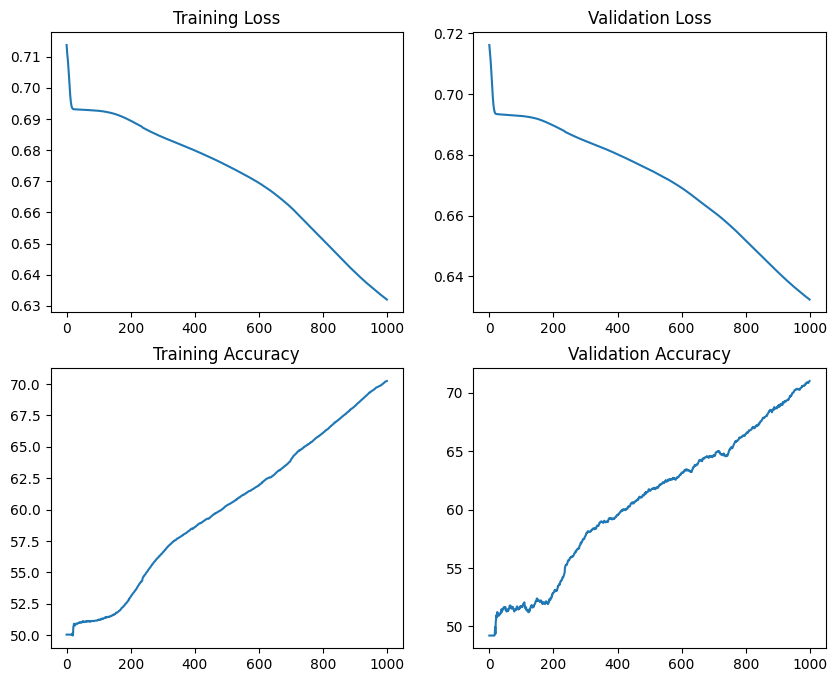

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Diagramm 1 (oben links)
axs[0, 0].plot(train_losses, label="BCELoss")
axs[0, 0].set_title('Training Loss')

axs[0, 1].plot(val_losses, label="BCELoss")
axs[0, 1].set_title('Validation Loss')

axs[1, 0].plot(train_accs, label="Accuracy")
axs[1, 0].set_title('Training Accuracy')

axs[1, 1].plot(val_accs, label="Accuracy")
axs[1, 1].set_title('Validation Accuracy')

In [14]:
autoencoder_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_autoencoder_3000_13_5.csv', shape=(3000, 13, 5))
jitt_01_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_jitt_01_3000_13_5.csv', shape=(3000, 13, 5))
jitt_02_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_jitt_02_3000_13_5.csv', shape=(3000, 13, 5))
jitt_005_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_jitt_005_3000_13_5.csv', shape=(3000, 13, 5))
timegan_gru_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_timegan_gru_3000_13_5.csv', shape=(3000, 13, 5))
timegan_lstm_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_timegan_lstm_3000_13_5.csv', shape=(3000, 13, 5))
timewarp_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_timewarp_3000_13_5.csv', shape=(3000, 13, 5))

In [15]:
results = pd.DataFrame(columns=['Method', 'Accuracy'])

In [16]:
def get_discriminative_test_performance(model, test_data, method, results):

    X_test, y_test = extract_features_and_targets_clas(test_data)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    with torch.inference_mode(): 
        test_logits = model(X_test.to(hyperparameters['device'])) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        print(test_acc)
        
        results = pd.concat([results, pd.DataFrame([{'Method': method, 'Accuracy': test_acc}])], ignore_index=True)

    return results

In [17]:
results = get_discriminative_test_performance(model, autoencoder_test, 'Autoencoder', results)
results = get_discriminative_test_performance(model, jitt_01_test, 'Jitter 0.1', results)
results = get_discriminative_test_performance(model, jitt_02_test, 'Jitter 0.2', results)
results = get_discriminative_test_performance(model, jitt_005_test, 'Jitter 0.05', results)
results = get_discriminative_test_performance(model, timegan_gru_test, 'TimeGAN GRU', results)
results = get_discriminative_test_performance(model, timegan_lstm_test, 'TimeGAN LSTM', results)
results = get_discriminative_test_performance(model, timewarp_test, 'Timewarp', results)

Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.0
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.0
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.06666666666666667
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.0
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.03333333333333333
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.03333333333333333
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.03333333333333333


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_84241/276383998.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_84241/276383998.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Method': method, 'Accuracy': test_acc}])], ignore_index=True)


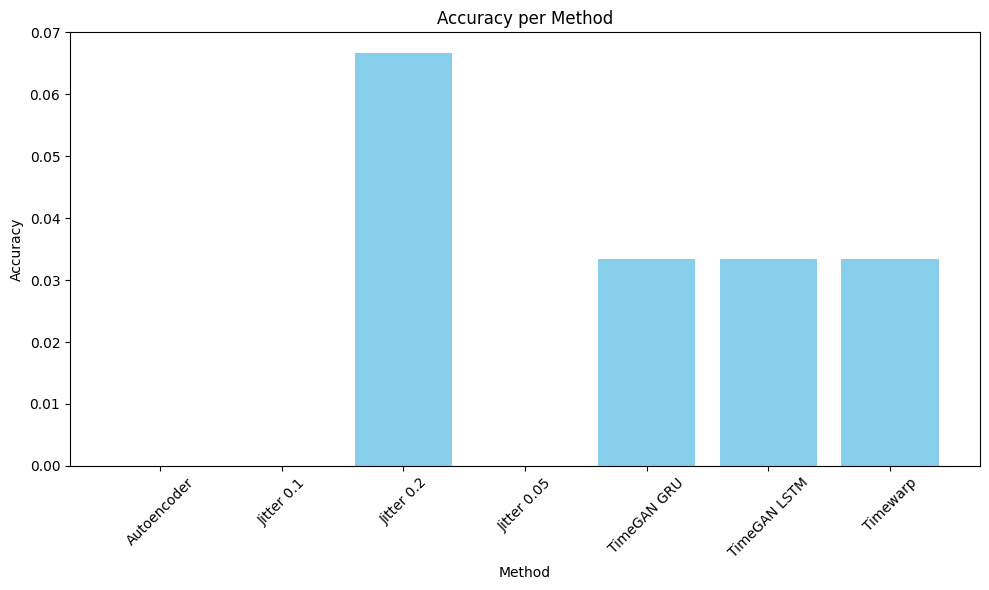

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(results['Method'], results['Accuracy'], color='skyblue')

# Diagramm anpassen
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Accuracy per Method')
plt.xticks(rotation=45)  # Optional: Dreht die Beschriftungen der x-Achse um 45 Grad
plt.tight_layout()

# Diagramm anzeigen
plt.show()

In [19]:
results.to_csv(f'{MODEL}_results.csv', index=False)